## Setup

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import matplotlib.patches as mpatches
import leidenalg
import igraph as ig
from collections import Counter
import scipy.linalg as la
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
import seaborn as sns

# Add the src directory to path for importing our package
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

# Import our DC-SBM implementation
from dcsbm import DCSBM, heldout_split, degrees

# Import bi-LRG implementation
from bilrg import BiLRG, HierarchicalBiLRG

# Import CTRNN analyzer
from sysid import CTRNNAnalyzer, FixedPointAnalysis, PortAnalyzer

In [2]:
data_path = '/Users/charlesxu/local/data/mcp/hemibrain/ring/'
results_path = os.path.join(data_path, 'results')
save_data = True
if save_data:
    os.makedirs(results_path, exist_ok=True)

## Preprocessing

Signed matrix shape: (88, 88)


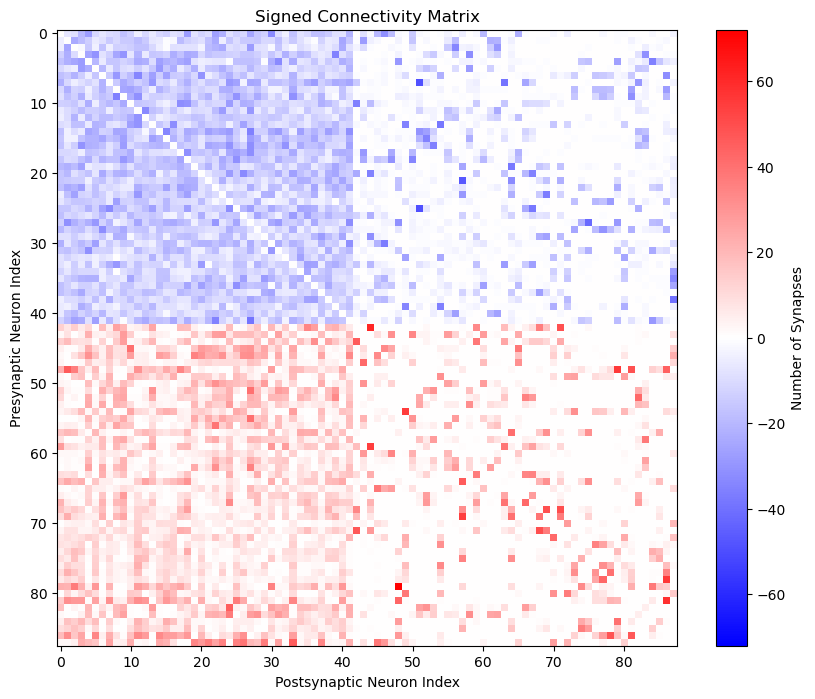

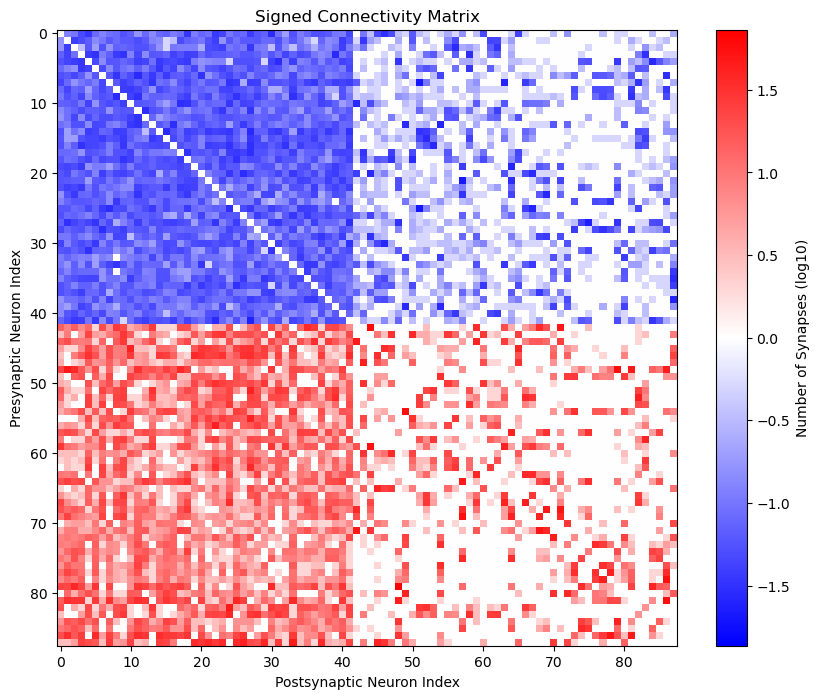

In [3]:
# Read the CSV file
connectivity_matrix_signed_df = pd.read_csv(os.path.join(data_path, 'connectivity_matrix_roi.csv'))

# Convert to square matrix (assuming first column might be row labels)
if connectivity_matrix_signed_df.shape[1] == connectivity_matrix_signed_df.shape[0] + 1:
    # If there's an extra column (likely row labels), drop it
    C_signed = connectivity_matrix_signed_df.iloc[:, 1:].values
else:
    # Otherwise, use all columns
    C_signed = connectivity_matrix_signed_df.values

print(f"Signed matrix shape: {C_signed.shape}")

# Visualize the signed connectivity matrix
plt.figure(figsize=(10, 8))
plt.imshow(C_signed, 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(C_signed)), 
           vmax=np.max(np.abs(C_signed)),
           interpolation='none')
plt.colorbar(label='Number of Synapses')
plt.title('Signed Connectivity Matrix')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')
plt.show()

# Visualize the signed connectivity matrix
plt.figure(figsize=(10, 8))
plt.imshow(np.log10(np.abs(C_signed) + 1) * np.sign(C_signed), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_signed) + 1)), 
           vmax=np.max(np.log10(np.abs(C_signed) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Signed Connectivity Matrix')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')
plt.show()

In [4]:
# Read the ctoi CSV file
ctoi_df = pd.read_csv(os.path.join(data_path, 'ctoi_list.csv'))
ctoi_list = ctoi_df['Cell Type'].tolist()
print(f"Cell type list length: {len(ctoi_list)}")
print(f"First 10 cell types: {ctoi_list[:10]}")

# Read the noi CSV file
noi_df = pd.read_csv(os.path.join(data_path, 'noi_list.csv'))
noi_list = noi_df['Neuron ID'].tolist()
print(f"Neuron ID list length: {len(noi_list)}")
print(f"First 10 neuron IDs: {noi_list[:10]}")

Cell type list length: 88
First 10 cell types: ['Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7', 'Delta7']
Neuron ID list length: 88
First 10 neuron IDs: [734581598, 880530613, 880875736, 880880259, 881221166, 910442723, 910442752, 910442782, 910783731, 910783883]


### Group by cell type

In [5]:
## Group by cell type and then for noi and connectivity matrix
# Create a mapping from cell type to indices
cell_type_indices = {}
for i, cell_type in enumerate(ctoi_list):
    if cell_type not in cell_type_indices:
        cell_type_indices[cell_type] = []
    cell_type_indices[cell_type].append(i)

# Get unique cell types in order of first appearance
unique_cell_types = []
seen_types = set()
for cell_type in ctoi_list:
    if cell_type not in seen_types:
        unique_cell_types.append(cell_type)
        seen_types.add(cell_type)

# Sort unique cell types alphabetically
unique_cell_types_sorted = sorted(unique_cell_types)

print(f"Sorted unique cell types: {unique_cell_types_sorted}")
print(f"Number of unique cell types: {len(unique_cell_types_sorted)}")

# Create new ordering with alphabetically sorted cell types
new_order_sorted = []
ctoi_grouped_sorted = []
noi_grouped_sorted = []

for cell_type in unique_cell_types_sorted:
    indices = cell_type_indices[cell_type]
    new_order_sorted.extend(indices)
    # Add cell types for this group
    ctoi_grouped_sorted.extend([cell_type] * len(indices))
    # Add corresponding neuron IDs
    for idx in indices:
        noi_grouped_sorted.append(noi_list[idx])

print(f"Sorted new order length: {len(new_order_sorted)}")
print(f"Sorted grouped ctoi length: {len(ctoi_grouped_sorted)}")
print(f"Sorted grouped noi length: {len(noi_grouped_sorted)}")

# Reorder the connectivity matrix with alphabetically sorted groups
C_signed_grouped_sorted = C_signed[np.ix_(new_order_sorted, new_order_sorted)]

print(f"Sorted grouped matrix shape: {C_signed_grouped_sorted.shape}")

# Update the variables to use the sorted versions
ctoi_grouped = ctoi_grouped_sorted
noi_grouped = noi_grouped_sorted
C_signed_grouped = C_signed_grouped_sorted
new_order = new_order_sorted
unique_cell_types = unique_cell_types_sorted

# Get the number of cells in each cell type
cell_type_counts = {}
for cell_type in unique_cell_types:
    cell_type_counts[cell_type] = len(cell_type_indices[cell_type])

print("Number of cells in each cell type:")
for cell_type in unique_cell_types:
    print(f"{cell_type}: {cell_type_counts[cell_type]}")

print(f"\nTotal number of cell types: {len(unique_cell_types)}")
print(f"Total number of cells: {sum(cell_type_counts.values())}")

Sorted unique cell types: ['Delta7', 'EPG']
Number of unique cell types: 2
Sorted new order length: 88
Sorted grouped ctoi length: 88
Sorted grouped noi length: 88
Sorted grouped matrix shape: (88, 88)
Number of cells in each cell type:
Delta7: 42
EPG: 46

Total number of cell types: 2
Total number of cells: 88


### Remove unconnected nodes

In [6]:
C_unsigned_grouped = np.abs(C_signed_grouped)

# Detect unconnected neurons: both in-degree and out-degree are zero
out_degree = np.sum(C_unsigned_grouped, axis=1)
in_degree = np.sum(C_unsigned_grouped, axis=0)

# Find neurons with zero degree (both in and out)
zero_degree_mask = (out_degree == 0) & (in_degree == 0)
unconnected_indices = np.where(zero_degree_mask)[0]
connected_indices = np.where(~zero_degree_mask)[0]

print(f"Total neurons: {len(C_unsigned_grouped)}")
print(f"Unconnected neurons (zero in-degree and out-degree): {len(unconnected_indices)}")
print(f"Connected neurons: {len(connected_indices)}")

if len(unconnected_indices) > 0:
    print(f"\nUnconnected neuron indices: {unconnected_indices[:20]}...")  # Show first 20
    
    # Display cell types of unconnected neurons
    unconnected_cell_types = [ctoi_grouped[i] for i in unconnected_indices]
    cell_type_distribution = Counter(unconnected_cell_types)
    print(f"\nCell type distribution of unconnected neurons:")
    for cell_type, count in sorted(cell_type_distribution.items()):
        print(f"  {cell_type}: {count}")
    
    # Remove unconnected neurons from all relevant data structures
    C_signed_grouped_connected = C_signed_grouped[np.ix_(connected_indices, connected_indices)]
    C_unsigned_grouped_connected = C_unsigned_grouped[np.ix_(connected_indices, connected_indices)]
    ctoi_grouped_connected = [ctoi_grouped[i] for i in connected_indices]
    noi_grouped_connected = [noi_grouped[i] for i in connected_indices]
    new_order_connected = [new_order[i] for i in connected_indices]
    
    print(f"\nConnected matrix shape: {C_unsigned_grouped_connected.shape}")
    print(f"Connected ctoi length: {len(ctoi_grouped_connected)}")
    print(f"Connected noi length: {len(noi_grouped_connected)}")
    
    # Update variables to use connected versions
    C_signed_grouped = C_signed_grouped_connected
    C_unsigned_grouped = C_unsigned_grouped_connected
    ctoi_grouped = ctoi_grouped_connected
    noi_grouped = noi_grouped_connected
    new_order = new_order_connected
    unique_cell_types = np.unique(ctoi_grouped).tolist()
    
    # Recalculate cell type counts
    cell_type_counts = {}
    for cell_type in ctoi_grouped:
        cell_type_counts[cell_type] = cell_type_counts.get(cell_type, 0) + 1
    
    print(f"\nUpdated cell type counts (connected neurons only):")
    print(f"Number of unique cell types: {len(unique_cell_types)}")
else:
    print("\nAll neurons are connected.")

Total neurons: 88
Unconnected neurons (zero in-degree and out-degree): 0
Connected neurons: 88

All neurons are connected.


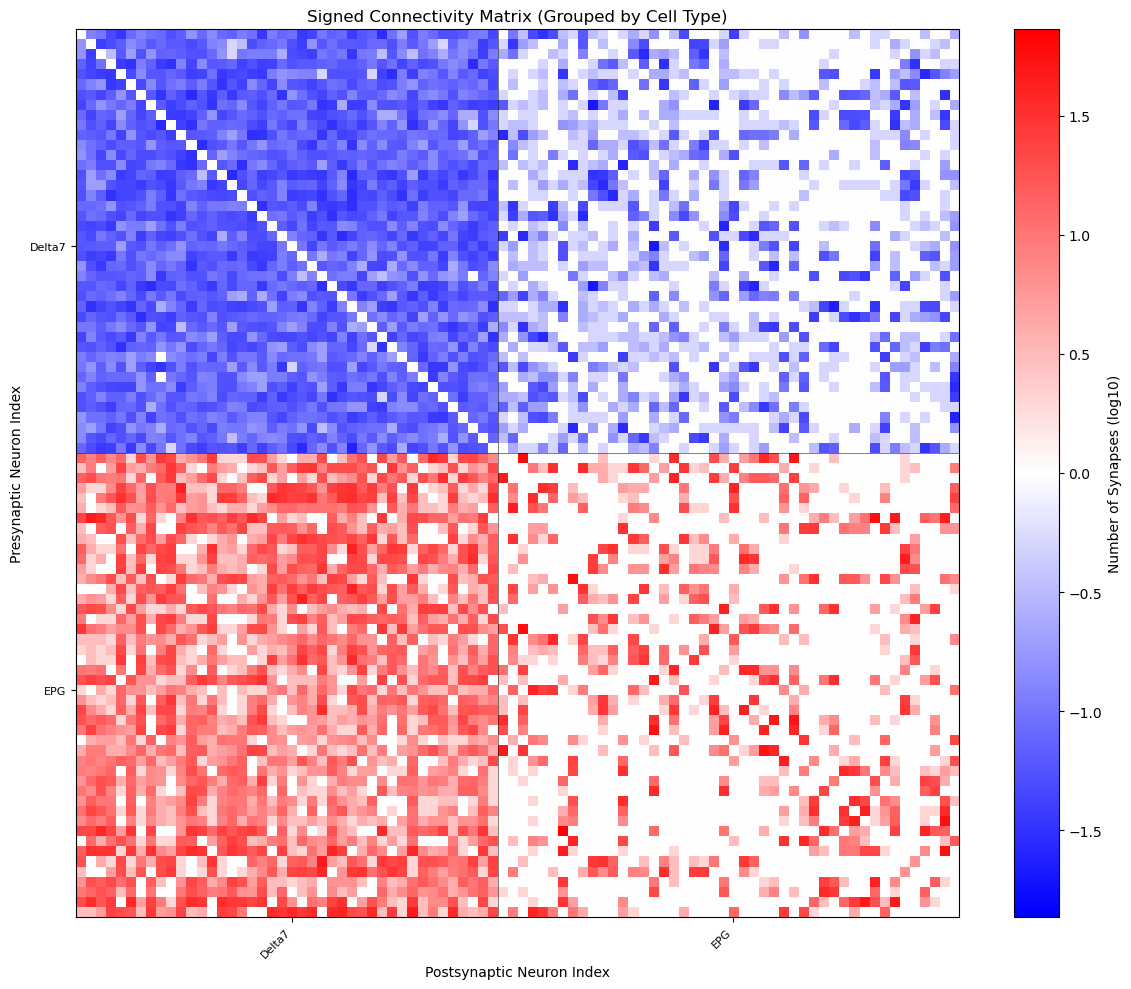

In [7]:
# Visualize the grouped connectivity matrix with cell type labels
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_signed_grouped) + 1) * np.sign(C_signed_grouped), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_signed_grouped) + 1)), 
           vmax=np.max(np.log10(np.abs(C_signed_grouped) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Signed Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

### Weight-only (unsigned) matrix

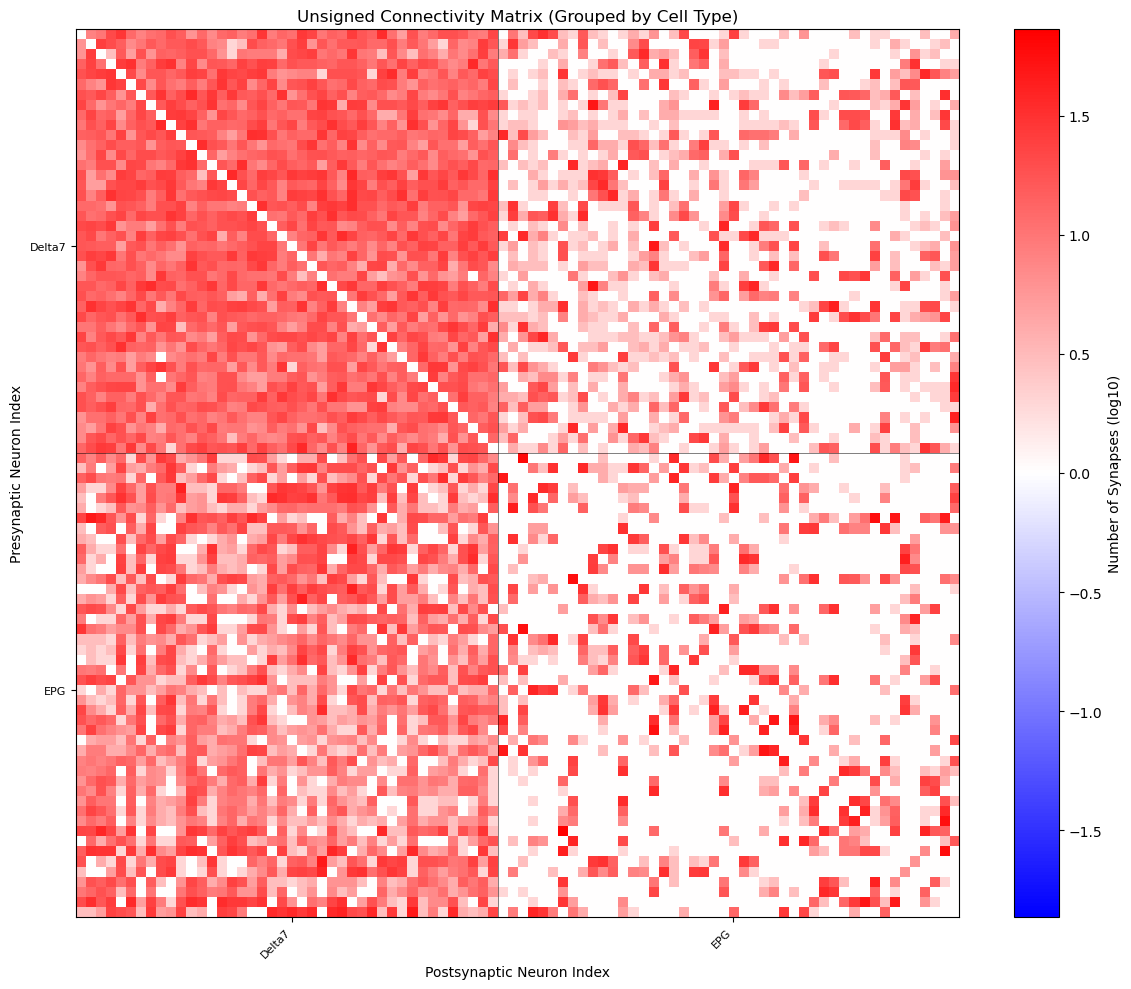

In [8]:
# Visualize the unsigned grouped connectivity matrix
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_unsigned_grouped) + 1), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_unsigned_grouped) + 1)), 
           vmax=np.max(np.log10(np.abs(C_unsigned_grouped) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Unsigned Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [9]:
# Workspace checkpoint
variables_to_keep = ['ctoi_grouped', 'noi_grouped', 'C_signed_grouped', 'C_unsigned_grouped', 'new_order', 'unique_cell_types', 'cell_type_counts']
print("Variables to keep for further analysis:")
for var in variables_to_keep:
    if var in globals():
        var_obj = globals()[var]
        var_type = type(var_obj).__name__
        
        if hasattr(var_obj, 'shape'):
            structure = f"shape: {var_obj.shape}"
        elif hasattr(var_obj, '__len__'):
            structure = f"length: {len(var_obj)}"
        else:
            structure = "scalar"
            
        print(f"\t{var}: {var_type}, {structure}")
    else:
        print(f"\t{var}: NOT FOUND")

Variables to keep for further analysis:
	ctoi_grouped: list, length: 88
	noi_grouped: list, length: 88
	C_signed_grouped: ndarray, shape: (88, 88)
	C_unsigned_grouped: ndarray, shape: (88, 88)
	new_order: list, length: 88
	unique_cell_types: list, length: 2
	cell_type_counts: dict, length: 2


### Select cell types

In [10]:
# select_cell_type = ['Delta7', 'EPG']
# select_cell_type = ['Delta7', 'EPG', 'ER2', 'PEN_a(PEN1)']
select_cell_type = ['EPG']
# select_cell_type = unique_cell_types # Use all cell types
select_indices = [i for i, ct in enumerate(ctoi_grouped) if ct in select_cell_type]
ctoi_grouped = [ctoi_grouped[i] for i in select_indices]
noi_grouped = [noi_grouped[i] for i in select_indices]
C_signed_grouped = C_signed_grouped[np.ix_(select_indices, select_indices)]
C_unsigned_grouped = C_unsigned_grouped[np.ix_(select_indices, select_indices)]
new_order = [new_order[i] for i in select_indices]
unique_cell_types = select_cell_type
cell_type_counts = {ct: ctoi_grouped.count(ct) for ct in unique_cell_types}

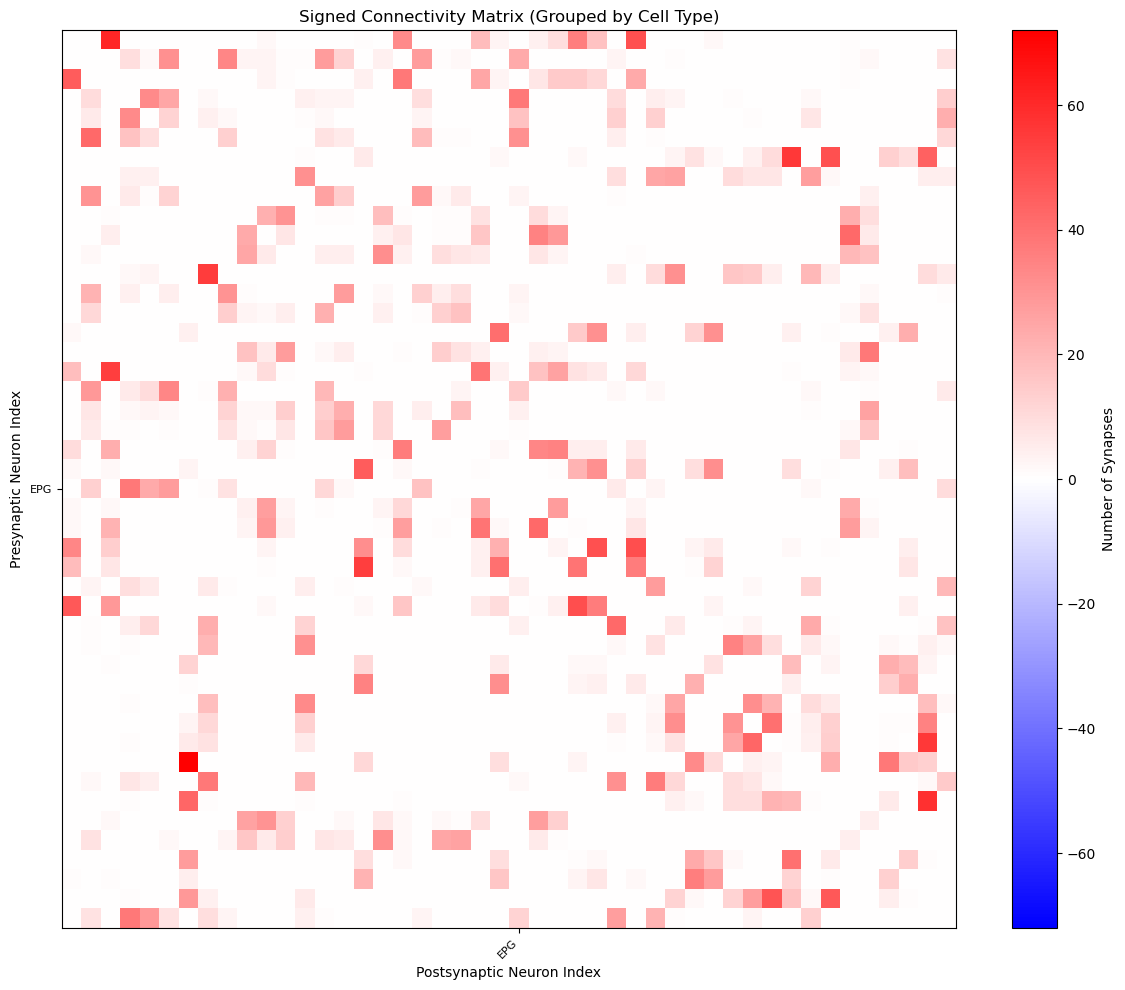

In [11]:
# Visualize the grouped connectivity matrix with cell type labels
plt.figure(figsize=(12, 10))
plt.imshow(C_signed_grouped, 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(C_signed_grouped)), 
           vmax=np.max(np.abs(C_signed_grouped)),
           interpolation='none')
plt.colorbar(label='Number of Synapses')
plt.title('Signed Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

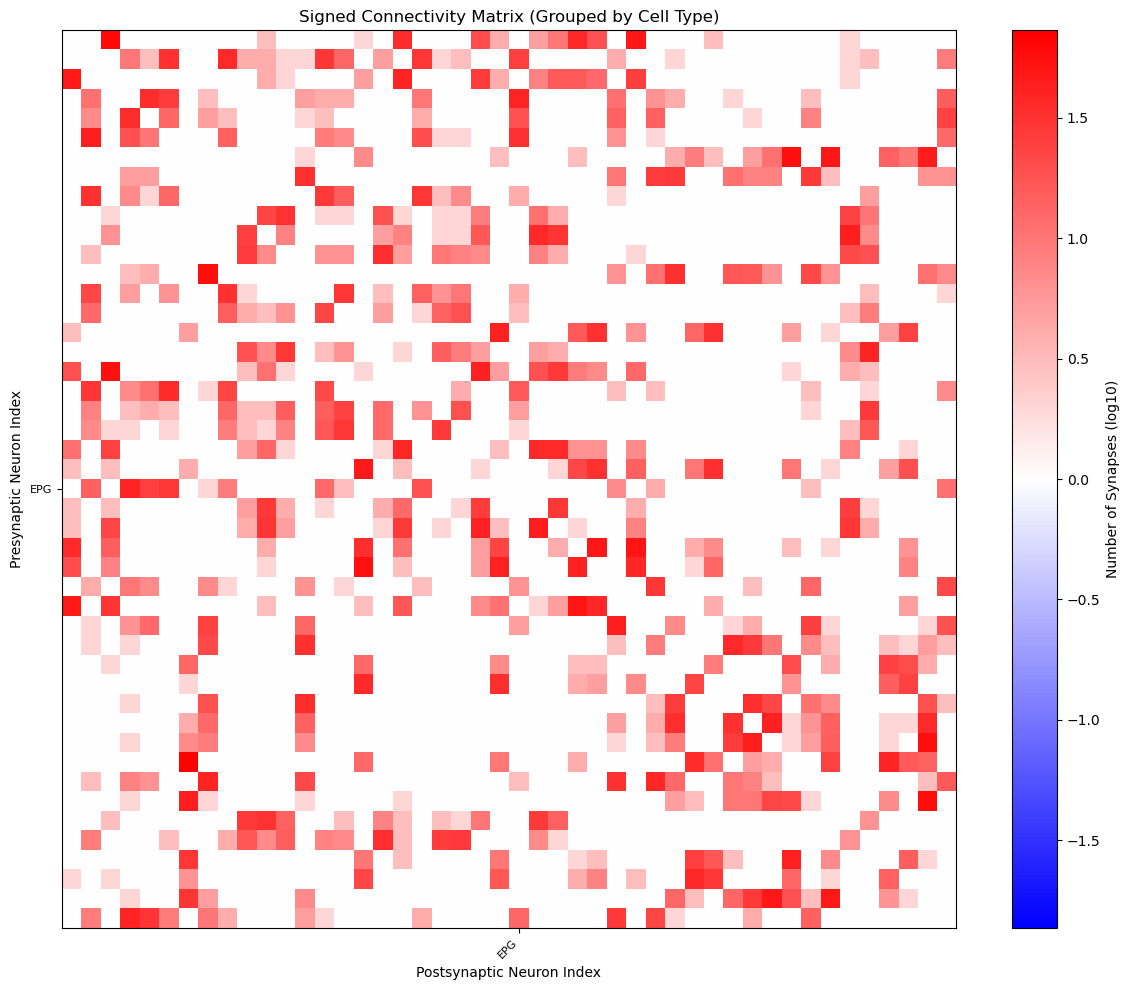

In [12]:
# Visualize the grouped connectivity matrix with cell type labels
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_signed_grouped) + 1) * np.sign(C_signed_grouped), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_signed_grouped) + 1)), 
           vmax=np.max(np.log10(np.abs(C_signed_grouped) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Signed Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

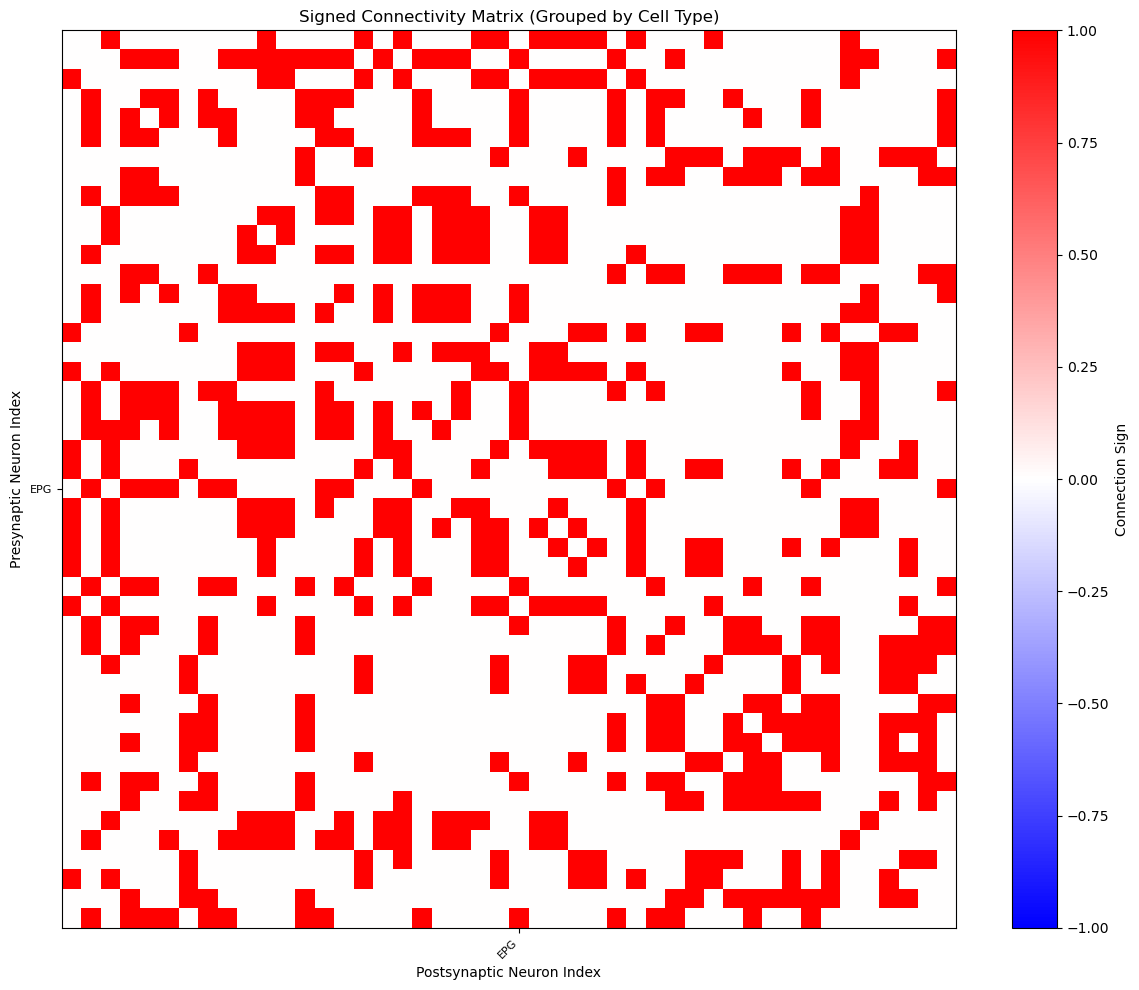

In [13]:
# Visualize the grouped connectivity matrix with cell type labels
plt.figure(figsize=(12, 10))
plt.imshow(np.sign(C_signed_grouped), 
           cmap='bwr', aspect='auto', 
           vmin=-1, 
           vmax=1,
           interpolation='none')
plt.colorbar(label='Connection Sign')
plt.title('Signed Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

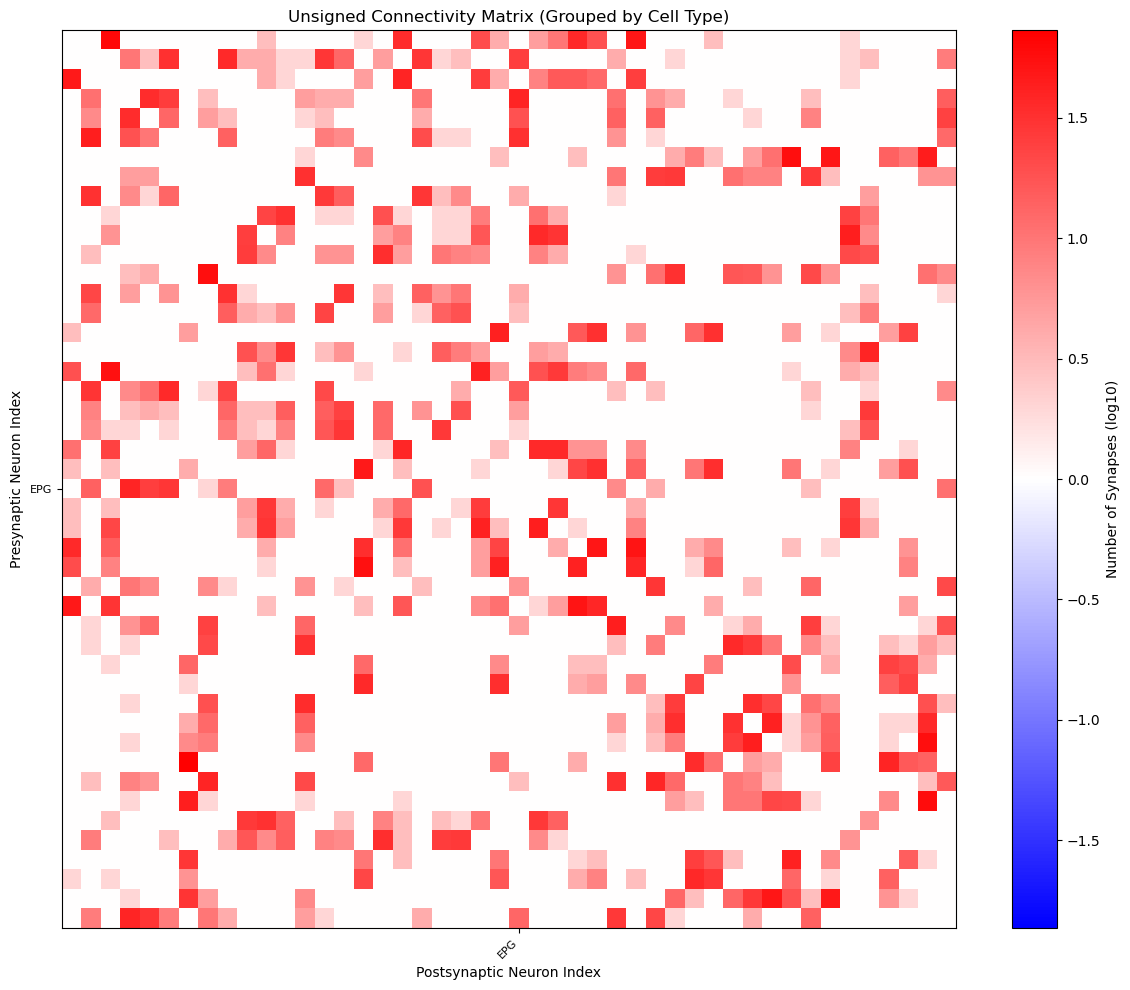

In [14]:
# Visualize the unsigned grouped connectivity matrix
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_unsigned_grouped) + 1), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_unsigned_grouped) + 1)), 
           vmax=np.max(np.log10(np.abs(C_unsigned_grouped) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Unsigned Connectivity Matrix (Grouped by Cell Type)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add cell type group boundaries and labels
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = len(cell_type_indices[cell_type])
    group_boundaries.append(current_pos + group_size)

    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)

    # Set x and y ticks with cell type labels
    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
    plt.yticks(tick_positions, tick_labels, fontsize=8)
    current_pos += group_size

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:  # Exclude the last boundary
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

### Normalization

#### Uniform scaling

#### Information-based normalization

### Isomorphism

#### Spectral seriation

In [15]:
def spectral_seriation(A, symmetrize=True):
    """
    Perform spectral seriation on a square matrix.

    Parameters
    ----------
    A : np.ndarray, shape (N, N)
        Input square matrix (e.g. adjacency or weight matrix).
    symmetrize : bool, optional
        If True, first symmetrize by W = (|A| + |A.T|) / 2 before
        building the Laplacian. This is usually what you want for
        spectral ordering on directed / signed matrices.

    Returns
    -------
    perm : np.ndarray, shape (N,)
        Permutation indices such that A_reordered = A[perm][:, perm].
    A_reordered : np.ndarray, shape (N, N)
        Matrix reordered by the spectral seriation permutation.
    """
    A = np.asarray(A)
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("A must be a square 2D array")

    n = A.shape[0]
    if n <= 1:
        # Trivial case
        return np.arange(n), A.copy()

    # Step 1: symmetrize (optional but recommended)
    if symmetrize:
        W = 0.5 * (np.abs(A) + np.abs(A.T))
    else:
        # Assume A is already symmetric / suitable
        W = np.asarray(A, dtype=float)

    # Step 2: build (unnormalized) graph Laplacian L = D - W
    degrees = W.sum(axis=1)
    L = np.diag(degrees) - W

    # Step 3: eigen-decomposition of symmetric Laplacian
    # eigh is for Hermitian/symmetric matrices
    evals, evecs = np.linalg.eigh(L)

    # Step 4: take Fiedler vector (second smallest eigenvalue)
    # If graph is disconnected, there may be multiple zeros; this
    # still typically gives a meaningful ordering.
    if n > 1:
        fiedler_vec = evecs[:, 1]
    else:
        fiedler_vec = evecs[:, 0]

    # Step 5: sort indices by Fiedler vector coordinates
    perm = np.argsort(fiedler_vec)

    # Step 6: reorder original matrix using the same permutation
    A_reordered = A[np.ix_(perm, perm)]

    return perm, A_reordered

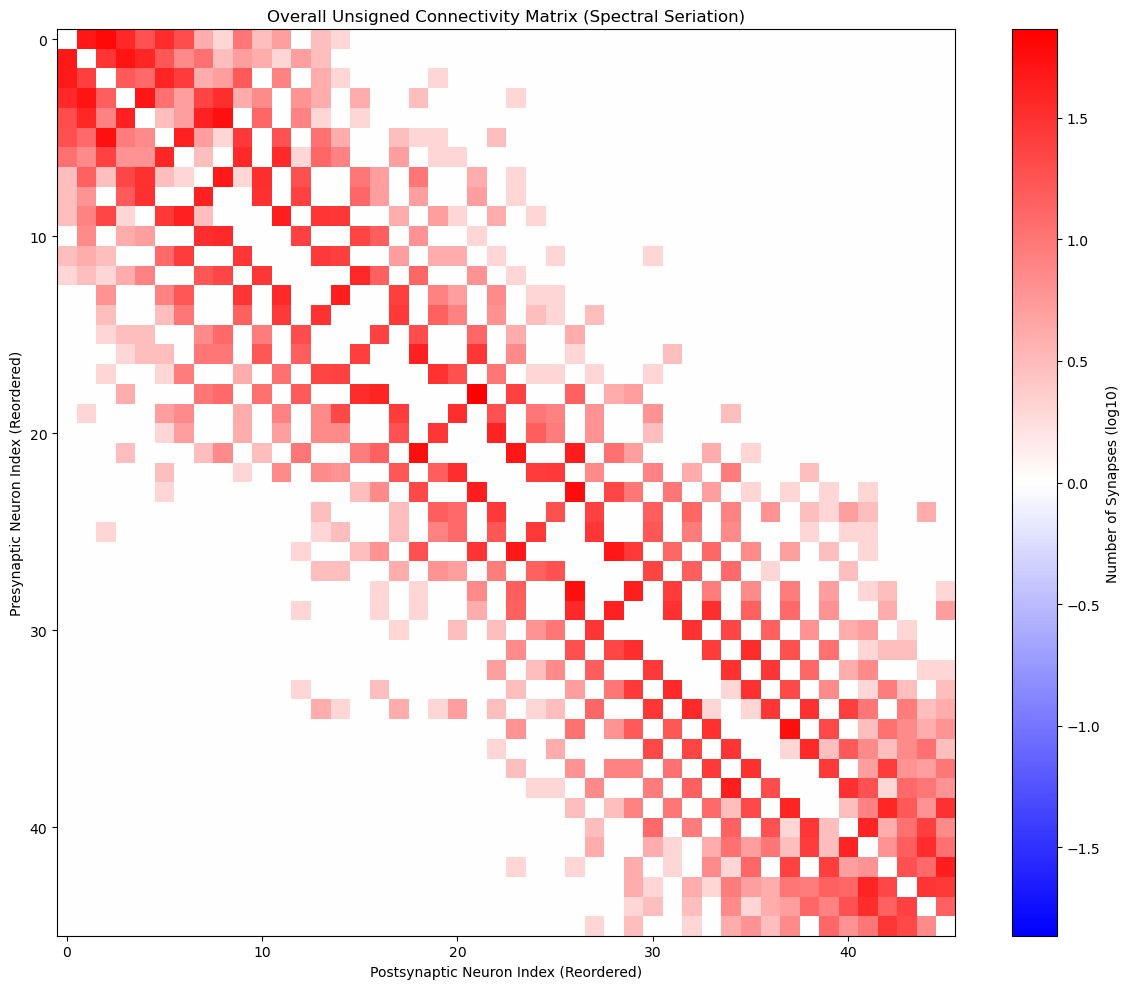

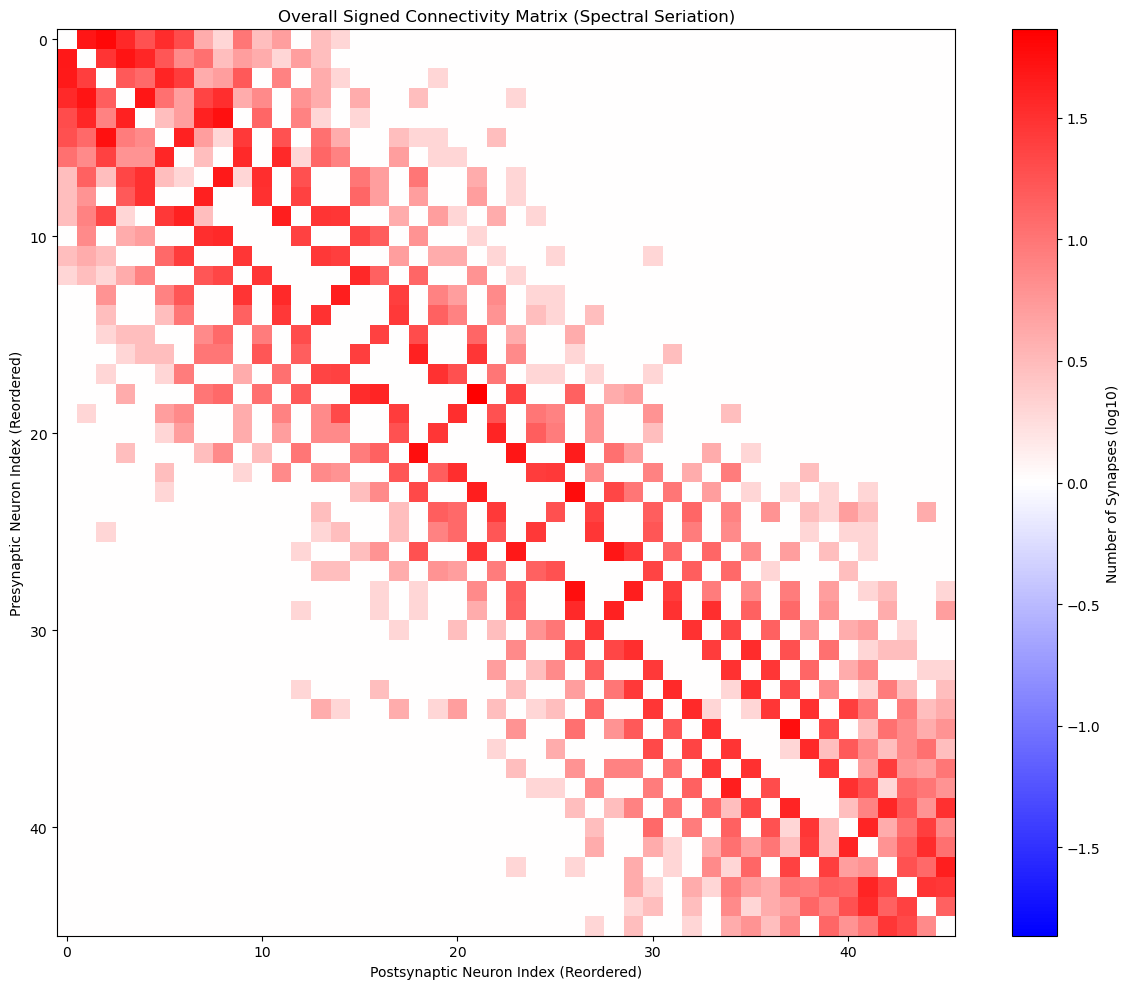

In [16]:
C_unsigned_seriated = C_unsigned_grouped.copy()

A = C_unsigned_seriated.copy()
perm, _ = spectral_seriation(A)

C_unsigned_seriated = C_unsigned_seriated[perm][:, perm]

# Visualize the overall seriated unsigned grouped connectivity matrix
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_unsigned_seriated) + 1), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_unsigned_seriated) + 1)), 
           vmax=np.max(np.log10(np.abs(C_unsigned_seriated) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Overall Unsigned Connectivity Matrix (Spectral Seriation)')
plt.xlabel('Postsynaptic Neuron Index (Reordered)')
plt.ylabel('Presynaptic Neuron Index (Reordered)')
plt.tight_layout()
plt.show()

C_signed_seriated = C_signed_grouped.copy()
C_signed_seriated = C_signed_seriated[perm][:, perm]

# Visualize the overall seriated signed grouped connectivity matrix
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(C_signed_seriated) + 1) * np.sign(C_signed_seriated), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(C_signed_seriated) + 1)), 
           vmax=np.max(np.log10(np.abs(C_signed_seriated) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Overall Signed Connectivity Matrix (Spectral Seriation)')
plt.xlabel('Postsynaptic Neuron Index (Reordered)')
plt.ylabel('Presynaptic Neuron Index (Reordered)')
plt.tight_layout()
plt.show()

### Checkpoint

In [17]:
variables_to_keep = ['ctoi_grouped', 'noi_grouped', 'C_signed_grouped', 'C_unsigned_grouped', 'new_order', 'unique_cell_types', 'cell_type_counts', 'C_signed_seriated', 'C_unsigned_seriated']
print("Variables to keep for further analysis:")
for var in variables_to_keep:
    if var in globals():
        var_obj = globals()[var]
        var_type = type(var_obj).__name__
        
        if hasattr(var_obj, 'shape'):
            structure = f"shape: {var_obj.shape}"
        elif hasattr(var_obj, '__len__'):
            structure = f"length: {len(var_obj)}"
        else:
            structure = "scalar"
            
        print(f"\t{var}: {var_type}, {structure}")
    else:
        print(f"\t{var}: NOT FOUND")

Variables to keep for further analysis:
	ctoi_grouped: list, length: 46
	noi_grouped: list, length: 46
	C_signed_grouped: ndarray, shape: (46, 46)
	C_unsigned_grouped: ndarray, shape: (46, 46)
	new_order: list, length: 46
	unique_cell_types: list, length: 1
	cell_type_counts: dict, length: 1
	C_signed_seriated: ndarray, shape: (46, 46)
	C_unsigned_seriated: ndarray, shape: (46, 46)


## System reduction

In [18]:
# C_unsigned_grouped_thresholded = C_unsigned_grouped.copy()
# threshold = np.max(np.abs(C_unsigned_grouped)) / 2
# C_unsigned_grouped_thresholded[C_unsigned_grouped_thresholded < threshold] = 1

In [19]:
# A = C_unsigned_grouped
# A = C_unsigned_grouped_thresholded
A = C_unsigned_seriated

### Graph Laplacians

#### Directed, combinatorial Laplacians

In [20]:
# Compute out-degree and in-degree for A
# Out-degree: sum of outgoing connections (row sums)
D_out = np.sum(A, axis=1)

# In-degree: sum of incoming connections (column sums)
D_in = np.sum(A, axis=0)

print(f"Out-degree D_out shape: {D_out.shape}")
print(f"In-degree D_in shape: {D_in.shape}")
print(f"Out-degree range: {D_out.min():.2f} - {D_out.max():.2f}")
print(f"In-degree range: {D_in.min():.2f} - {D_in.max():.2f}")

# Create diagonal degree matrices
D_out = np.diag(D_out)
D_in = np.diag(D_in)

# Compute out-degree Laplacian: L_out = D_out - A
L_out = D_out - A

# Compute in-degree Laplacian: L_in = D_in - A^T
L_in = D_in - A.T

print(f"\nOut-degree Laplacian L_out shape: {L_out.shape}")
print(f"In-degree Laplacian L_in shape: {L_in.shape}")

# Verify Laplacian properties
# Row sums of L_out should be zero
row_sums_L_out = np.sum(L_out, axis=1)
print(f"\nL_out row sums (should be ~0): max abs = {np.abs(row_sums_L_out).max():.2e}")

# Column sums of L_in should be zero
col_sums_L_in = np.sum(L_in, axis=0)
print(f"L_in column sums (should be ~0): max abs = {np.abs(col_sums_L_in).max():.2e}")

# Show some statistics
print(f"\nDegree statistics:")
print(f"Mean out-degree: {D_out.mean():.2f}")
print(f"Mean in-degree: {D_in.mean():.2f}")
print(f"Std out-degree: {D_out.std():.2f}")
print(f"Std in-degree: {D_in.std():.2f}")

Out-degree D_out shape: (46,)
In-degree D_in shape: (46,)
Out-degree range: 100.00 - 238.00
In-degree range: 101.00 - 250.00

Out-degree Laplacian L_out shape: (46, 46)
In-degree Laplacian L_in shape: (46, 46)

L_out row sums (should be ~0): max abs = 0.00e+00
L_in column sums (should be ~0): max abs = 6.10e+01

Degree statistics:
Mean out-degree: 3.66
Mean in-degree: 3.66
Std out-degree: 25.06
Std in-degree: 25.02


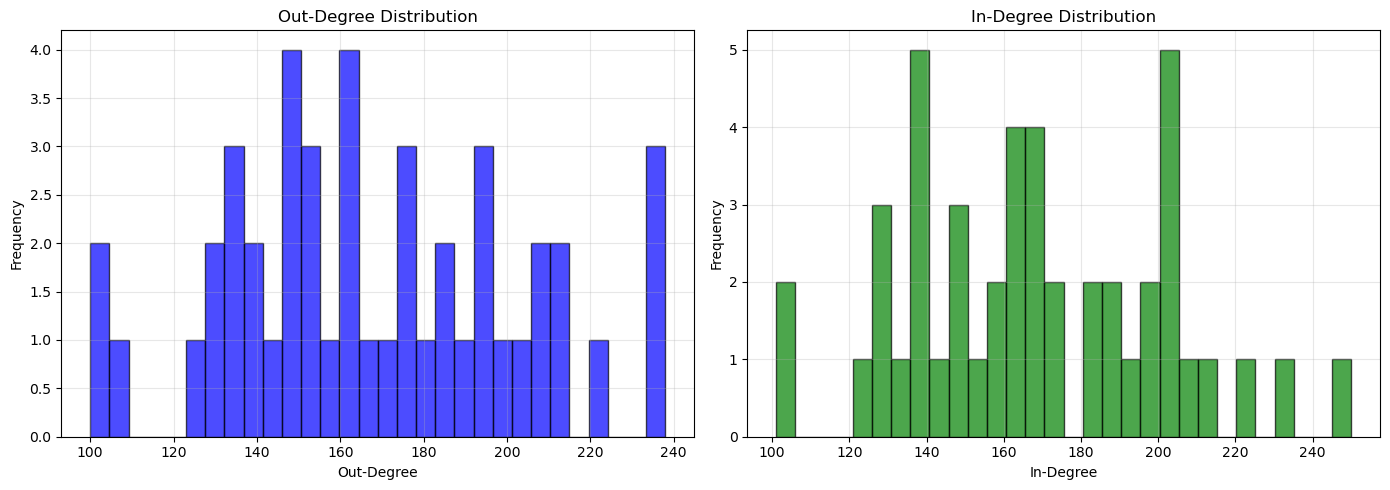

Out-Degree Statistics:
  Mean: 168.24
  Std: 34.62
  Min: 100.00
  Max: 238.00

In-Degree Statistics:
  Mean: 168.24
  Std: 33.13
  Min: 101.00
  Max: 250.00


In [21]:
# Calculate out-degree and in-degree
out_degree = np.sum(A, axis=1)
in_degree = np.sum(A, axis=0)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot out-degree distribution
axes[0].hist(out_degree, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Out-Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Out-Degree Distribution')
axes[0].grid(True, alpha=0.3)

# Plot in-degree distribution
axes[1].hist(in_degree, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Frequency')
axes[1].set_title('In-Degree Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("Out-Degree Statistics:")
print(f"  Mean: {out_degree.mean():.2f}")
print(f"  Std: {out_degree.std():.2f}")
print(f"  Min: {out_degree.min():.2f}")
print(f"  Max: {out_degree.max():.2f}")

print("\nIn-Degree Statistics:")
print(f"  Mean: {in_degree.mean():.2f}")
print(f"  Std: {in_degree.std():.2f}")
print(f"  Min: {in_degree.min():.2f}")
print(f"  Max: {in_degree.max():.2f}")

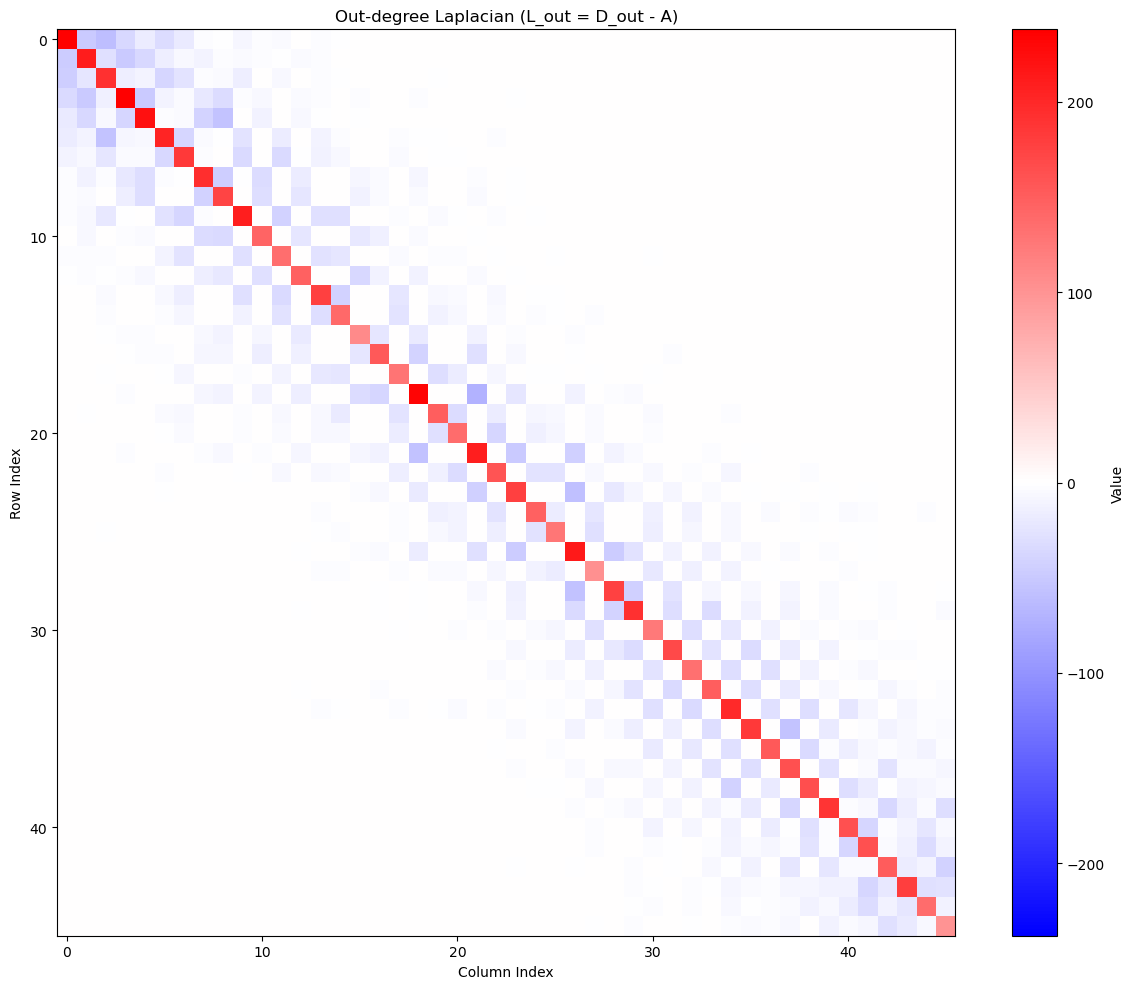

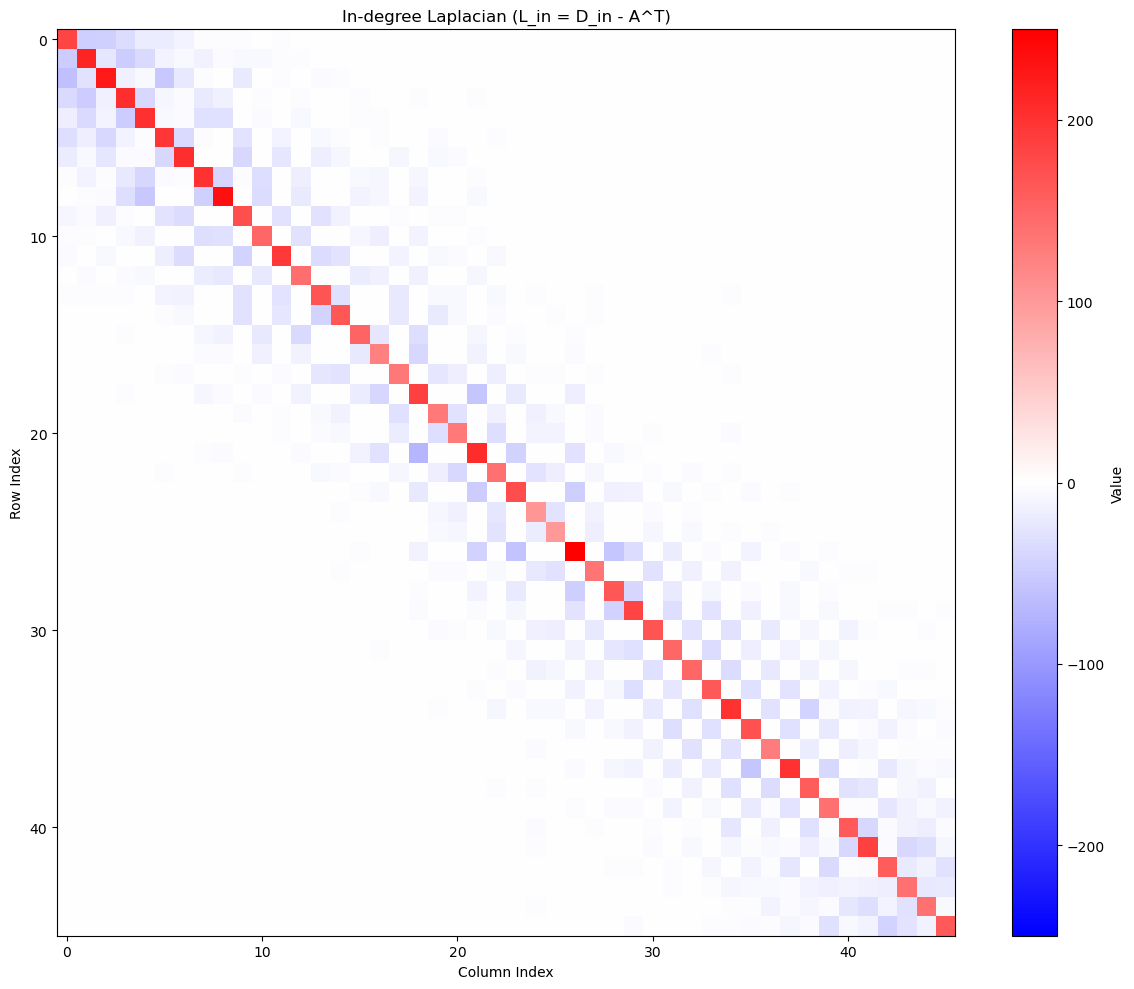

Out-degree Laplacian (L_out) statistics:
  Min: -72.00
  Max: 238.00
  Mean: 0.00
  Std: 27.15

In-degree Laplacian (L_in) statistics:
  Min: -72.00
  Max: 250.00
  Mean: 0.00
  Std: 27.11


In [22]:
# Visualize the out-degree and in-degree Laplacians
# Plot L_out
plt.figure(figsize=(12, 10))
plt.imshow(L_out, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(L_out)), 
           vmax=np.max(np.abs(L_out)), 
           interpolation='none')
plt.colorbar(label='Value')
plt.title('Out-degree Laplacian (L_out = D_out - A)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

# Plot L_in
plt.figure(figsize=(12, 10))
plt.imshow(L_in, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(L_in)), 
           vmax=np.max(np.abs(L_in)), 
           interpolation='none')
plt.colorbar(label='Value')
plt.title('In-degree Laplacian (L_in = D_in - A^T)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

# Show some statistics about the Laplacians
print("Out-degree Laplacian (L_out) statistics:")
print(f"  Min: {L_out.min():.2f}")
print(f"  Max: {L_out.max():.2f}")
print(f"  Mean: {L_out.mean():.2f}")
print(f"  Std: {L_out.std():.2f}")

print("\nIn-degree Laplacian (L_in) statistics:")
print(f"  Min: {L_in.min():.2f}")
print(f"  Max: {L_in.max():.2f}")
print(f"  Mean: {L_in.mean():.2f}")
print(f"  Std: {L_in.std():.2f}")

#### Random walk Laplacian

In [23]:
# Compute random walk Laplacian L_rw = I - D_out^(-1) * A
# First, compute D_out^(-1)
try:
    D_out_inv = np.linalg.inv(D_out)
    
    # Compute the random walk Laplacian
    I = np.eye(len(A))
    L_rw = I - D_out_inv @ A

    print(f"Random walk Laplacian L_rw shape: {L_rw.shape}")

    # Verify properties of random walk Laplacian
    # Row sums should be zero (since each row of D_out^(-1) * A sums to 1)
    row_sums_L_rw = np.sum(L_rw, axis=1)
    print(f"L_rw row sums (should be ~0): max abs = {np.abs(row_sums_L_rw).max():.2e}")

    # Check for any numerical issues (zeros on diagonal of D_out would cause problems)
    print(f"\nMin diagonal value of D_out: {np.diag(D_out).min():.2f}")
    print(f"Number of zero-degree nodes: {np.count_nonzero(np.diag(D_out) == 0)}")

    # Show some statistics
    print(f"\nRandom walk Laplacian statistics:")
    print(f"L_rw min: {L_rw.min():.4f}")
    print(f"L_rw max: {L_rw.max():.4f}")
    print(f"L_rw mean: {L_rw.mean():.4f}")
except Exception as e:
    print("Error computing random walk Laplacian:", e)

Random walk Laplacian L_rw shape: (46, 46)
L_rw row sums (should be ~0): max abs = 2.78e-16

Min diagonal value of D_out: 100.00
Number of zero-degree nodes: 0

Random walk Laplacian statistics:
L_rw min: -0.3277
L_rw max: 1.0000
L_rw mean: 0.0000


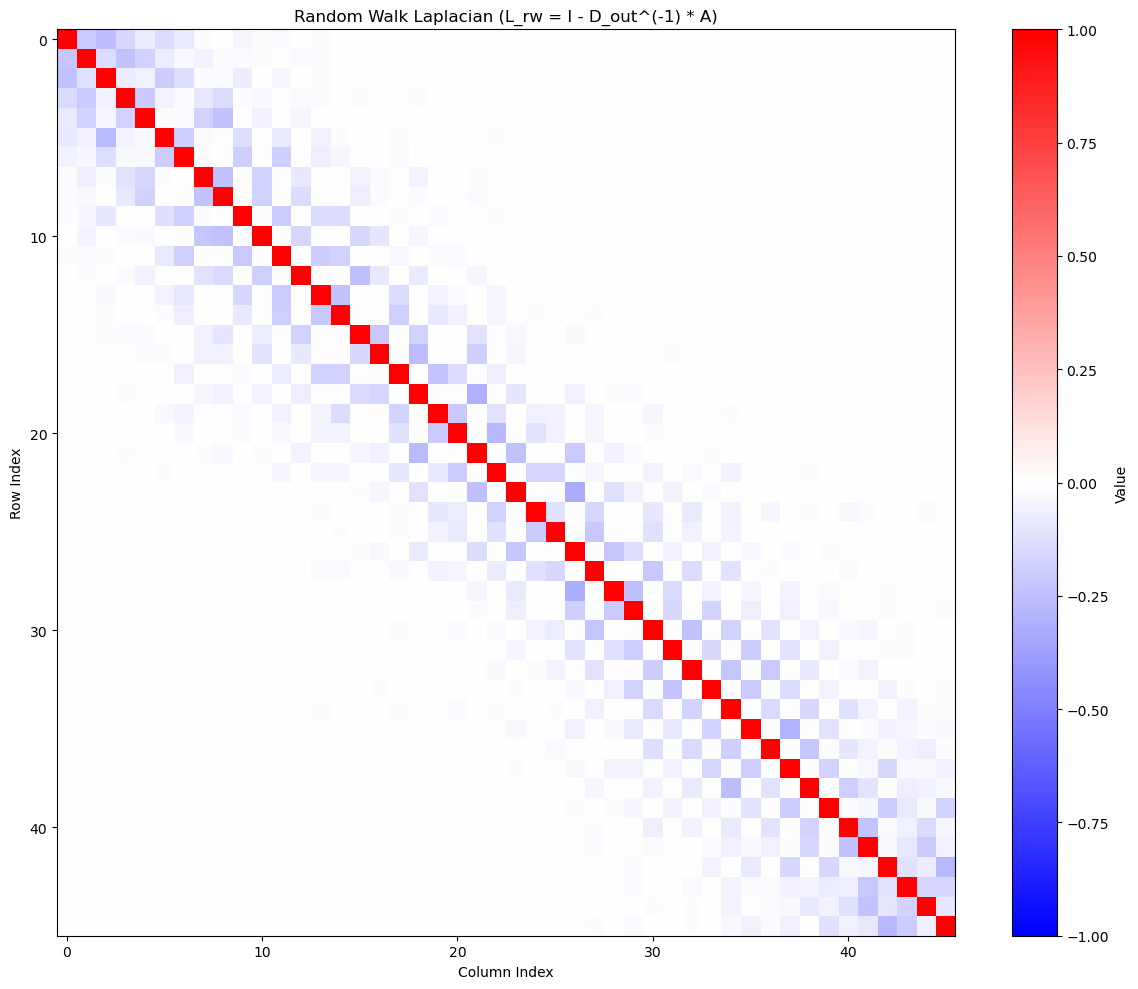

In [24]:
# Visualize the random walk Laplacian
if 'L_rw' in locals():
    # Plot L_rw
    plt.figure(figsize=(12, 10))
    plt.imshow(L_rw, cmap='bwr', aspect='auto', 
            vmin=-np.max(np.abs(L_rw)), 
            vmax=np.max(np.abs(L_rw)), 
            interpolation='none')
    plt.colorbar(label='Value')
    plt.title('Random Walk Laplacian (L_rw = I - D_out^(-1) * A)')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.tight_layout()
    plt.show()

#### Normalized Laplacian

##### Symmetrize then normalize

Treating A undirected.

In [25]:
# Compute the symmetric Laplacian L_sym = I - D^(-1/2) * A_sym * D^(-1/2)
A_sym = (A + A.T) / 2
D_sym = np.diag(np.sum(A_sym, axis=1))
try:
    D_sym_inv_sqrt = np.linalg.inv(np.sqrt(D_sym))
    
    # Compute the symmetric Laplacian
    I = np.eye(len(A_sym))
    L_sym = I - D_sym_inv_sqrt @ A_sym @ D_sym_inv_sqrt

    print(f"Symmetric Laplacian L_sym shape: {L_sym.shape}")

    # Verify properties of symmetric Laplacian
    # Row sums should be zero
    row_sums_L_sym = np.sum(L_sym, axis=1)
    print(f"L_sym row sums (should be ~0): max abs = {np.abs(row_sums_L_sym).max():.2e}")

    # Check for any numerical issues (zeros on diagonal of D_sym would cause problems)
    print(f"\nMin diagonal value of D_sym: {np.diag(D_sym).min():.2f}")
    print(f"Number of zero-degree nodes: {np.count_nonzero(np.diag(D_sym) == 0)}")

    # Show some statistics
    print(f"\nSymmetric Laplacian statistics:")
    print(f"L_sym min: {L_sym.min():.4f}")
    print(f"L_sym max: {L_sym.max():.4f}")
    print(f"L_sym mean: {L_sym.mean():.4f}")
except Exception as e:
    print("Error computing symmetric Laplacian:", e)

Symmetric Laplacian L_sym shape: (46, 46)
L_sym row sums (should be ~0): max abs = 1.64e-01

Min diagonal value of D_sym: 114.50
Number of zero-degree nodes: 0

Symmetric Laplacian statistics:
L_sym min: -0.3062
L_sym max: 1.0000
L_sym mean: 0.0001


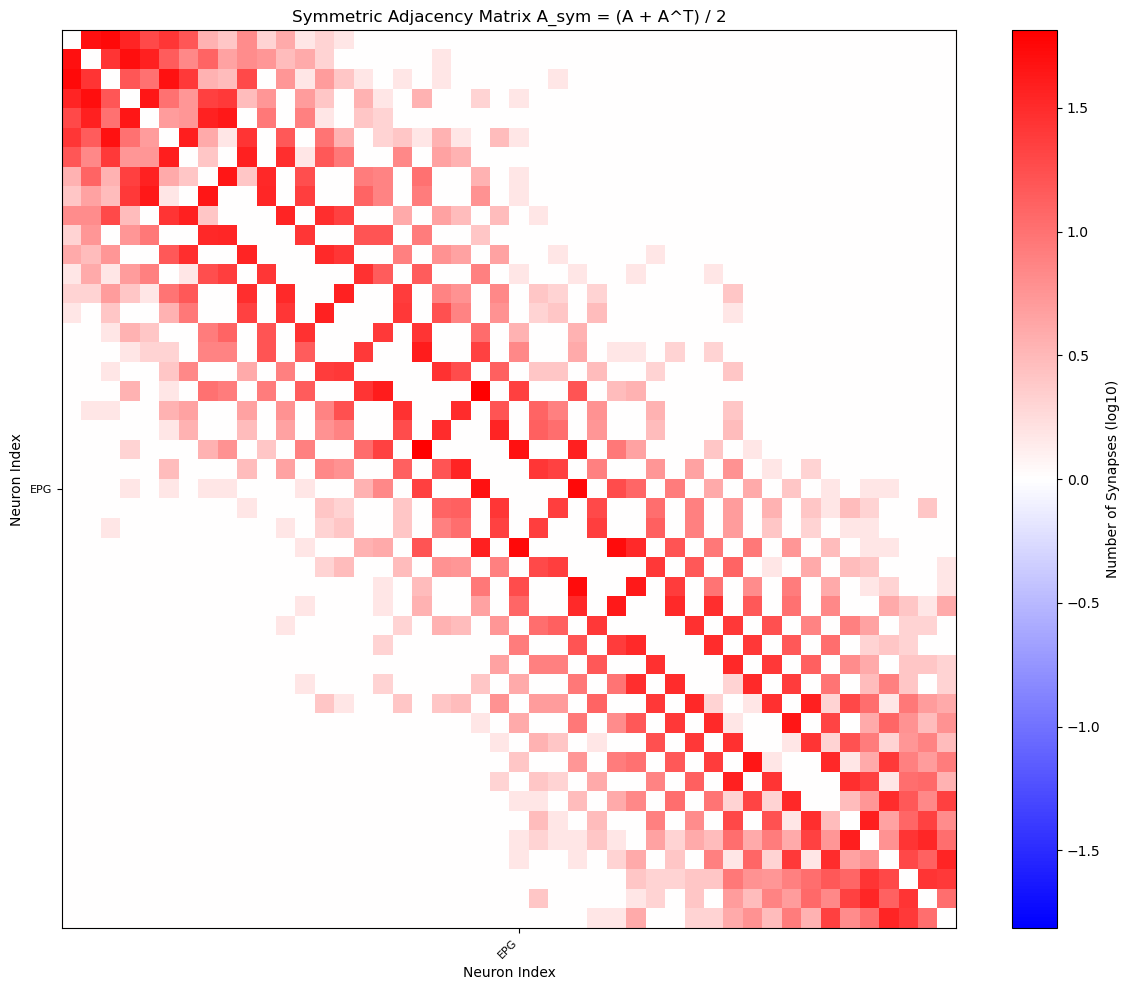

A_sym shape: (46, 46)
A_sym min: 0.00
A_sym max: 64.00
A_sym mean: 3.66
Number of non-zero entries: 716

Symmetry error (should be ~0): 0.00e+00


In [26]:
# Visualize the symmetric adjacency matrix A_sym
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(A_sym + 1), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(np.log10(A_sym + 1))), 
           vmax=np.max(np.abs(np.log10(A_sym + 1))),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title('Symmetric Adjacency Matrix A_sym = (A + A^T) / 2')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')

# Add cell type group boundaries
group_boundaries = []
tick_positions = []
tick_labels = []
current_pos = 0
for cell_type in unique_cell_types:
    group_size = cell_type_counts[cell_type]
    group_boundaries.append(current_pos + group_size)
    
    # Add group label at the center of each group
    center_pos = current_pos + group_size / 2
    tick_positions.append(center_pos)
    tick_labels.append(cell_type)
    
    current_pos += group_size

# Set x and y ticks with cell type labels
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right', fontsize=8)
plt.yticks(tick_positions, tick_labels, fontsize=8)

# Add vertical and horizontal lines to separate groups
for boundary in group_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Show statistics
print(f"A_sym shape: {A_sym.shape}")
print(f"A_sym min: {A_sym.min():.2f}")
print(f"A_sym max: {A_sym.max():.2f}")
print(f"A_sym mean: {A_sym.mean():.2f}")
print(f"Number of non-zero entries: {np.count_nonzero(A_sym)}")

# Verify symmetry
symmetry_error = np.max(np.abs(A_sym - A_sym.T))
print(f"\nSymmetry error (should be ~0): {symmetry_error:.2e}")

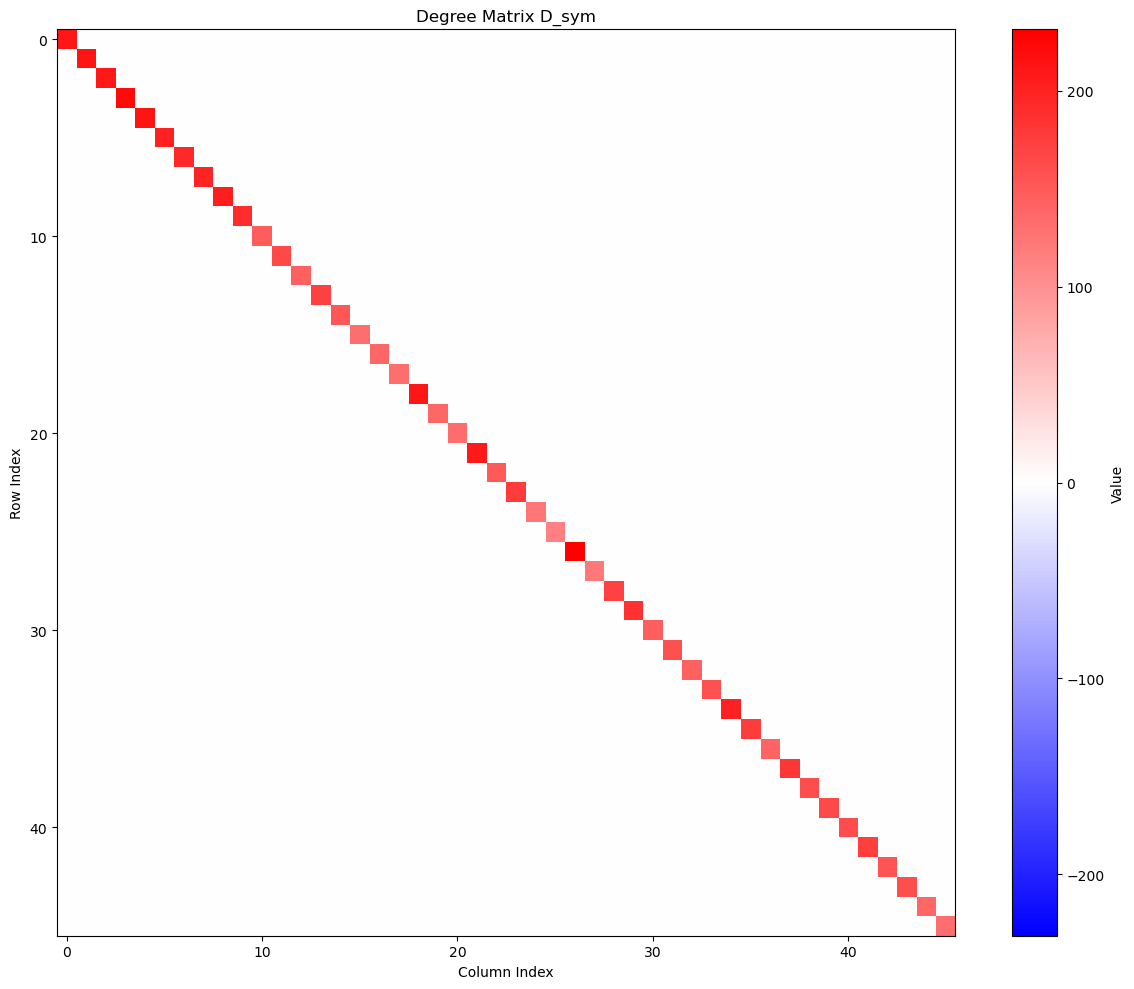

In [27]:
# Visualize the symmetrized degree
# Plot D_sym
plt.figure(figsize=(12, 10))
plt.imshow(D_sym, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(D_sym)), 
           vmax=np.max(np.abs(D_sym)), 
           interpolation='none')
plt.colorbar(label='Value')
plt.title('Degree Matrix D_sym')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

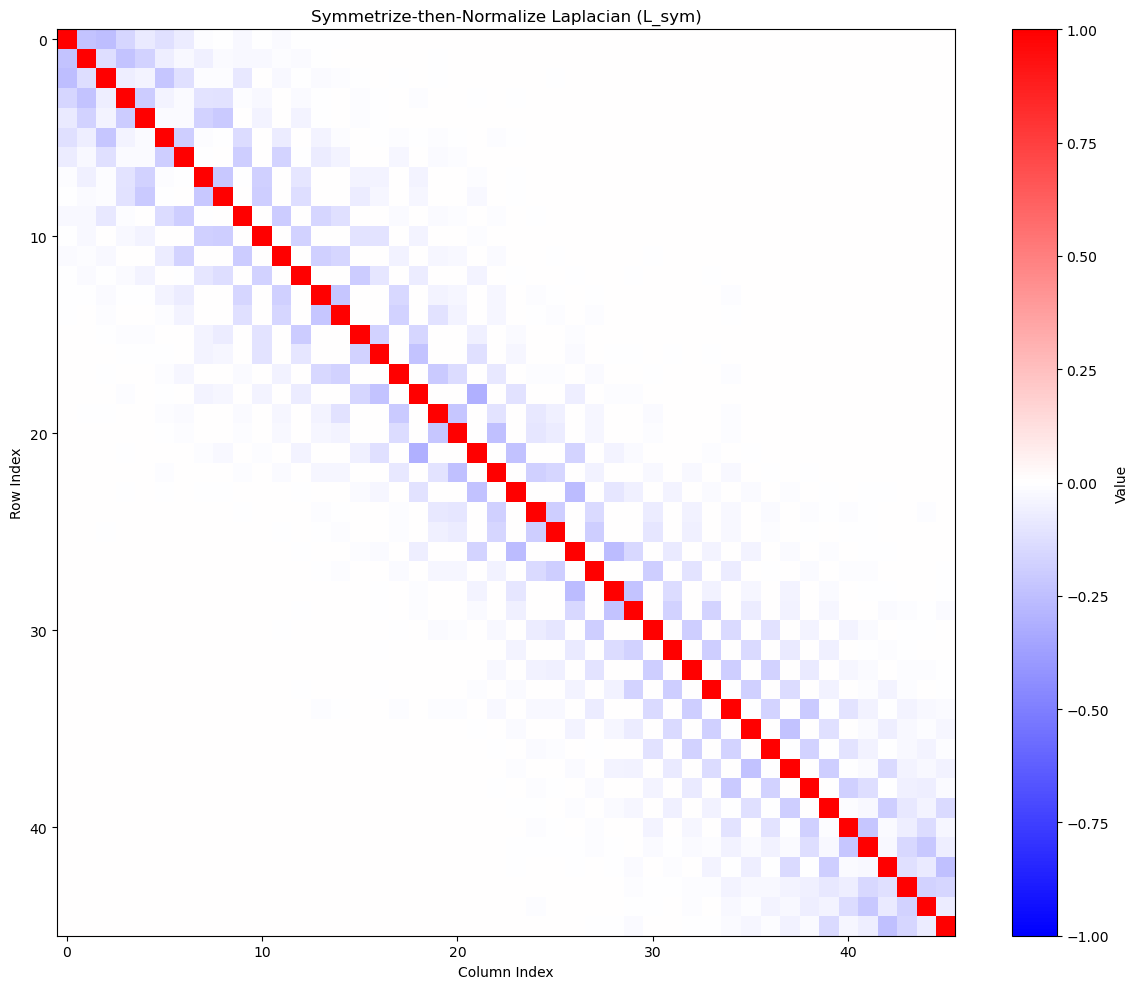

In [28]:
# Visualize the symmetrize-then-normalize Laplacian
plt.figure(figsize=(12, 10))
plt.imshow(L_sym, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(L_sym)), 
           vmax=np.max(np.abs(L_sym)), 
           interpolation='none')
plt.colorbar(label='Value')
plt.title('Symmetrize-then-Normalize Laplacian (L_sym)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.tight_layout()
plt.show()

##### Balanced symmetrization

Default is row-stochastic (forward).

In [29]:
# Compute L_bal: the direct symmetrization of L_out
# L_bal = D_out^(-1/2) * (D_out - 1/2(A + A^T)) * D_out^(-1/2)

try:
    # First, compute the symmetrized adjacency matrix
    A_sym = (A + A.T) / 2

    # Compute D_out^(-1/2)
    D_out_inv_sqrt = np.linalg.inv(np.sqrt(D_out))

    # Compute L_bal
    L_bal = D_out_inv_sqrt @ (D_out - A_sym) @ D_out_inv_sqrt

    print(f"L_bal shape: {L_bal.shape}")

    # Verify symmetry of L_bal
    symmetry_error = np.max(np.abs(L_bal - L_bal.T))
    print(f"L_bal symmetry error (should be ~0): {symmetry_error:.2e}")

    # Verify properties
    row_sums_L_bal = np.sum(L_bal, axis=1)
    print(f"L_bal row sums (should be ~0): max abs = {np.abs(row_sums_L_bal).max():.2e}")

    # Show some statistics
    print(f"\nL_bal statistics:")
    print(f"  Min: {L_bal.min():.4f}")
    print(f"  Max: {L_bal.max():.4f}")
    print(f"  Mean: {L_bal.mean():.4f}")
    print(f"  Std: {L_bal.std():.4f}")
except Exception as e:
    print("Error computing L_bal:", e)

L_bal shape: (46, 46)
L_bal symmetry error (should be ~0): 5.55e-17
L_bal row sums (should be ~0): max abs = 1.79e-01

L_bal statistics:
  Min: -0.2894
  Max: 1.0000
  Mean: -0.0001
  Std: 0.1578


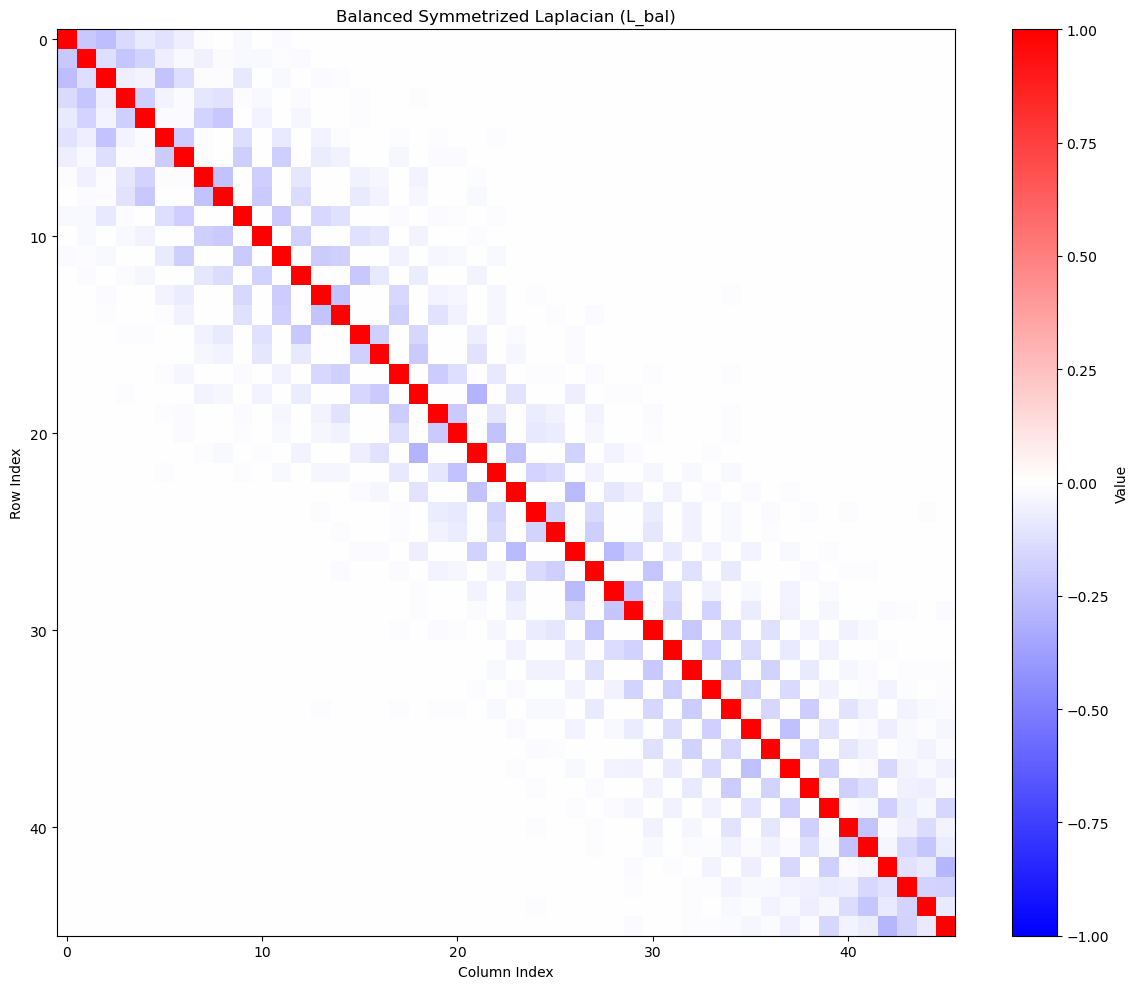

In [30]:
if 'L_bal' in locals():
    # Visualize L_bal
    plt.figure(figsize=(12, 10))
    plt.imshow(L_bal, cmap='bwr', aspect='auto', 
            vmin=-np.max(np.abs(L_bal)), 
            vmax=np.max(np.abs(L_bal)), 
            interpolation='none')
    plt.colorbar(label='Value')
    plt.title('Balanced Symmetrized Laplacian (L_bal)')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.tight_layout()
    plt.show()

In [31]:
# Workspace checkpoint
variables_to_keep = ['ctoi_grouped', 'noi_grouped',
                     'C_signed_grouped', 'C_unsigned_grouped',
                     'new_order', 'unique_cell_types', 'cell_type_counts',
                     'A_sym', 'D_sym', 'D_in', 'D_out', 'L_sym', 'L_bal', 'L_in', 'L_out', 'L_rw']
print("Variables to keep for further analysis:")
for var in variables_to_keep:
    if var in globals():
        var_obj = globals()[var]
        var_type = type(var_obj).__name__
        
        if hasattr(var_obj, 'shape'):
            structure = f"shape: {var_obj.shape}"
        elif hasattr(var_obj, '__len__'):
            structure = f"length: {len(var_obj)}"
        else:
            structure = "scalar"
            
        print(f"\t{var}: {var_type}, {structure}")
    else:
        print(f"\t{var}: NOT FOUND")

Variables to keep for further analysis:
	ctoi_grouped: list, length: 46
	noi_grouped: list, length: 46
	C_signed_grouped: ndarray, shape: (46, 46)
	C_unsigned_grouped: ndarray, shape: (46, 46)
	new_order: list, length: 46
	unique_cell_types: list, length: 1
	cell_type_counts: dict, length: 1
	A_sym: ndarray, shape: (46, 46)
	D_sym: ndarray, shape: (46, 46)
	D_in: ndarray, shape: (46, 46)
	D_out: ndarray, shape: (46, 46)
	L_sym: ndarray, shape: (46, 46)
	L_bal: ndarray, shape: (46, 46)
	L_in: ndarray, shape: (46, 46)
	L_out: ndarray, shape: (46, 46)
	L_rw: ndarray, shape: (46, 46)


#### Laplacian spectrum

##### Eigenspectrum of L_out

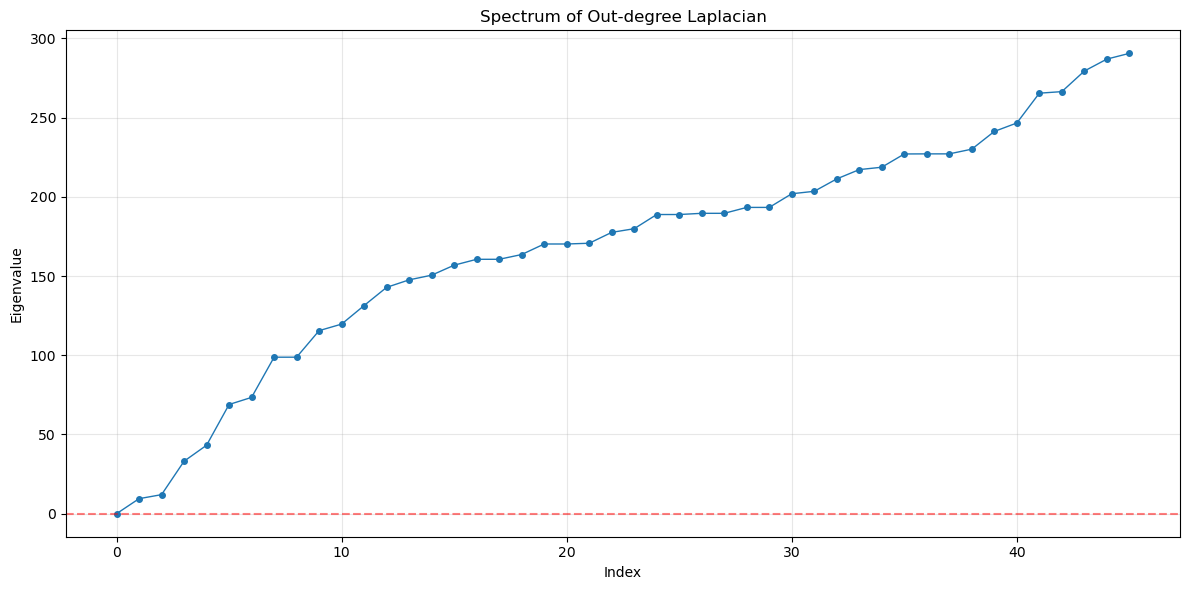

Eigenvalue statistics:
  Min: -0.0000
  Max: 290.5346
  Mean: 168.2391
  Number of zero eigenvalues (< 1e-10): 1
  Number of positive eigenvalues: 45
  Number of negative eigenvalues: 0


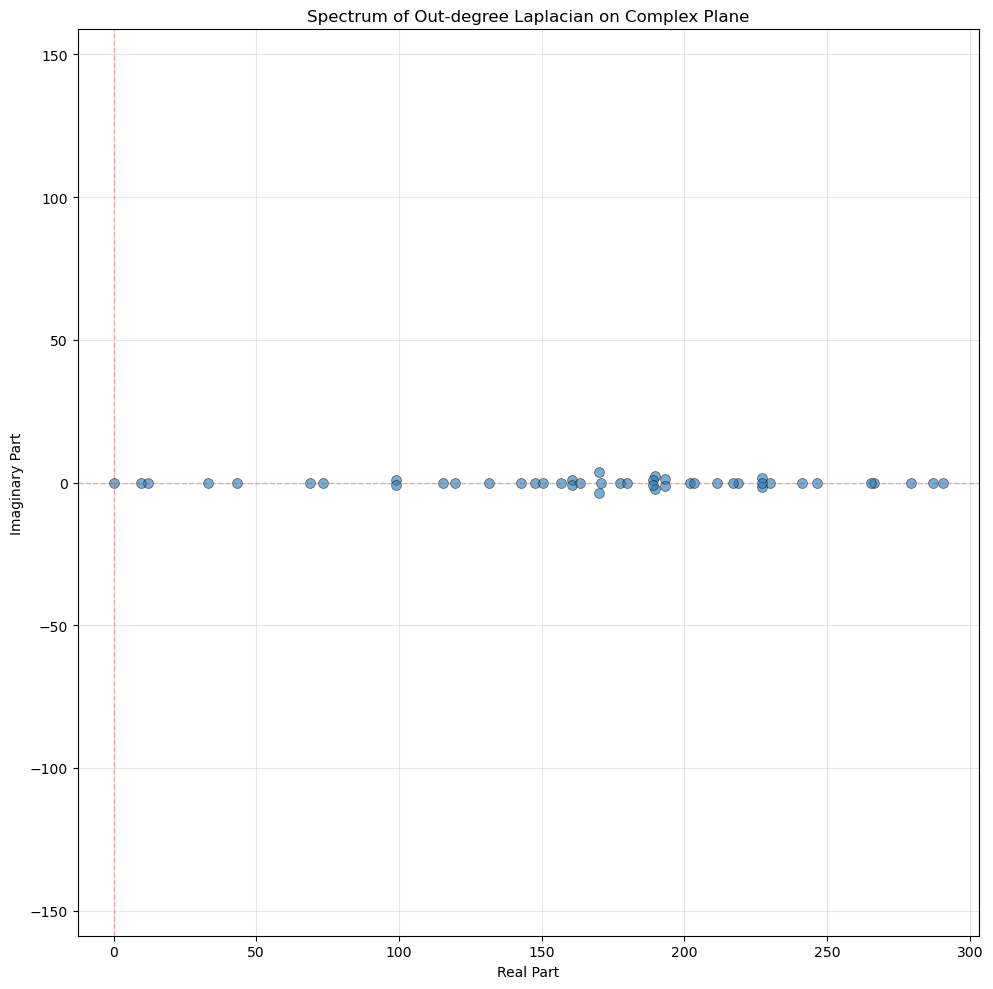

Eigenvalue statistics:
  Number of eigenvalues: 46
  Real part range: [-0.0000, 290.5346]
  Imaginary part range: [-3.7432, 3.7432]
  Number of purely real eigenvalues (|Im| < 1e-10): 32
  Number of complex eigenvalues: 14
  Number of zero eigenvalues (|λ| < 1e-10): 1


In [32]:
L = L_out

# Compute the eigenvalues of L
eigenvalues_L = np.linalg.eigvals(L)

# Sort eigenvalues in ascending order
eigenvalues_L_sorted = np.sort(eigenvalues_L.real)

# Plot the spectrum
plt.figure(figsize=(12, 6))
plt.plot(eigenvalues_L_sorted, 'o-', markersize=4, linewidth=1)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Spectrum of Out-degree Laplacian')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics about the eigenvalues
print(f"Eigenvalue statistics:")
print(f"  Min: {eigenvalues_L_sorted.min():.4f}")
print(f"  Max: {eigenvalues_L_sorted.max():.4f}")
print(f"  Mean: {eigenvalues_L_sorted.mean():.4f}")
print(f"  Number of zero eigenvalues (< 1e-10): {np.sum(np.abs(eigenvalues_L_sorted) < 1e-10)}")
print(f"  Number of positive eigenvalues: {np.sum(eigenvalues_L_sorted > 1e-10)}")
print(f"  Number of negative eigenvalues: {np.sum(eigenvalues_L_sorted < -1e-10)}")

# Plot eigenvalues on the complex plane
plt.figure(figsize=(10, 10))
plt.scatter(eigenvalues_L.real, eigenvalues_L.imag, 
           s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Spectrum of Out-degree Laplacian on Complex Plane')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print statistics about the eigenvalues
print(f"Eigenvalue statistics:")
print(f"  Number of eigenvalues: {len(eigenvalues_L)}")
print(f"  Real part range: [{eigenvalues_L.real.min():.4f}, {eigenvalues_L.real.max():.4f}]")
print(f"  Imaginary part range: [{eigenvalues_L.imag.min():.4f}, {eigenvalues_L.imag.max():.4f}]")
print(f"  Number of purely real eigenvalues (|Im| < 1e-10): {np.sum(np.abs(eigenvalues_L.imag) < 1e-10)}")
print(f"  Number of complex eigenvalues: {np.sum(np.abs(eigenvalues_L.imag) >= 1e-10)}")
print(f"  Number of zero eigenvalues (|λ| < 1e-10): {np.sum(np.abs(eigenvalues_L) < 1e-10)}")


##### Eigenspectrum of L_rw

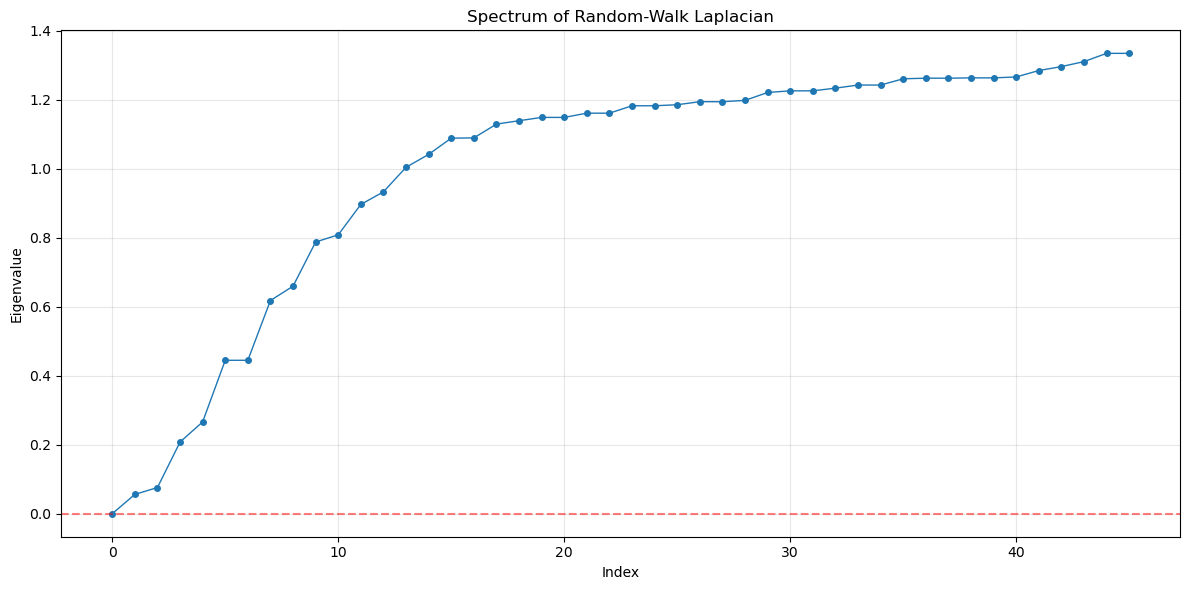

Eigenvalue statistics:
  Min: -0.0000
  Max: 1.3351
  Mean: 1.0000
  Number of zero eigenvalues (< 1e-10): 1
  Number of positive eigenvalues: 45
  Number of negative eigenvalues: 0


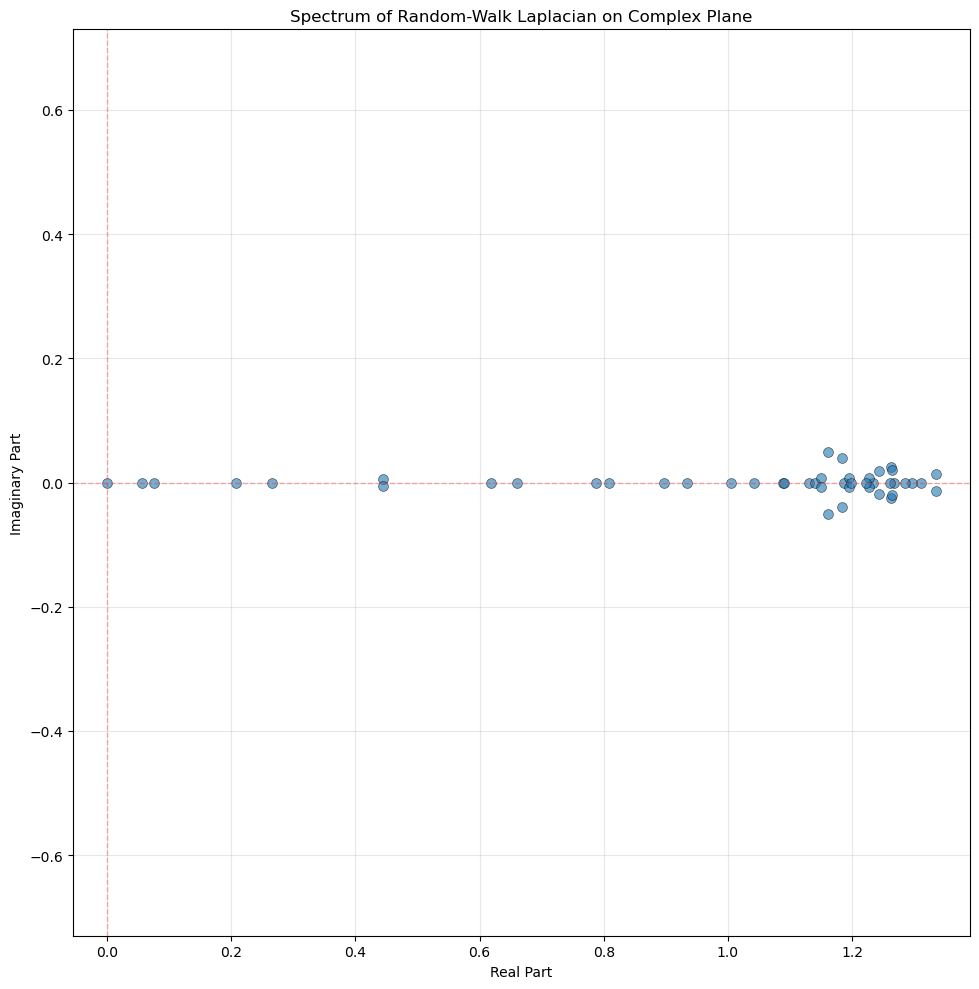

Eigenvalue statistics:
  Number of eigenvalues: 46
  Real part range: [-0.0000, 1.3351]
  Imaginary part range: [-0.0499, 0.0499]
  Number of purely real eigenvalues (|Im| < 1e-10): 26
  Number of complex eigenvalues: 20
  Number of zero eigenvalues (|λ| < 1e-10): 1


In [33]:
if 'L_rw' in locals():
    L = L_rw

    # Compute the eigenvalues of L
    eigenvalues_L = np.linalg.eigvals(L)

    # Sort eigenvalues in ascending order
    eigenvalues_L_sorted = np.sort(eigenvalues_L.real)

    # Plot the spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(eigenvalues_L_sorted, 'o-', markersize=4, linewidth=1)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.title('Spectrum of Random-Walk Laplacian')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print statistics about the eigenvalues
    print(f"Eigenvalue statistics:")
    print(f"  Min: {eigenvalues_L_sorted.min():.4f}")
    print(f"  Max: {eigenvalues_L_sorted.max():.4f}")
    print(f"  Mean: {eigenvalues_L_sorted.mean():.4f}")
    print(f"  Number of zero eigenvalues (< 1e-10): {np.sum(np.abs(eigenvalues_L_sorted) < 1e-10)}")
    print(f"  Number of positive eigenvalues: {np.sum(eigenvalues_L_sorted > 1e-10)}")
    print(f"  Number of negative eigenvalues: {np.sum(eigenvalues_L_sorted < -1e-10)}")

    # Plot eigenvalues on the complex plane
    plt.figure(figsize=(10, 10))
    plt.scatter(eigenvalues_L.real, eigenvalues_L.imag, 
            s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Spectrum of Random-Walk Laplacian on Complex Plane')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Print statistics about the eigenvalues
    print(f"Eigenvalue statistics:")
    print(f"  Number of eigenvalues: {len(eigenvalues_L)}")
    print(f"  Real part range: [{eigenvalues_L.real.min():.4f}, {eigenvalues_L.real.max():.4f}]")
    print(f"  Imaginary part range: [{eigenvalues_L.imag.min():.4f}, {eigenvalues_L.imag.max():.4f}]")
    print(f"  Number of purely real eigenvalues (|Im| < 1e-10): {np.sum(np.abs(eigenvalues_L.imag) < 1e-10)}")
    print(f"  Number of complex eigenvalues: {np.sum(np.abs(eigenvalues_L.imag) >= 1e-10)}")
    print(f"  Number of zero eigenvalues (|λ| < 1e-10): {np.sum(np.abs(eigenvalues_L) < 1e-10)}")


##### Eigenspectrum of L_sym

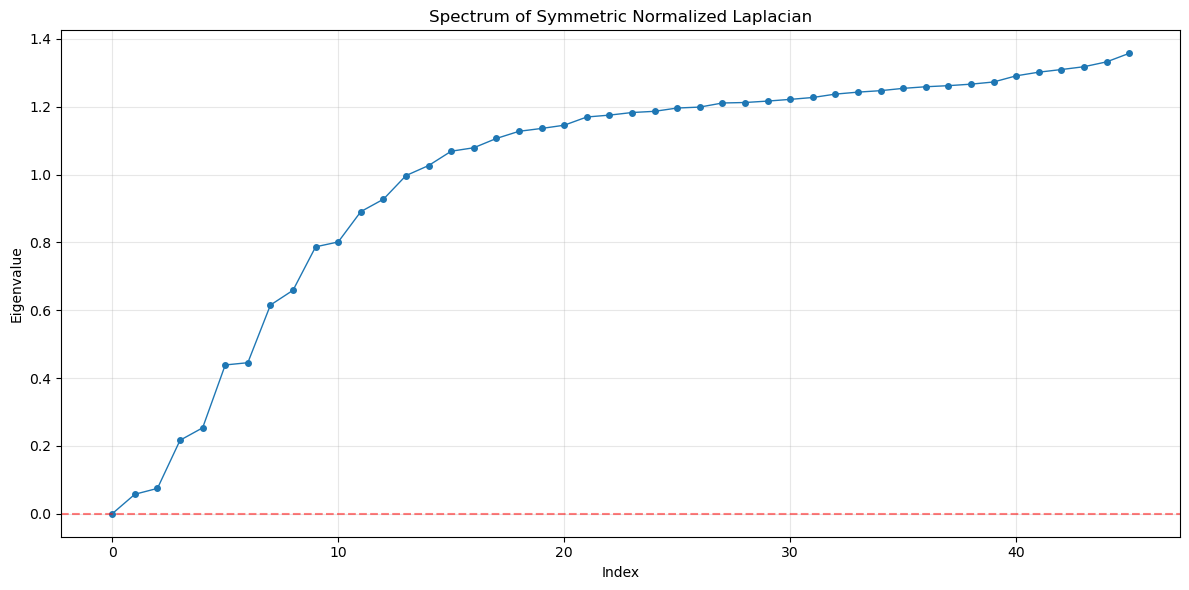

Eigenvalue statistics:
  Min: 0.0000
  Max: 1.3573
  Mean: 1.0000
  Number of zero eigenvalues (< 1e-10): 1
  Number of positive eigenvalues: 45
  Number of negative eigenvalues: 0


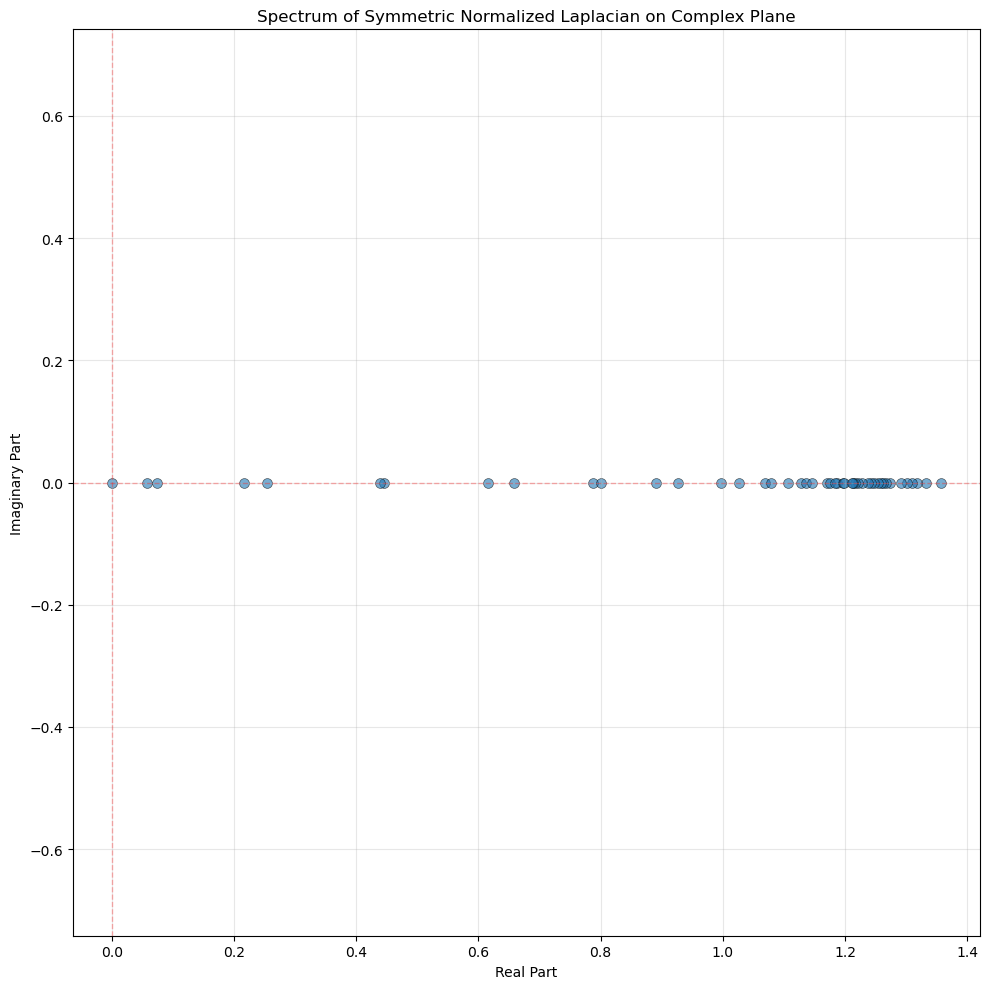

Eigenvalue statistics:
  Number of eigenvalues: 46
  Real part range: [0.0000, 1.3573]
  Imaginary part range: [0.0000, 0.0000]
  Number of purely real eigenvalues (|Im| < 1e-10): 46
  Number of complex eigenvalues: 0
  Number of zero eigenvalues (|λ| < 1e-10): 1


In [34]:
L = L_sym

# Compute the eigenvalues of L
eigenvalues_L = np.linalg.eigvals(L)

# Sort eigenvalues in ascending order
eigenvalues_L_sorted = np.sort(eigenvalues_L.real)

# Plot the spectrum
plt.figure(figsize=(12, 6))
plt.plot(eigenvalues_L_sorted, 'o-', markersize=4, linewidth=1)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Spectrum of Symmetric Normalized Laplacian')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics about the eigenvalues
print(f"Eigenvalue statistics:")
print(f"  Min: {eigenvalues_L_sorted.min():.4f}")
print(f"  Max: {eigenvalues_L_sorted.max():.4f}")
print(f"  Mean: {eigenvalues_L_sorted.mean():.4f}")
print(f"  Number of zero eigenvalues (< 1e-10): {np.sum(np.abs(eigenvalues_L_sorted) < 1e-10)}")
print(f"  Number of positive eigenvalues: {np.sum(eigenvalues_L_sorted > 1e-10)}")
print(f"  Number of negative eigenvalues: {np.sum(eigenvalues_L_sorted < -1e-10)}")

# Plot eigenvalues on the complex plane
plt.figure(figsize=(10, 10))
plt.scatter(eigenvalues_L.real, eigenvalues_L.imag, 
           s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Spectrum of Symmetric Normalized Laplacian on Complex Plane')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print statistics about the eigenvalues
print(f"Eigenvalue statistics:")
print(f"  Number of eigenvalues: {len(eigenvalues_L)}")
print(f"  Real part range: [{eigenvalues_L.real.min():.4f}, {eigenvalues_L.real.max():.4f}]")
print(f"  Imaginary part range: [{eigenvalues_L.imag.min():.4f}, {eigenvalues_L.imag.max():.4f}]")
print(f"  Number of purely real eigenvalues (|Im| < 1e-10): {np.sum(np.abs(eigenvalues_L.imag) < 1e-10)}")
print(f"  Number of complex eigenvalues: {np.sum(np.abs(eigenvalues_L.imag) >= 1e-10)}")
print(f"  Number of zero eigenvalues (|λ| < 1e-10): {np.sum(np.abs(eigenvalues_L) < 1e-10)}")


##### Eigenspectrum of L_bal

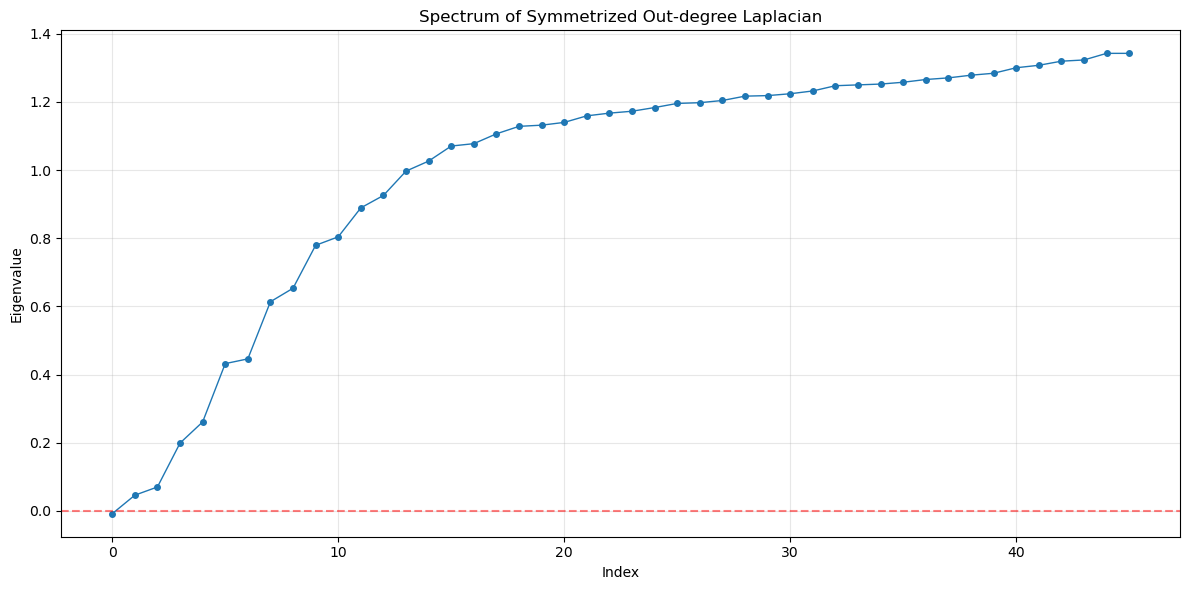

Eigenvalue statistics:
  Min: -0.0082
  Max: 1.3424
  Mean: 1.0000
  Number of zero eigenvalues (< 1e-10): 0
  Number of positive eigenvalues: 45
  Number of negative eigenvalues: 1


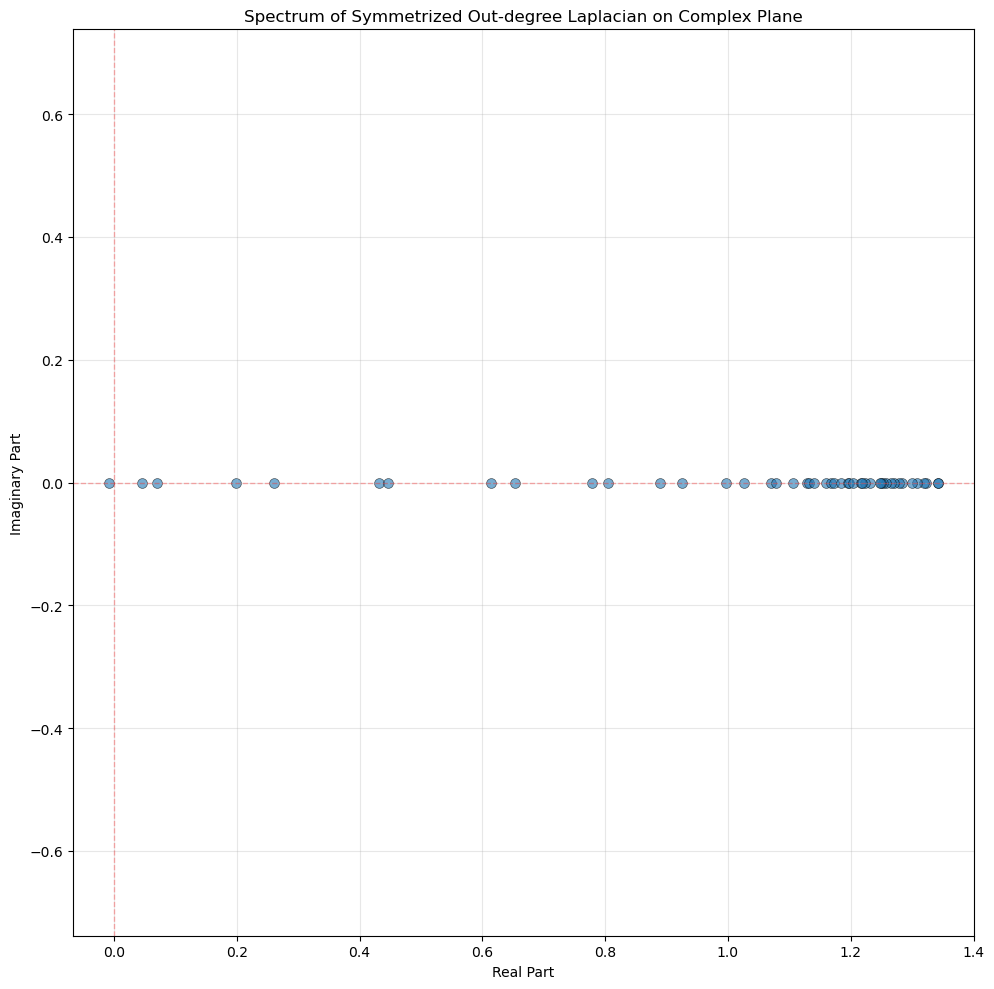

Eigenvalue statistics:
  Number of eigenvalues: 46
  Real part range: [-0.0082, 1.3424]
  Imaginary part range: [0.0000, 0.0000]
  Number of purely real eigenvalues (|Im| < 1e-10): 46
  Number of complex eigenvalues: 0
  Number of zero eigenvalues (|λ| < 1e-10): 0


In [35]:
if 'L_bal' in locals():
    L = L_bal

    # Compute the eigenvalues of L
    eigenvalues_L = np.linalg.eigvals(L)

    # Sort eigenvalues in ascending order
    eigenvalues_L_sorted = np.sort(eigenvalues_L.real)

    # Plot the spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(eigenvalues_L_sorted, 'o-', markersize=4, linewidth=1)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    plt.title('Spectrum of Symmetrized Out-degree Laplacian')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print statistics about the eigenvalues
    print(f"Eigenvalue statistics:")
    print(f"  Min: {eigenvalues_L_sorted.min():.4f}")
    print(f"  Max: {eigenvalues_L_sorted.max():.4f}")
    print(f"  Mean: {eigenvalues_L_sorted.mean():.4f}")
    print(f"  Number of zero eigenvalues (< 1e-10): {np.sum(np.abs(eigenvalues_L_sorted) < 1e-10)}")
    print(f"  Number of positive eigenvalues: {np.sum(eigenvalues_L_sorted > 1e-10)}")
    print(f"  Number of negative eigenvalues: {np.sum(eigenvalues_L_sorted < -1e-10)}")

    # Plot eigenvalues on the complex plane
    plt.figure(figsize=(10, 10))
    plt.scatter(eigenvalues_L.real, eigenvalues_L.imag, 
            s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Spectrum of Symmetrized Out-degree Laplacian on Complex Plane')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Print statistics about the eigenvalues
    print(f"Eigenvalue statistics:")
    print(f"  Number of eigenvalues: {len(eigenvalues_L)}")
    print(f"  Real part range: [{eigenvalues_L.real.min():.4f}, {eigenvalues_L.real.max():.4f}]")
    print(f"  Imaginary part range: [{eigenvalues_L.imag.min():.4f}, {eigenvalues_L.imag.max():.4f}]")
    print(f"  Number of purely real eigenvalues (|Im| < 1e-10): {np.sum(np.abs(eigenvalues_L.imag) < 1e-10)}")
    print(f"  Number of complex eigenvalues: {np.sum(np.abs(eigenvalues_L.imag) >= 1e-10)}")
    print(f"  Number of zero eigenvalues (|λ| < 1e-10): {np.sum(np.abs(eigenvalues_L) < 1e-10)}")


### Checkpoint

In [36]:
variables_to_keep = ['ctoi_grouped', 'noi_grouped', 'C_signed_grouped', 'C_unsigned_grouped', 'new_order', 'unique_cell_types', 'cell_type_counts',
                     'D_out', 'D_in', 'L_out', 'L_in', 'L_rw', 'A_sym', 'D_sym', 'L_sym', 'L_bal']
print("Variables to keep for further analysis:")
for var in variables_to_keep:
    if var in globals():
        var_obj = globals()[var]
        var_type = type(var_obj).__name__
        
        if hasattr(var_obj, 'shape'):
            structure = f"shape: {var_obj.shape}"
        elif hasattr(var_obj, '__len__'):
            structure = f"length: {len(var_obj)}"
        else:
            structure = "scalar"
            
        print(f"\t{var}: {var_type}, {structure}")
    else:
        print(f"\t{var}: NOT FOUND")

Variables to keep for further analysis:
	ctoi_grouped: list, length: 46
	noi_grouped: list, length: 46
	C_signed_grouped: ndarray, shape: (46, 46)
	C_unsigned_grouped: ndarray, shape: (46, 46)
	new_order: list, length: 46
	unique_cell_types: list, length: 1
	cell_type_counts: dict, length: 1
	D_out: ndarray, shape: (46, 46)
	D_in: ndarray, shape: (46, 46)
	L_out: ndarray, shape: (46, 46)
	L_in: ndarray, shape: (46, 46)
	L_rw: ndarray, shape: (46, 46)
	A_sym: ndarray, shape: (46, 46)
	D_sym: ndarray, shape: (46, 46)
	L_sym: ndarray, shape: (46, 46)
	L_bal: ndarray, shape: (46, 46)


### Renormalization group

We will consider the adjacency $A$ to be directly linked to the network's continuous dynamics.

#### Setup and diffusion dynamics

In [37]:
# Handle sinks
zero_out_mask = np.sum(A, axis=1) == 0
A_fixed = A.copy()
A_fixed[zero_out_mask, zero_out_mask] = 1.0

# Consider the row-normalized adjacency as state propagator
# P_hat = D_out^(-1) * A
D_out = np.diag(np.sum(A_fixed, axis=1))
P_hat = np.linalg.inv(D_out) @ A_fixed

# Consider the random walk Laplacian as the diffusion operator
# L_hat = I - P_hat
# or a Markov generator: -L_hat = P_hat - I
L_hat = np.eye(len(A_fixed)) - P_hat

K_hat shape: (46, 46)
K_hat computed as exp(-5 * L_hat)

K_hat statistics:
  Min: 0.000231
  Max: 0.104873
  Mean: 0.021739

K_hat symmetry error: 4.30e-02
K_hat row sums: min=1.000000, max=1.000000


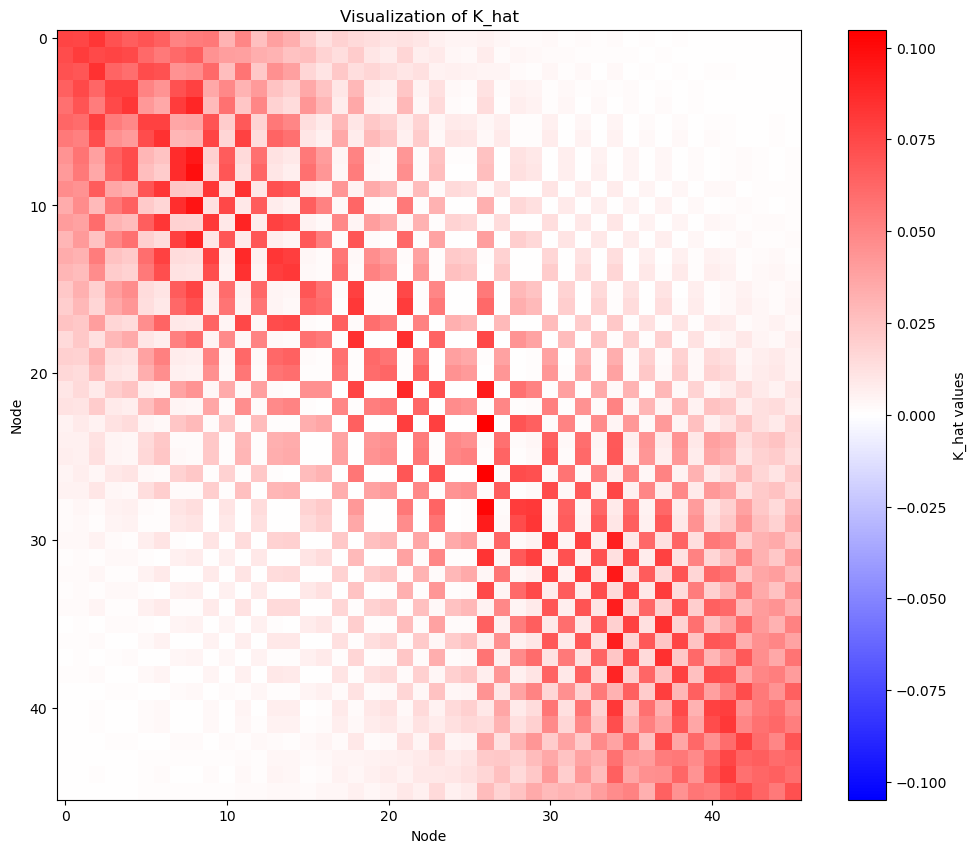

In [38]:
# Compute the diffusion matrix exponential K_hat = exp(-tau * L_hat)
tau = 5
K_hat = la.expm(-tau * L_hat)

print(f"K_hat shape: {K_hat.shape}")
print(f"K_hat computed as exp(-{tau} * L_hat)")

# Verify properties
print(f"\nK_hat statistics:")
print(f"  Min: {K_hat.min():.6f}")
print(f"  Max: {K_hat.max():.6f}")
print(f"  Mean: {K_hat.mean():.6f}")

# Check if K_hat is symmetric (should be for symmetric Laplacian)
symmetry_error_K = np.max(np.abs(K_hat - K_hat.T))
print(f"\nK_hat symmetry error: {symmetry_error_K:.2e}")

# Check row sums (for diffusion kernel, should decay with tau)
row_sums_K = np.sum(K_hat, axis=1)
print(f"K_hat row sums: min={row_sums_K.min():.6f}, max={row_sums_K.max():.6f}")

# Visualize K_hat
plt.figure(figsize=(12, 10))
plt.imshow(K_hat, aspect='auto', cmap='bwr', vmin=-np.max(np.abs(K_hat)), vmax=np.max(np.abs(K_hat)), interpolation='none')
plt.colorbar(label='K_hat values')
plt.title('Visualization of K_hat')
plt.xlabel('Node')
plt.ylabel('Node')
plt.show()

rho_hat shape: (46, 46)
rho_hat statistics: min=0.013981, max=0.029964, mean=0.021739


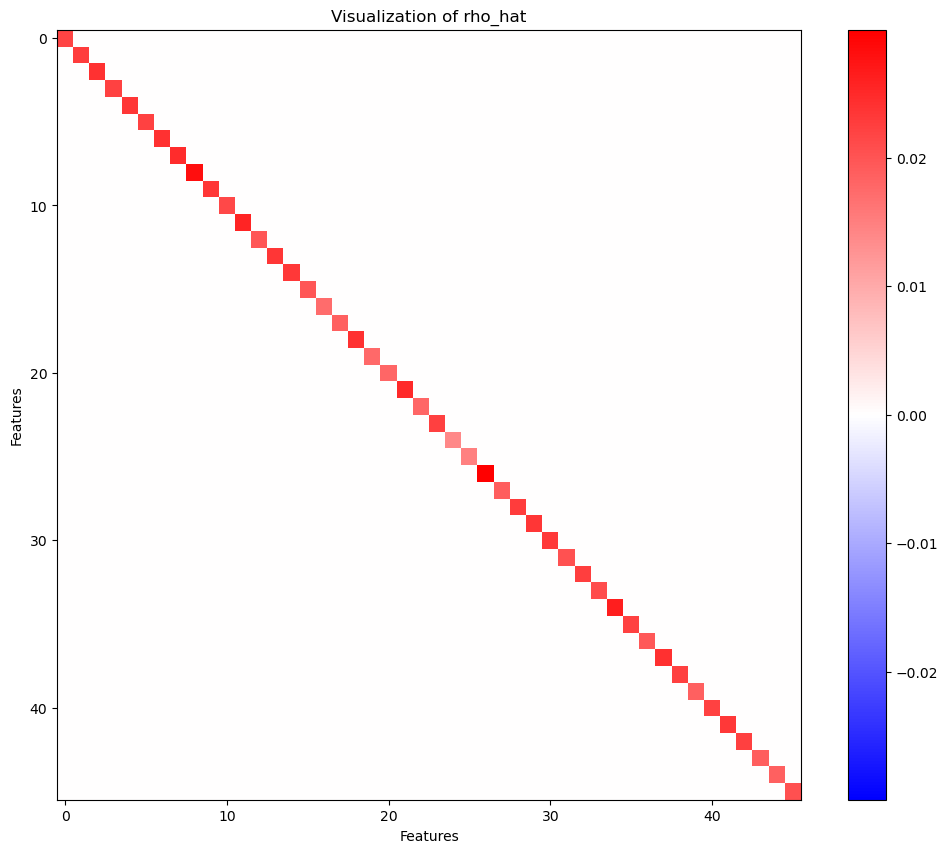

In [39]:
# Compute the canonical density operator rho_hat
rho_hat_diag = np.diag(K_hat) / np.trace(K_hat)
rho_hat = np.diag(rho_hat_diag)

print(f"rho_hat shape: {rho_hat.shape}")
print(f"rho_hat statistics: min={rho_hat_diag.min():.6f}, max={rho_hat_diag.max():.6f}, mean={rho_hat_diag.mean():.6f}")

# Visualize rho_hat
plt.figure(figsize=(12, 10))
plt.imshow(rho_hat, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(rho_hat)), 
           vmax=np.max(np.abs(rho_hat)), 
           interpolation='none')
plt.colorbar()
plt.title("Visualization of rho_hat")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

In [40]:
# Compute the system entropy S
# S = -1/log(N) * \sum_{i=1}^{N} \mu_i(\tau) * log(\mu_i(\tau))
# where \mu_i(\tau) are the eigenvalues of rho_hat(\tau)
eigenvalues_rho_hat = np.linalg.eigvals(rho_hat)
eigenvalues_rho_hat = eigenvalues_rho_hat.real
N = len(eigenvalues_rho_hat)
S = -1/np.log(N) * np.sum(eigenvalues_rho_hat * np.log(eigenvalues_rho_hat + 1e-12))  # Add small value to avoid log(0)
print(f"System entropy S: {S:.6f}")

System entropy S: 0.997243


#### Eigendecomposition

In [41]:
# Compute eigendecomposition of P_hat (state propagator)
print("Eigendecomposition of P_hat (State Propagator)")
print("=" * 60)

# For non-symmetric matrices, compute both left and right eigenvectors
eigenvalues, eigenvectors_right = np.linalg.eig(P_hat)
eigenvalues_left, eigenvectors_left_T = np.linalg.eig(P_hat.T)
eigenvectors_left = eigenvectors_left_T.T

# Verify that left and right eigenvalues match
eigenvalue_diff = np.max(np.abs(np.sort(eigenvalues.real) - np.sort(eigenvalues_left.real)))
print(f"Max difference between left and right eigenvalues: {eigenvalue_diff:.2e}")

# Sort by eigenvalue
idx_sorted = np.argsort(eigenvalues.real)
eigenvalues_sorted = eigenvalues[idx_sorted]
eigenvectors_right_sorted = eigenvectors_right[:, idx_sorted]
eigenvectors_left_sorted = eigenvectors_left[idx_sorted, :]

print(f"\nComputed {len(eigenvalues_sorted)} eigenvalues")
print(f"Eigenvalue range: [{eigenvalues_sorted.real.min():.6f}, {eigenvalues_sorted.real.max():.6f}]")

# Count zero eigenvalues
n_zero_eigs = np.sum(np.abs(eigenvalues_sorted) < 1e-10)
print(f"Number of zero eigenvalues (|λ| < 1e-10): {n_zero_eigs}")

# Verify bi-orthogonality: <w_i, v_j> should be δ_ij
biorthogonality = eigenvectors_left_sorted @ eigenvectors_right_sorted
off_diag_max = np.max(np.abs(biorthogonality - np.diag(np.diag(biorthogonality))))
print(f"\nBi-orthogonality check - max off-diagonal: {off_diag_max:.2e}")

# Show first few eigenvalues
print(f"\nFirst 10 eigenvalues:")
for i in range(min(10, len(eigenvalues_sorted))):
    print(f"  λ_{i}: {eigenvalues_sorted[i].real:.6f} + {eigenvalues_sorted[i].imag:.6f}i")

Eigendecomposition of P_hat (State Propagator)
Max difference between left and right eigenvalues: 4.33e-15

Computed 46 eigenvalues
Eigenvalue range: [-0.335138, 1.000000]
Number of zero eigenvalues (|λ| < 1e-10): 0

Bi-orthogonality check - max off-diagonal: 5.18e-01

First 10 eigenvalues:
  λ_0: -0.335138 + -0.014074i
  λ_1: -0.335138 + 0.014074i
  λ_2: -0.311175 + 0.000000i
  λ_3: -0.296717 + 0.000000i
  λ_4: -0.285267 + 0.000000i
  λ_5: -0.266625 + 0.000000i
  λ_6: -0.264022 + -0.019561i
  λ_7: -0.264022 + 0.019561i
  λ_8: -0.263104 + -0.025087i
  λ_9: -0.263104 + 0.025087i


/opt/miniconda3/envs/mcp/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/mcp/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


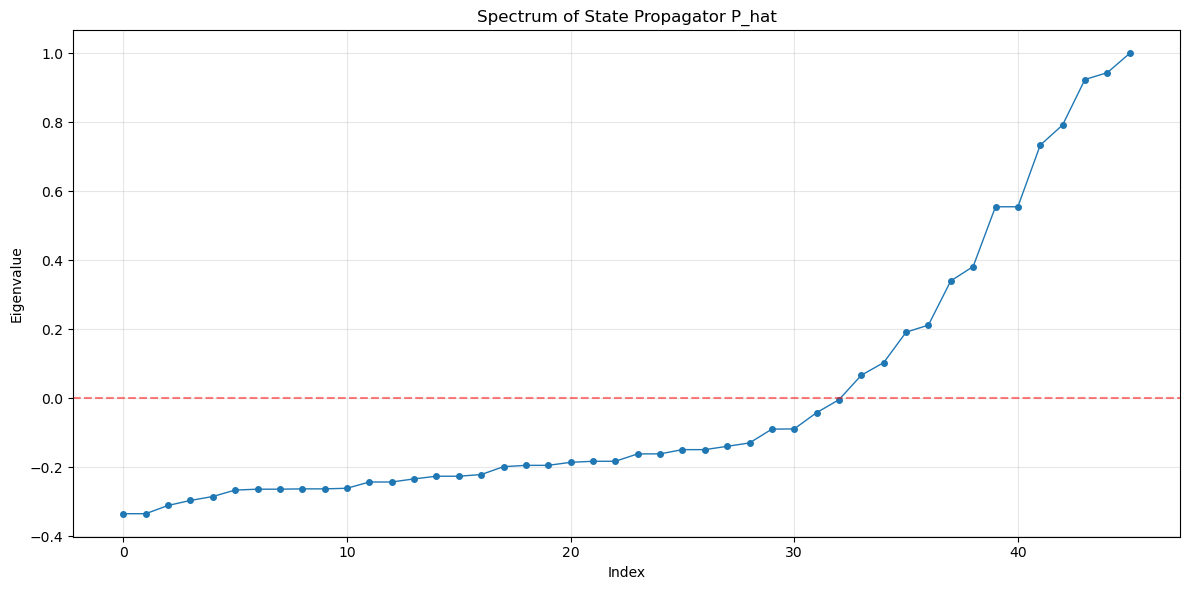

Eigenvalue statistics:
  Min: -0.3351-0.0141j
  Max: 1.0000+0.0000j
  Mean: 0.0000+0.0000j
  Number of zero eigenvalues (< 1e-10): 0
  Number of positive eigenvalues: 13
  Number of negative eigenvalues: 33


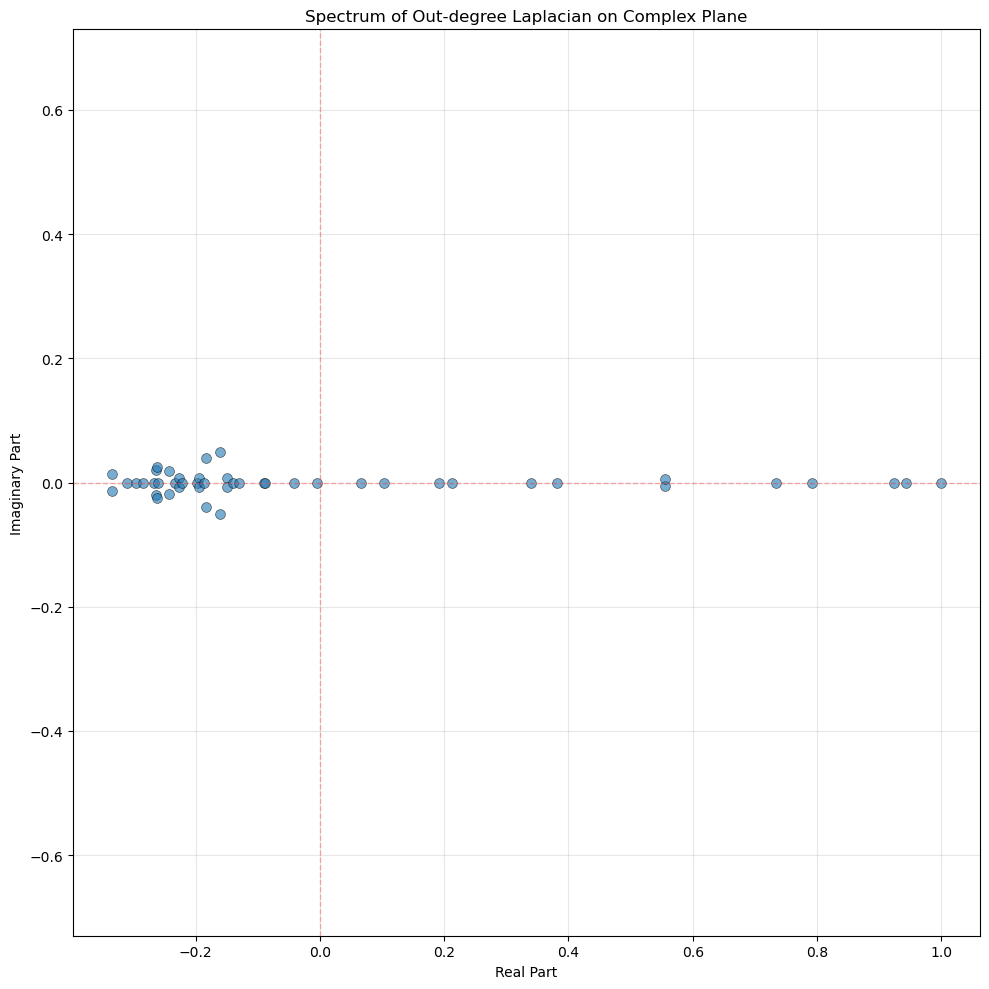

In [42]:
# Plot the spectrum
plt.figure(figsize=(12, 6))
plt.plot(eigenvalues_sorted, 'o-', markersize=4, linewidth=1)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Spectrum of State Propagator P_hat')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics about the eigenvalues
print(f"Eigenvalue statistics:")
print(f"  Min: {eigenvalues_sorted.min():.4f}")
print(f"  Max: {eigenvalues_sorted.max():.4f}")
print(f"  Mean: {eigenvalues_sorted.mean():.4f}")
print(f"  Number of zero eigenvalues (< 1e-10): {np.sum(np.abs(eigenvalues_sorted) < 1e-10)}")
print(f"  Number of positive eigenvalues: {np.sum(eigenvalues_sorted > 1e-10)}")
print(f"  Number of negative eigenvalues: {np.sum(eigenvalues_sorted < -1e-10)}")

# Plot eigenvalues on the complex plane
plt.figure(figsize=(10, 10))
plt.scatter(eigenvalues_sorted.real, eigenvalues_sorted.imag, 
           s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Spectrum of Out-degree Laplacian on Complex Plane')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [43]:
# Compute eigendecomposition of L_hat (Random Walk Laplacian)
print("Eigendecomposition of L_hat (Random Walk Laplacian)")
print("=" * 60)

# For non-symmetric matrices, compute both left and right eigenvectors
eigenvalues, eigenvectors_right = np.linalg.eig(L_hat)
eigenvalues_left, eigenvectors_left_T = np.linalg.eig(L_hat.T)
eigenvectors_left = eigenvectors_left_T.T

# Verify that left and right eigenvalues match
eigenvalue_diff = np.max(np.abs(np.sort(eigenvalues.real) - np.sort(eigenvalues_left.real)))
print(f"Max difference between left and right eigenvalues: {eigenvalue_diff:.2e}")

# Sort by eigenvalue
idx_sorted = np.argsort(eigenvalues.real)
eigenvalues_sorted = eigenvalues[idx_sorted]
eigenvectors_right_sorted = eigenvectors_right[:, idx_sorted]
eigenvectors_left_sorted = eigenvectors_left[idx_sorted, :]

print(f"\nComputed {len(eigenvalues_sorted)} eigenvalues")
print(f"Eigenvalue range: [{eigenvalues_sorted.real.min():.6f}, {eigenvalues_sorted.real.max():.6f}]")

# Count zero eigenvalues
n_zero_eigs = np.sum(np.abs(eigenvalues_sorted) < 1e-10)
print(f"Number of zero eigenvalues (|λ| < 1e-10): {n_zero_eigs}")

# Verify bi-orthogonality: <w_i, v_j> should be δ_ij
biorthogonality = eigenvectors_left_sorted @ eigenvectors_right_sorted
off_diag_max = np.max(np.abs(biorthogonality - np.diag(np.diag(biorthogonality))))
print(f"\nBi-orthogonality check - max off-diagonal: {off_diag_max:.2e}")

# Show first few eigenvalues
print(f"\nFirst 10 eigenvalues:")
for i in range(min(10, len(eigenvalues_sorted))):
    print(f"  λ_{i}: {eigenvalues_sorted[i].real:.6f} + {eigenvalues_sorted[i].imag:.6f}i")

Eigendecomposition of L_hat (Random Walk Laplacian)
Max difference between left and right eigenvalues: 6.04e-14

Computed 46 eigenvalues
Eigenvalue range: [-0.000000, 1.335138]
Number of zero eigenvalues (|λ| < 1e-10): 1

Bi-orthogonality check - max off-diagonal: 9.21e-01

First 10 eigenvalues:
  λ_0: -0.000000 + 0.000000i
  λ_1: 0.055985 + 0.000000i
  λ_2: 0.075859 + 0.000000i
  λ_3: 0.207804 + 0.000000i
  λ_4: 0.266244 + 0.000000i
  λ_5: 0.444936 + 0.005933i
  λ_6: 0.444936 + -0.005933i
  λ_7: 0.618316 + 0.000000i
  λ_8: 0.659857 + 0.000000i
  λ_9: 0.788042 + 0.000000i


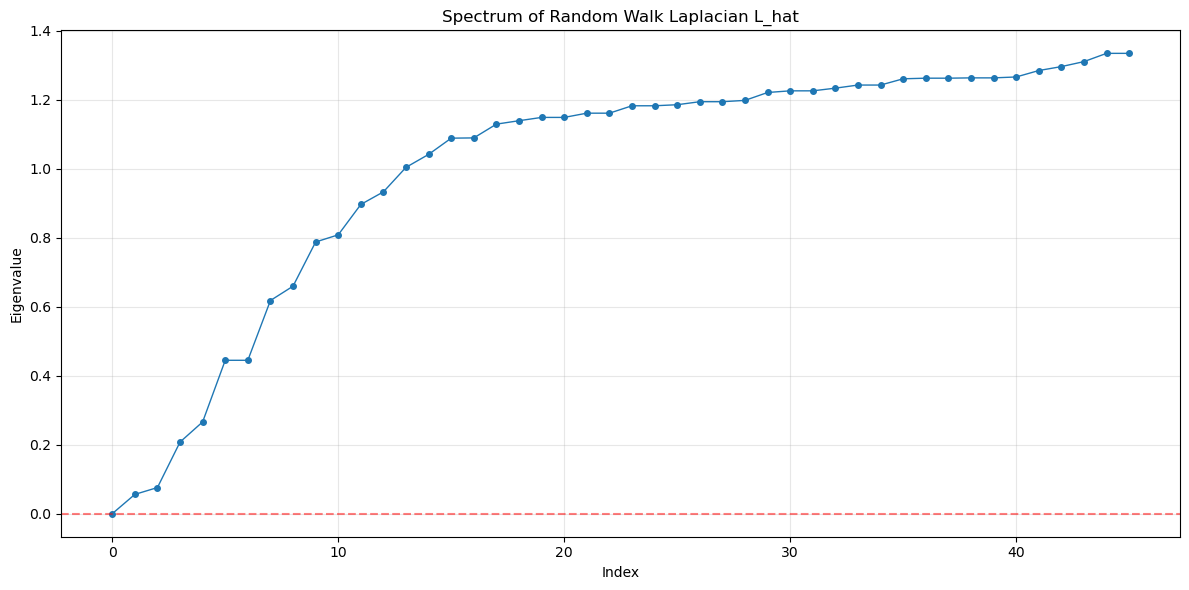

Eigenvalue statistics:
  Min: -0.0000+0.0000j
  Max: 1.3351+0.0141j
  Mean: 1.0000+0.0000j
  Number of zero eigenvalues (< 1e-10): 1
  Number of eigenvalues inside unit circle (|λ| < 1): 13
  Number of eigenvalues outside unit circle (|λ| > 1): 33


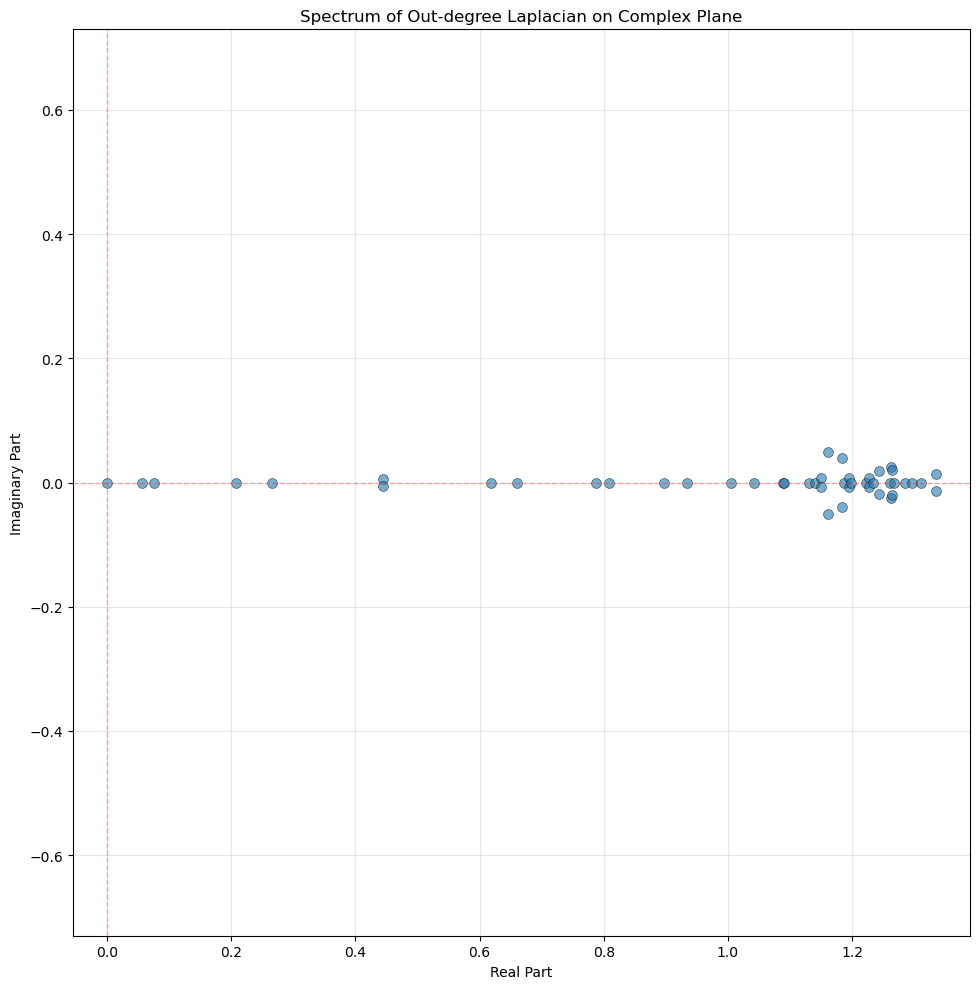

In [44]:
# Plot the spectrum
plt.figure(figsize=(12, 6))
plt.plot(eigenvalues_sorted, 'o-', markersize=4, linewidth=1)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Spectrum of Random Walk Laplacian L_hat')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics about the eigenvalues
print(f"Eigenvalue statistics:")
print(f"  Min: {eigenvalues_sorted.min():.4f}")
print(f"  Max: {eigenvalues_sorted.max():.4f}")
print(f"  Mean: {eigenvalues_sorted.mean():.4f}")
print(f"  Number of zero eigenvalues (< 1e-10): {np.sum(np.abs(eigenvalues_sorted) < 1e-10)}")
print(f"  Number of eigenvalues inside unit circle (|λ| < 1): {np.sum(np.abs(eigenvalues_sorted) < 1)}")
print(f"  Number of eigenvalues outside unit circle (|λ| > 1): {np.sum(np.abs(eigenvalues_sorted) > 1)}")

# Plot eigenvalues on the complex plane
plt.figure(figsize=(10, 10))
plt.scatter(eigenvalues_sorted.real, eigenvalues_sorted.imag, 
           s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Spectrum of Out-degree Laplacian on Complex Plane')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Bi-orthogonal Laplacian Renormalization Group (bi-LRG)

In [100]:
# Bi-LRG parameters
k = 16
alpha = 0.95

In [101]:
# Apply bi-LRG to the connectivity matrix
print(f"Applying bi-LRG with k={k} slow modes...")
print("=" * 50)

# Initialize bi-LRG model
bilrg = BiLRG(k=k, alpha=alpha, cluster_method='kmeans', 
              realify=False, spectral_matrix='L', random_state=42)

# Fit to the unsigned connectivity matrix
A_bilrg = A.copy()
bilrg.fit(A_bilrg)
# bilrg.fit(A_bilrg, L=L_bal)

# Print basic results
print(f"Original network size: {A_bilrg.shape[0]} neurons")
coarse_graph = bilrg.get_coarse_graph()
print(f"Coarse network size: {coarse_graph['n_coarse']} groups")
print(f"Spectral fidelity: {coarse_graph['fidelity']:.4f}")
print(f"Slow eigenvalues: {coarse_graph['eigenvalues'][:5]}")

# Show group assignments
groups = coarse_graph['groups']
print(f"\nGroup assignments:")
for group_id in range(coarse_graph['n_coarse']):
    group_size = np.sum(groups == group_id)
    print(f"Group {group_id}: {group_size} neurons")

# Analyze group composition by cell type
print(f"\nGroup composition by cell type:")
for group_id in range(coarse_graph['n_coarse']):
    group_mask = groups == group_id
    group_cell_types = [ctoi_grouped[i] for i in range(len(ctoi_grouped)) if group_mask[i]]
    cell_type_counts_group = {ct: group_cell_types.count(ct) for ct in set(group_cell_types)}
    if cell_type_counts_group:  # Only show non-empty groups
        print(f"Group {group_id}: {dict(sorted(cell_type_counts_group.items()))}")

Applying bi-LRG with k=16 slow modes...
Original network size: 46 neurons
Coarse network size: 16 groups
Spectral fidelity: 2.2939
Slow eigenvalues: [9.32295383e-17+2.93424664e-19j 1.03185686e-01-1.99008023e-18j
 1.22065962e-01+1.79922812e-18j 2.47413447e-01+5.69358577e-18j
 3.02932006e-01-1.03607058e-17j]

Group assignments:
Group 0: 1 neurons
Group 1: 4 neurons
Group 2: 1 neurons
Group 3: 1 neurons
Group 4: 2 neurons
Group 5: 8 neurons
Group 6: 1 neurons
Group 7: 1 neurons
Group 8: 3 neurons
Group 9: 2 neurons
Group 10: 1 neurons
Group 11: 5 neurons
Group 12: 6 neurons
Group 13: 3 neurons
Group 14: 4 neurons
Group 15: 3 neurons

Group composition by cell type:
Group 0: {'EPG': 1}
Group 1: {'EPG': 4}
Group 2: {'EPG': 1}
Group 3: {'EPG': 1}
Group 4: {'EPG': 2}
Group 5: {'EPG': 8}
Group 6: {'EPG': 1}
Group 7: {'EPG': 1}
Group 8: {'EPG': 3}
Group 9: {'EPG': 2}
Group 10: {'EPG': 1}
Group 11: {'EPG': 5}
Group 12: {'EPG': 6}
Group 13: {'EPG': 3}
Group 14: {'EPG': 4}
Group 15: {'EPG': 3}


Visualization of bi-LRG Results
Bi-embedding shape: (46, 32)


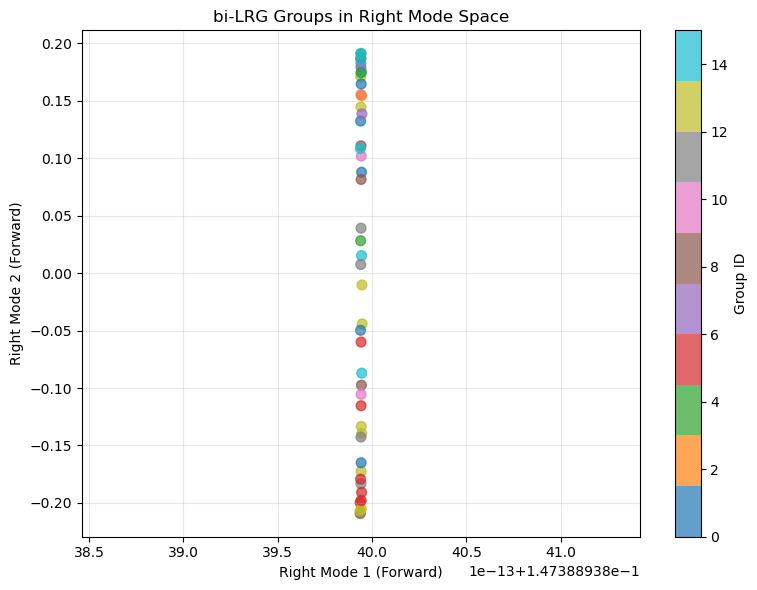

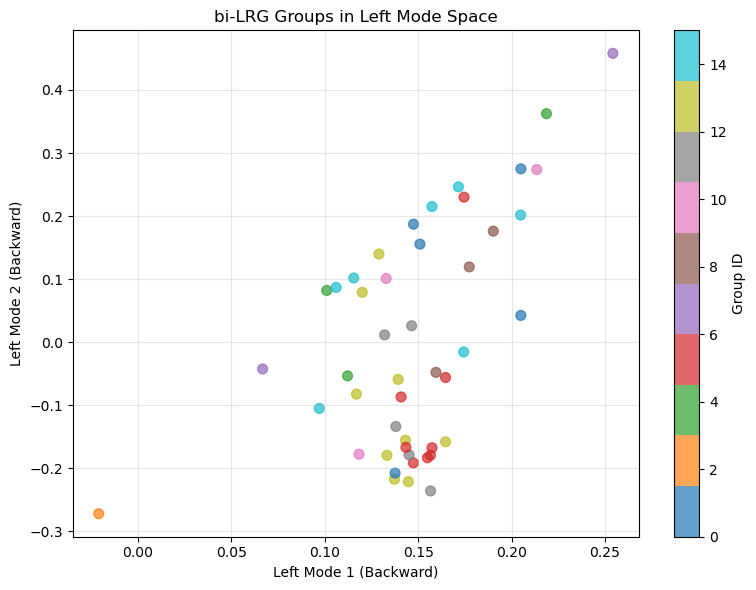

In [102]:
# Visualize bi-LRG results
print("Visualization of bi-LRG Results")
print("=" * 50)

# Get bi-embedding for visualization
X_biembed = bilrg.get_embedding()
print(f"Bi-embedding shape: {X_biembed.shape}")

# Visualize bi-embedding in 2D (first two principal components)
# Plot 1: First 2 dimensions of right modes (forward dynamics)
plt.figure(figsize=(8, 6))
plt.scatter(X_biembed[:, 0], X_biembed[:, 1], c=groups, 
            cmap='tab10', alpha=0.7, s=50)
plt.xlabel('Right Mode 1 (Forward)')
plt.ylabel('Right Mode 2 (Forward)')
plt.title('bi-LRG Groups in Right Mode Space')
plt.grid(True, alpha=0.3)
cbar1 = plt.colorbar()
cbar1.set_label('Group ID')
plt.tight_layout()
plt.show()

# Plot 2: First 2 dimensions of left modes (backward dynamics)
plt.figure(figsize=(8, 6))
k_half = X_biembed.shape[1] // 2
plt.scatter(X_biembed[:, k_half], X_biembed[:, k_half + 1], c=groups,
            cmap='tab10', alpha=0.7, s=50)
plt.xlabel('Left Mode 1 (Backward)')
plt.ylabel('Left Mode 2 (Backward)')
plt.title('bi-LRG Groups in Left Mode Space')
plt.grid(True, alpha=0.3)
cbar2 = plt.colorbar()
cbar2.set_label('Group ID')

plt.tight_layout()
plt.show()

/var/folders/xr/smwtgd4n7zs6_vpwrvw58_m40000gn/T/ipykernel_66755/2149090875.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


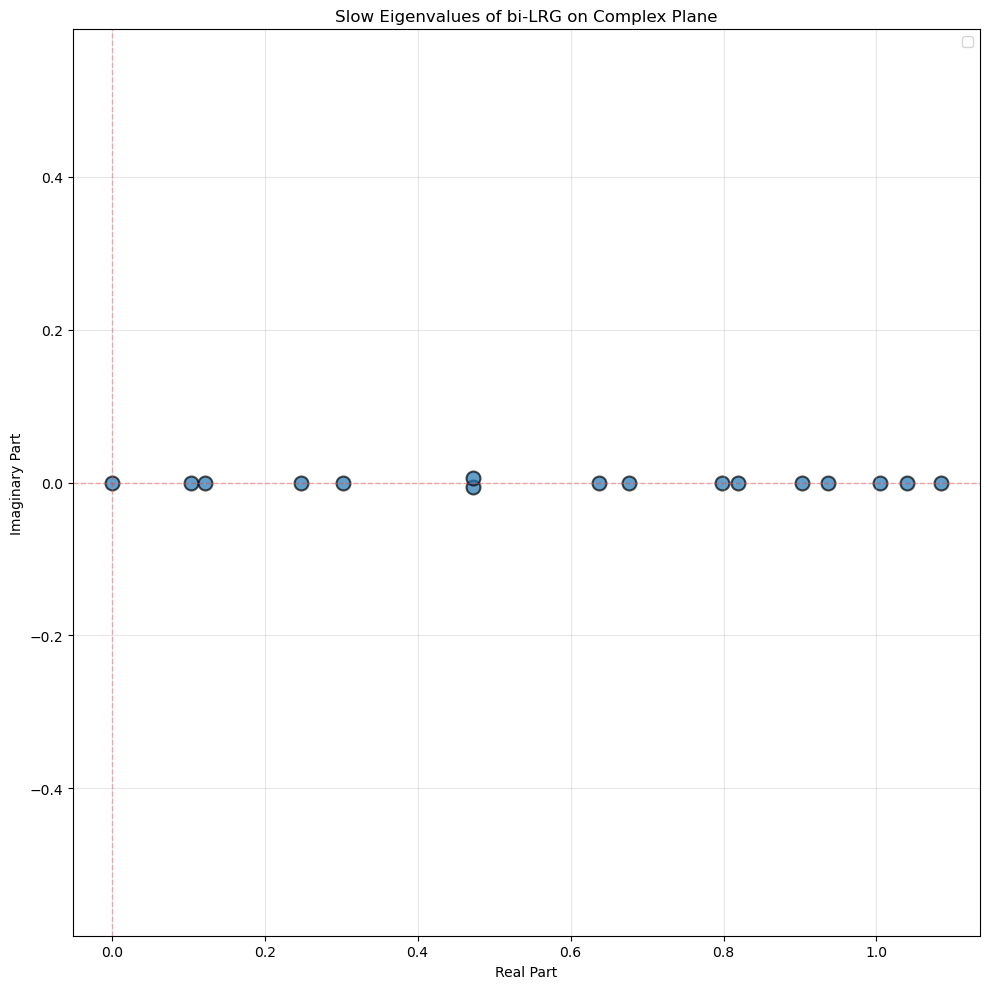

Slow eigenvalues (k=16): [9.32295383e-17+2.93424664e-19j 1.03185686e-01-1.99008023e-18j
 1.22065962e-01+1.79922812e-18j 2.47413447e-01+5.69358577e-18j
 3.02932006e-01-1.03607058e-17j 4.72689158e-01-5.63612076e-03j
 4.72689158e-01+5.63612076e-03j 6.37400245e-01+2.64180205e-18j
 6.76863809e-01-3.02796867e-17j 7.98640058e-01+1.06504343e-17j
 8.18350128e-01+6.35479493e-17j 9.02085623e-01+4.48586312e-17j
 9.36797806e-01+5.50222230e-17j 1.00431925e+00-2.10422852e-16j
 1.04000327e+00-1.17073480e-16j 1.08469762e+00-6.82262953e-16j]


In [103]:
# Show eigenvalue spectrum on complex plane
U_k, V_k, Lambda_k = bilrg.get_modes()

plt.figure(figsize=(10, 10))
plt.scatter(Lambda_k.real, Lambda_k.imag, 
           s=100, alpha=0.7, edgecolors='black', linewidths=1.5)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3, linewidth=1)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.3, linewidth=1)

# Add unit circle for reference
# theta = np.linspace(0, 2*np.pi, 100)
# plt.plot(np.cos(theta), np.sin(theta), 'g--', alpha=0.3, linewidth=1, label='Unit circle')

plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Slow Eigenvalues of bi-LRG on Complex Plane')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Slow eigenvalues (k={len(Lambda_k)}): {Lambda_k}")

Coarse Network Analysis
Coarse transition matrix P_group shape: (16, 16)
Coarse Laplacian L_group shape: (16, 16)
Coarse adjacency A_group shape: (16, 16)


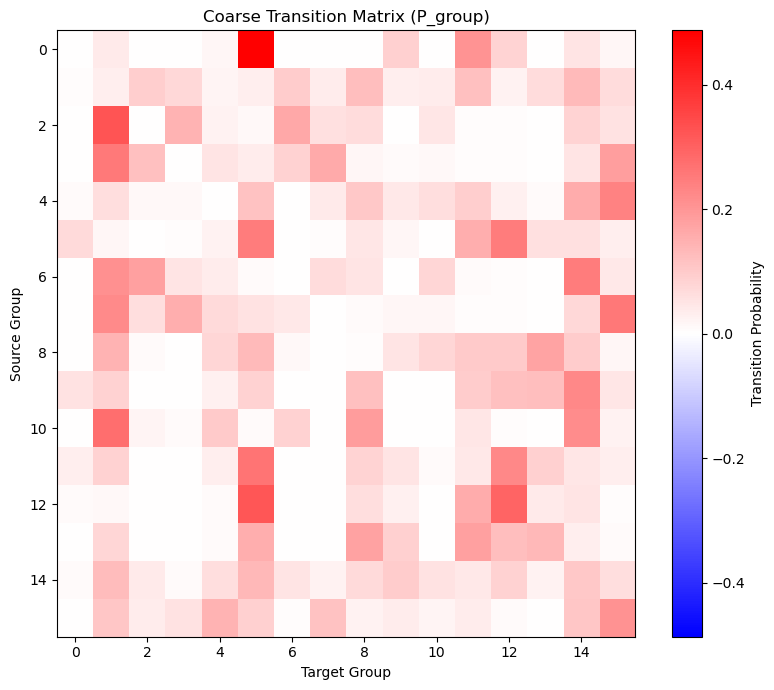

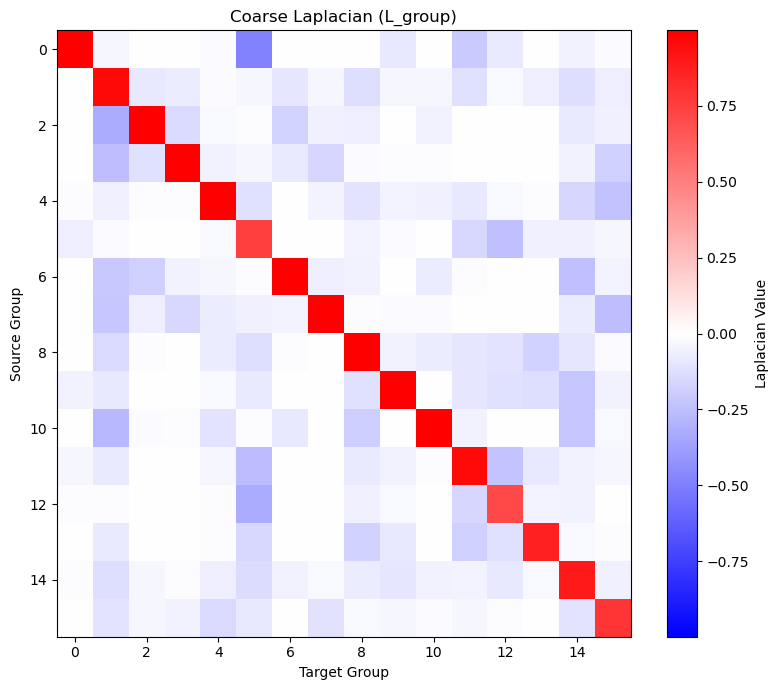

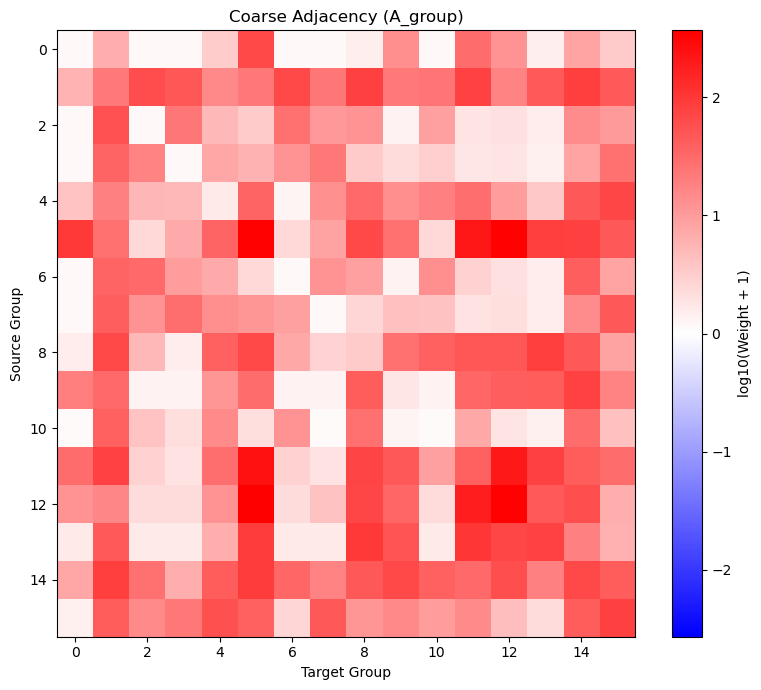


Coarse network statistics:
Number of groups: 16
Compression ratio: 2.9x
Transition matrix row sums (should be ~1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Spectral fidelity: 2.2939
Total weight in coarse network: 7739.0
Average weight per connection: 30.230

Strongest connections in coarse network:
Group 12 → Group 5: weight = 368.746
Group 5 → Group 5: weight = 345.729
Group 5 → Group 12: weight = 345.160
Group 12 → Group 12: weight = 339.353
Group 11 → Group 5: weight = 236.929


In [104]:
# Visualize coarse-grained network
print("Coarse Network Analysis")
print("=" * 50)

# Get coarse operators
P_group = coarse_graph['P_group']
L_group = coarse_graph['L_group']
A_group = coarse_graph['A_group']

print(f"Coarse transition matrix P_group shape: {P_group.shape}")
print(f"Coarse Laplacian L_group shape: {L_group.shape}")
print(f"Coarse adjacency A_group shape: {A_group.shape}")

# Plot P_group
plt.figure(figsize=(8, 7))
plt.imshow(P_group, cmap='bwr', aspect='auto',
           vmin=-np.max(np.abs(P_group)), vmax=np.max(np.abs(P_group)))
plt.title('Coarse Transition Matrix (P_group)')
plt.xlabel('Target Group')
plt.ylabel('Source Group')
plt.colorbar(label='Transition Probability')
plt.tight_layout()
plt.show()

# Plot L_group
plt.figure(figsize=(8, 7))
plt.imshow(L_group, cmap='bwr', aspect='auto', 
           vmin=-np.max(np.abs(L_group)), vmax=np.max(np.abs(L_group)))
plt.title('Coarse Laplacian (L_group)')
plt.xlabel('Target Group')
plt.ylabel('Source Group')
plt.colorbar(label='Laplacian Value')
plt.tight_layout()
plt.show()

# Plot A_group
plt.figure(figsize=(8, 7))
plt.imshow(np.log10(np.abs(A_group) + 1), cmap='bwr', aspect='auto',
           vmin=-np.max(np.log10(np.abs(A_group) + 1)), vmax=np.max(np.log10(np.abs(A_group) + 1)))
plt.title('Coarse Adjacency (A_group)')
plt.xlabel('Target Group')
plt.ylabel('Source Group')
plt.colorbar(label='log10(Weight + 1)')
plt.tight_layout()
plt.show()

# Show coarse network statistics
print(f"\nCoarse network statistics:")
print(f"Number of groups: {P_group.shape[0]}")
print(f"Compression ratio: {A_bilrg.shape[0] / P_group.shape[0]:.1f}x")
print(f"Transition matrix row sums (should be ~1): {P_group.sum(axis=1)}")
print(f"Spectral fidelity: {coarse_graph['fidelity']:.4f}")

# Analyze coarse network connectivity
total_coarse_weight = A_group.sum()
print(f"Total weight in coarse network: {total_coarse_weight:.1f}")
print(f"Average weight per connection: {total_coarse_weight / (P_group.shape[0]**2):.3f}")

# Show strongest connections in coarse network
print(f"\nStrongest connections in coarse network:")
flat_indices = np.argsort(A_group.flatten())[::-1][:5]
for idx in flat_indices:
    i, j = np.unravel_index(idx, A_group.shape)
    weight = A_group[i, j]
    if weight > 0.01:  # Only show significant connections
        print(f"Group {i} → Group {j}: weight = {weight:.3f}")

Bi-Galerkin Projection Analysis
Bi-Galerkin operator dimensions: 16 x 16
Eigenvalues used: [9.32295383e-17+2.93424664e-19j 1.03185686e-01-1.99008023e-18j
 1.22065962e-01+1.79922812e-18j 2.47413447e-01+5.69358577e-18j
 3.02932006e-01-1.03607058e-17j 4.72689158e-01-5.63612076e-03j
 4.72689158e-01+5.63612076e-03j 6.37400245e-01+2.64180205e-18j
 6.76863809e-01-3.02796867e-17j 7.98640058e-01+1.06504343e-17j
 8.18350128e-01+6.35479493e-17j 9.02085623e-01+4.48586312e-17j
 9.36797806e-01+5.50222230e-17j 1.00431925e+00-2.10422852e-16j
 1.04000327e+00-1.17073480e-16j 1.08469762e+00-6.82262953e-16j]


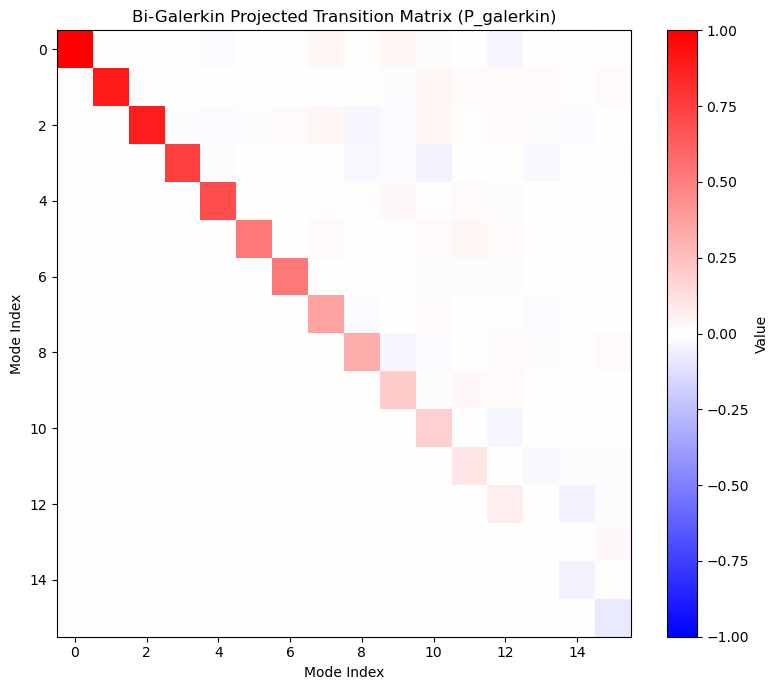

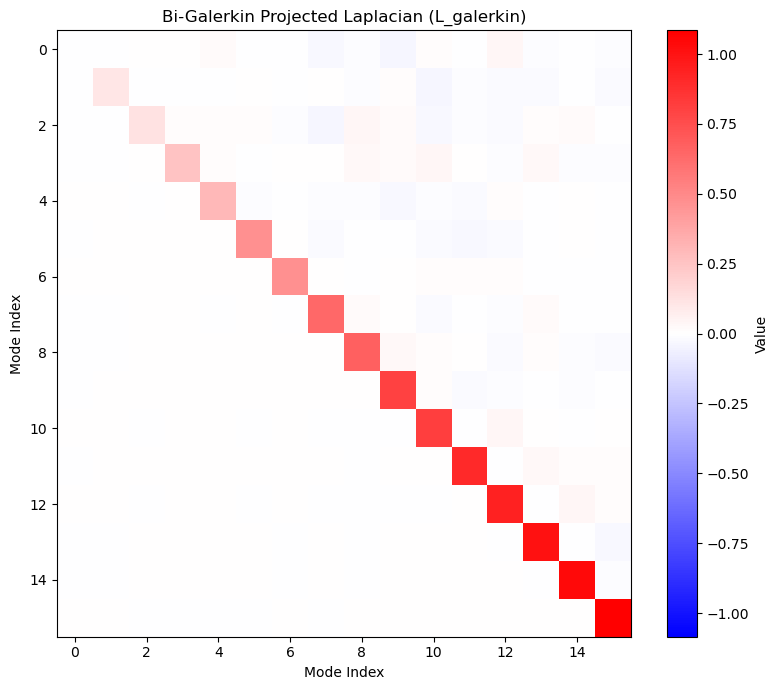

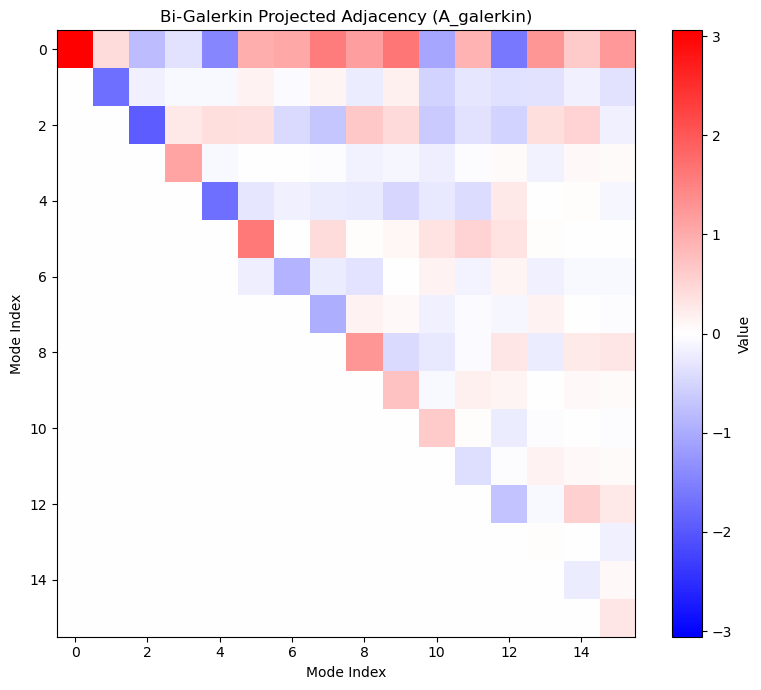


Mathematical Interpretation:
P_galerkin = U_k^H @ P @ V_k  (shape: (16, 16))
L_galerkin = U_k^H @ L_rw @ V_k  (shape: (16, 16))
A_galerkin = U_k^H @ A @ V_k  (shape: (16, 16))

This represents the 16-dimensional dynamics
projected into the subspace spanned by the slowest modes.

Comparison with Markov Lumping:
Bi-Galerkin dimensions: (16, 16)
Markov lumping dimensions: (16, 16)

Bi-Galerkin provides a purely spectral reduction,
while Markov lumping preserves node groupings and stationarity.


In [105]:
# Bi-Galerkin Projection Analysis
print("Bi-Galerkin Projection Analysis")
print("=" * 40)

# Get bi-Galerkin projected operators
P_galerkin = coarse_graph["P_galerkin"].real
L_galerkin = coarse_graph["L_galerkin"].real
A_galerkin = coarse_graph["A_galerkin"].real
eigenvals = coarse_graph["eigenvalues"]

print(f"Bi-Galerkin operator dimensions: {P_galerkin.shape[0]} x {P_galerkin.shape[1]}")
print(f"Eigenvalues used: {eigenvals}")

# Visualize bi-Galerkin projected operators in separate figures
# Plot P_galerkin
plt.figure(figsize=(8, 7))
plt.imshow(P_galerkin, cmap="bwr", aspect="auto",
           vmin=-np.max(np.abs(P_galerkin)), vmax=np.max(np.abs(P_galerkin)))
plt.title("Bi-Galerkin Projected Transition Matrix (P_galerkin)")
plt.xlabel("Mode Index")
plt.ylabel("Mode Index")
plt.colorbar(label='Value')
plt.tight_layout()
plt.show()

# Plot L_galerkin
plt.figure(figsize=(8, 7))
plt.imshow(L_galerkin, cmap="bwr", aspect="auto",
           vmin=-np.max(np.abs(L_galerkin)), vmax=np.max(np.abs(L_galerkin)))
plt.title("Bi-Galerkin Projected Laplacian (L_galerkin)")
plt.xlabel("Mode Index")
plt.ylabel("Mode Index")
plt.colorbar(label='Value')
plt.tight_layout()
plt.show()

# Plot A_galerkin
plt.figure(figsize=(8, 7))
plt.imshow(np.log10(np.abs(A_galerkin) + 1) * np.sign(A_galerkin), cmap="bwr", aspect="auto",
           vmin=-np.max(np.log10(np.abs(A_galerkin) + 1)), vmax=np.max(np.log10(np.abs(A_galerkin) + 1)))
plt.title("Bi-Galerkin Projected Adjacency (A_galerkin)")
plt.xlabel("Mode Index")
plt.ylabel("Mode Index")
plt.colorbar(label='Value')
plt.tight_layout()
plt.show()

# Print mathematical interpretation
print("\nMathematical Interpretation:")
print(f"P_galerkin = U_k^H @ P @ V_k  (shape: {P_galerkin.shape})")
print(f"L_galerkin = U_k^H @ L_rw @ V_k  (shape: {L_galerkin.shape})")
print(f"A_galerkin = U_k^H @ A @ V_k  (shape: {A_galerkin.shape})")
print(f"\nThis represents the {P_galerkin.shape[0]}-dimensional dynamics")
print("projected into the subspace spanned by the slowest modes.")

# Compare with Markov lumping approach
P_group = coarse_graph["P_group"]
L_group = coarse_graph["L_group"]
A_group = coarse_graph["A_group"]

print(f"\nComparison with Markov Lumping:")
print(f"Bi-Galerkin dimensions: {P_galerkin.shape}")
print(f"Markov lumping dimensions: {P_group.shape}")
print(f"\nBi-Galerkin provides a purely spectral reduction,")
print(f"while Markov lumping preserves node groupings and stationarity.")

##### Verify bi-orthogonality

In [106]:
# Compute left and right eigenvectors for bilrg
print("Computing Bi-orthogonal Eigenvectors for bilrg")
print("=" * 60)

# Select the k slowest modes
U_k = bilrg.U_k_
V_k = bilrg.V_k_
Lambda_k = bilrg.Lambda_k_

# U_k, V_k, Lambda_k = biorthogonal_modes(bilrg.L_rw_, k=5)

print(f"\nSelected k={k} slowest modes:")
print(f"U_k shape: {U_k.shape}")
print(f"V_k shape: {V_k.shape}")
print(f"Lambda_k shape: {Lambda_k.shape}")

# Verify bi-orthogonality of the k-mode subspace: U_k^H @ V_k = I_k
gram_k = U_k.conj().T @ V_k
identity_error_k = np.max(np.abs(gram_k - np.eye(k)))

print(f"\nBi-orthogonality check for k={k} modes: U_k^H @ V_k = I_k")
# print(f"U_k^H @ V_k =")
# print(gram_k)
print(f"\nMax deviation from I_k: {identity_error_k:.2e}")

# Verify that U_k^H @ L @ V_k = Lambda_k (diagonal matrix of eigenvalues)
L_projected = U_k.conj().T @ bilrg.L_ @ V_k

print(f"\nVerification: U_k^H @ L @ V_k")
print(f"Projected Laplacian shape: {L_projected.shape}")
print(f"Expected: diagonal matrix with eigenvalues on diagonal")

# Check if it's diagonal
off_diagonal = L_projected - np.diag(np.diag(L_projected))
off_diagonal_norm = np.max(np.abs(off_diagonal))
print(f"Max off-diagonal magnitude: {off_diagonal_norm:.2e}")

# Extract diagonal and compare with Lambda_k
diagonal_values = np.diag(L_projected)
eigenvalue_error = np.max(np.abs(diagonal_values - Lambda_k))
print(f"Max error between diagonal and Lambda_k: {eigenvalue_error:.2e}")

# print(f"\nDiagonal of U_k^H @ L @ V_k:")
# print(diagonal_values)
# print(f"\nLambda_k (expected eigenvalues):")
# print(Lambda_k)

Computing Bi-orthogonal Eigenvectors for bilrg

Selected k=16 slowest modes:
U_k shape: (46, 16)
V_k shape: (46, 16)
Lambda_k shape: (16,)

Bi-orthogonality check for k=16 modes: U_k^H @ V_k = I_k

Max deviation from I_k: 6.70e-15

Verification: U_k^H @ L @ V_k
Projected Laplacian shape: (16, 16)
Expected: diagonal matrix with eigenvalues on diagonal
Max off-diagonal magnitude: 4.28e-02
Max error between diagonal and Lambda_k: 3.33e-15


##### Bi-LRG groups

/var/folders/xr/smwtgd4n7zs6_vpwrvw58_m40000gn/T/ipykernel_66755/1070332795.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(A_reordered)), aspect='auto', cmap='bwr',
/var/folders/xr/smwtgd4n7zs6_vpwrvw58_m40000gn/T/ipykernel_66755/1070332795.py:10: RuntimeWarning: divide by zero encountered in log10
  vmin=-np.max(np.log10(np.abs(A_reordered))), vmax=np.max(np.log10(np.abs(A_reordered))))


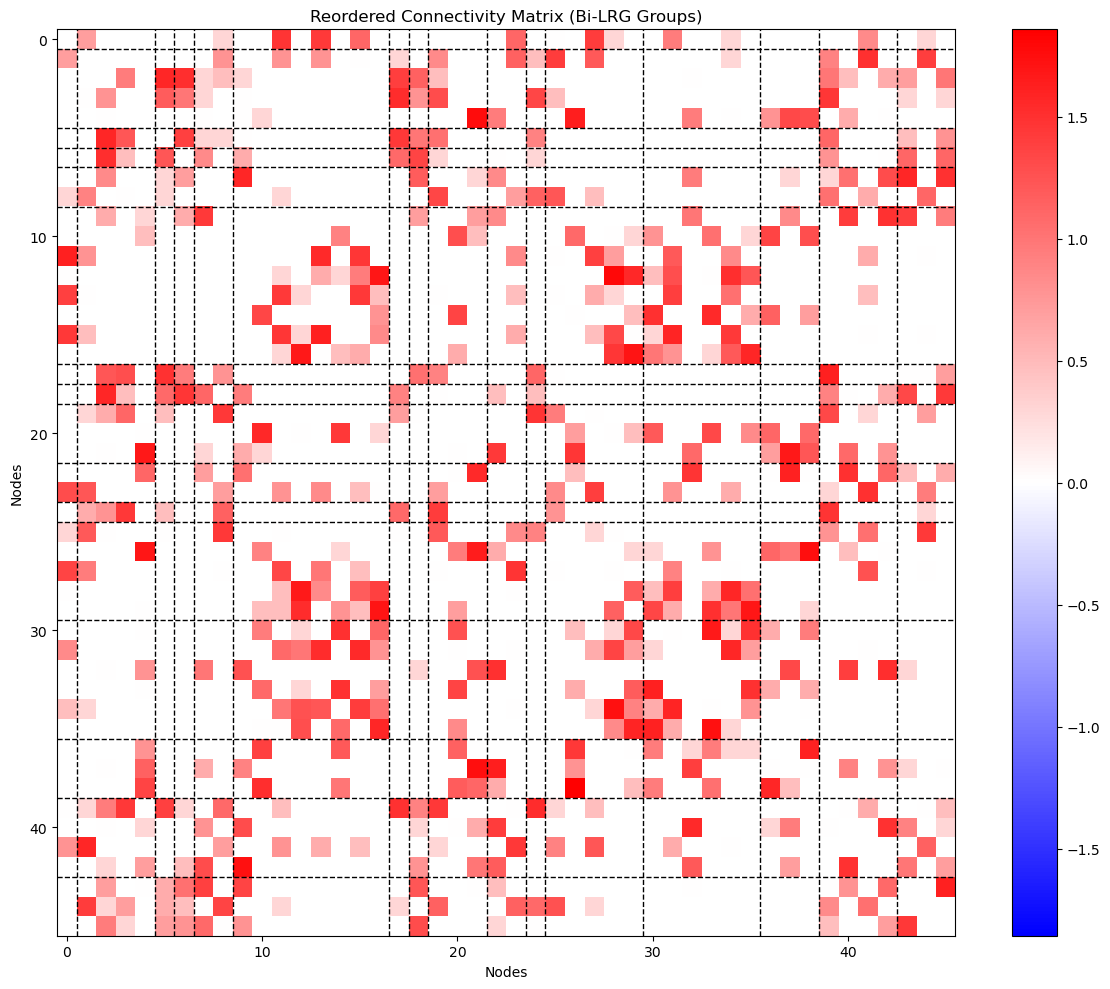

In [107]:
# Visualize the connectivity matrix reordered by bi-LRG groups
bilrg_labels = coarse_graph['groups']

# Get the order of nodes based on group assignments
node_order = np.argsort(bilrg_labels)
A_reordered = A[np.ix_(node_order, node_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(A_reordered)), aspect='auto', cmap='bwr',
           vmin=-np.max(np.log10(np.abs(A_reordered))), vmax=np.max(np.log10(np.abs(A_reordered))))
plt.colorbar()
plt.title('Reordered Connectivity Matrix (Bi-LRG Groups)')
plt.xlabel('Nodes')
plt.ylabel('Nodes')

# Draw lines to separate groups
unique_groups, group_indices = np.unique(bilrg_labels[node_order], return_index=True)
for idx in group_indices[1:]:
    plt.axhline(y=idx - 0.5, color='k', linestyle='--', linewidth=1)
    plt.axvline(x=idx - 0.5, color='k', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

/var/folders/xr/smwtgd4n7zs6_vpwrvw58_m40000gn/T/ipykernel_66755/1382775512.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(A_reordered)) * np.sign(A_reordered), aspect='auto', cmap='bwr',
/var/folders/xr/smwtgd4n7zs6_vpwrvw58_m40000gn/T/ipykernel_66755/1382775512.py:10: RuntimeWarning: invalid value encountered in multiply
  plt.imshow(np.log10(np.abs(A_reordered)) * np.sign(A_reordered), aspect='auto', cmap='bwr',
/var/folders/xr/smwtgd4n7zs6_vpwrvw58_m40000gn/T/ipykernel_66755/1382775512.py:11: RuntimeWarning: divide by zero encountered in log10
  vmin=-np.max(np.log10(np.abs(A_reordered))), vmax=np.max(np.log10(np.abs(A_reordered))))


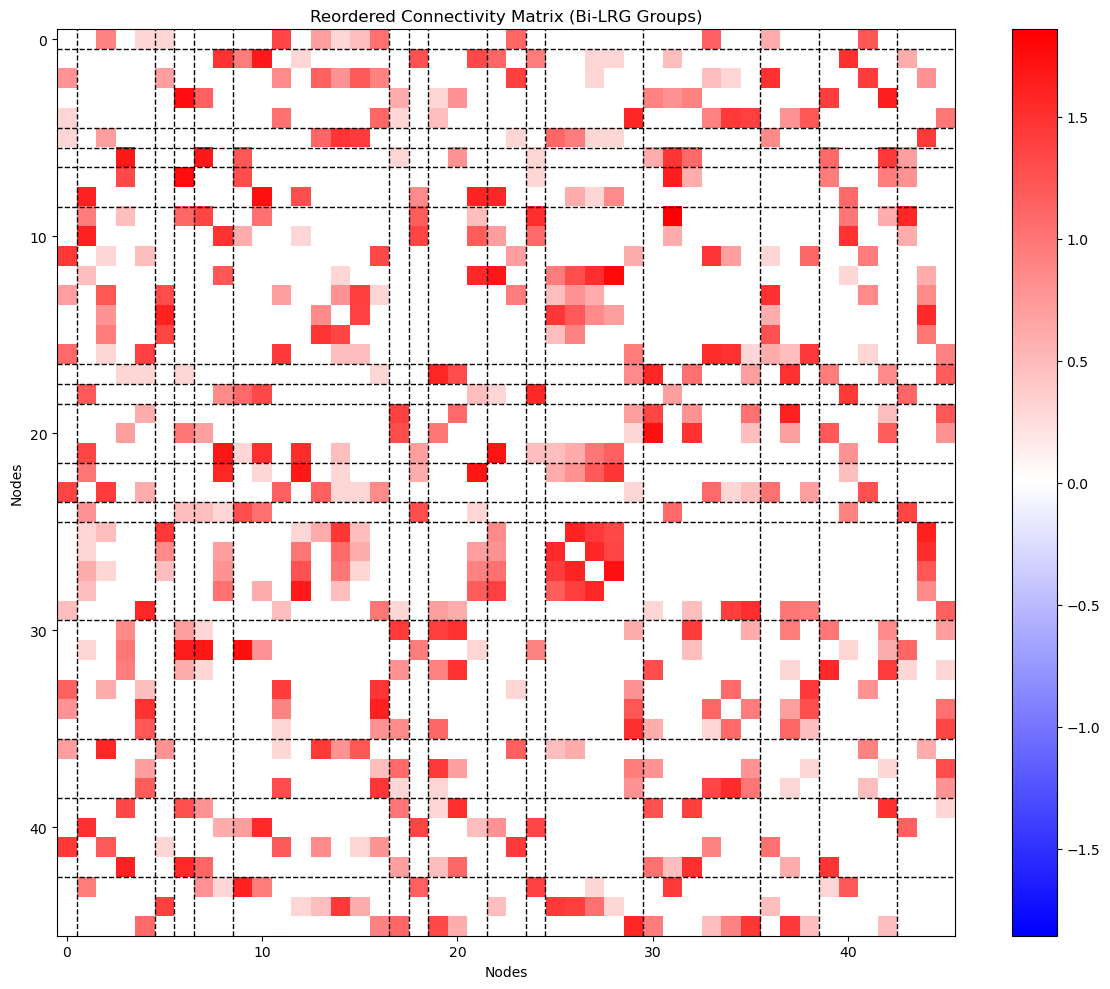

In [108]:
# Visualize the connectivity matrix reordered by bi-LRG groups
bilrg_labels = coarse_graph['groups']

# Get the order of nodes based on group assignments
node_order = np.argsort(bilrg_labels)
A_signed = C_signed_grouped.copy()
A_reordered = A_signed[np.ix_(node_order, node_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(A_reordered)) * np.sign(A_reordered), aspect='auto', cmap='bwr',
           vmin=-np.max(np.log10(np.abs(A_reordered))), vmax=np.max(np.log10(np.abs(A_reordered))))
plt.colorbar()
plt.title('Reordered Connectivity Matrix (Bi-LRG Groups)')
plt.xlabel('Nodes')
plt.ylabel('Nodes')

# Draw lines to separate groups
unique_groups, group_indices = np.unique(bilrg_labels[node_order], return_index=True)
for idx in group_indices[1:]:
    plt.axhline(y=idx - 0.5, color='k', linestyle='--', linewidth=1)
    plt.axvline(x=idx - 0.5, color='k', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


Contingency table (cell types vs. bi-LRG groups):
bi-LRG Group  0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
Cell Type                                                                   
EPG            1   4   1   1   2   8   1   1   3   2   1   5   6   3   4   3


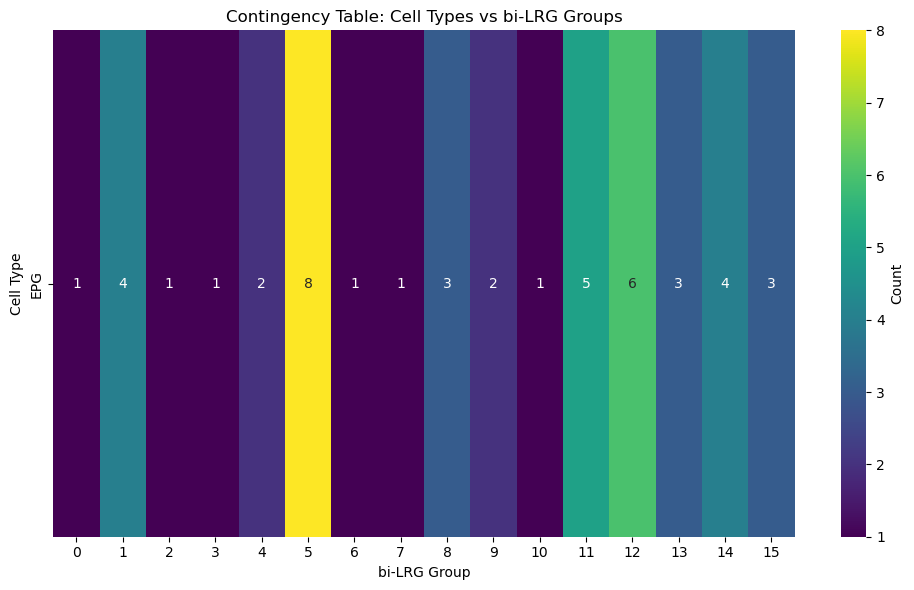

Group 0: purity=1.000, dominant type=EPG
Group 1: purity=1.000, dominant type=EPG
Group 2: purity=1.000, dominant type=EPG
Group 3: purity=1.000, dominant type=EPG
Group 4: purity=1.000, dominant type=EPG
Group 5: purity=1.000, dominant type=EPG
Group 6: purity=1.000, dominant type=EPG
Group 7: purity=1.000, dominant type=EPG
Group 8: purity=1.000, dominant type=EPG
Group 9: purity=1.000, dominant type=EPG
Group 10: purity=1.000, dominant type=EPG
Group 11: purity=1.000, dominant type=EPG
Group 12: purity=1.000, dominant type=EPG
Group 13: purity=1.000, dominant type=EPG
Group 14: purity=1.000, dominant type=EPG
Group 15: purity=1.000, dominant type=EPG

Average bi-LRG group purity: 1.000


In [109]:
# Contingency table of cell types vs. bi-LRG groups
print(f"\nContingency table (cell types vs. bi-LRG groups):")

# Create contingency table
contingency_table = pd.crosstab(
    pd.Series(ctoi_grouped, name='Cell Type'),
    pd.Series(bilrg_labels, name='bi-LRG Group')
)

print(contingency_table)

# Visualize as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='viridis', cbar_kws={'label': 'Count'})
plt.title('Contingency Table: Cell Types vs bi-LRG Groups')
plt.xlabel('bi-LRG Group')
plt.ylabel('Cell Type')
plt.tight_layout()
plt.show()

# Calculate purity metrics
group_purity = []
for group_id in range(contingency_table.shape[1]):
    group_col = contingency_table.iloc[:, group_id]
    if group_col.sum() > 0:
        purity = group_col.max() / group_col.sum()
        group_purity.append(purity)
        dominant_type = group_col.idxmax()
        print(f"Group {group_id}: purity={purity:.3f}, dominant type={dominant_type}")

print(f"\nAverage bi-LRG group purity: {np.mean(group_purity):.3f}")

### Checkpoint

In [110]:
### Checkpoint
variables_to_keep = ['ctoi_grouped', 'noi_grouped', 'C_signed_grouped', 'C_unsigned_grouped', 'new_order', 'unique_cell_types', 'cell_type_counts',
                     'D_out', 'D_in', 'L_out', 'L_in', 'L_rw', 'A_sym', 'D_sym', 'L_sym', 'L_bal',
                     'P_hat', 'L_hat', 'K_hat', 'rho_hat', 'bilrg', 'P_group', 'L_group', 'A_group', 'P_galerkin', 'L_galerkin', 'A_galerkin', 'bilrg_labels']
print("Variables to keep for further analysis:")
for var in variables_to_keep:
    if var in globals():
        var_obj = globals()[var]
        var_type = type(var_obj).__name__
        
        if hasattr(var_obj, 'shape'):
            structure = f"shape: {var_obj.shape}"
        elif hasattr(var_obj, '__len__'):
            structure = f"length: {len(var_obj)}"
        else:
            structure = "scalar"
            
        print(f"\t{var}: {var_type}, {structure}")
    else:
        print(f"\t{var}: NOT FOUND")

Variables to keep for further analysis:
	ctoi_grouped: list, length: 46
	noi_grouped: list, length: 46
	C_signed_grouped: ndarray, shape: (46, 46)
	C_unsigned_grouped: ndarray, shape: (46, 46)
	new_order: list, length: 46
	unique_cell_types: list, length: 1
	cell_type_counts: dict, length: 1
	D_out: ndarray, shape: (46, 46)
	D_in: ndarray, shape: (46, 46)
	L_out: ndarray, shape: (46, 46)
	L_in: ndarray, shape: (46, 46)
	L_rw: ndarray, shape: (46, 46)
	A_sym: ndarray, shape: (46, 46)
	D_sym: ndarray, shape: (46, 46)
	L_sym: ndarray, shape: (46, 46)
	L_bal: ndarray, shape: (46, 46)
	P_hat: ndarray, shape: (46, 46)
	L_hat: ndarray, shape: (46, 46)
	K_hat: ndarray, shape: (46, 46)
	rho_hat: ndarray, shape: (46, 46)
	bilrg: BiLRG, scalar
	P_group: ndarray, shape: (16, 16)
	L_group: ndarray, shape: (16, 16)
	A_group: ndarray, shape: (16, 16)
	P_galerkin: ndarray, shape: (16, 16)
	L_galerkin: ndarray, shape: (16, 16)
	A_galerkin: ndarray, shape: (16, 16)
	bilrg_labels: ndarray, shape: (46,)


### Modularity optimization

In [111]:
# A = C_unsigned_grouped

print(f"Matrix A shape: {A.shape}")
print(f"Matrix A type: {type(A)}")
print(f"Matrix A min: {A.min()}, max: {A.max()}")
print(f"Number of non-zero entries: {np.count_nonzero(A)}")

Matrix A shape: (46, 46)
Matrix A type: <class 'numpy.ndarray'>
Matrix A min: 0.0, max: 72.0
Number of non-zero entries: 632


#### Louvain method

In [112]:
# Convert the unsigned adjacency matrix to a NetworkX graph
G = nx.from_numpy_array(A, create_using=nx.DiGraph())

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Apply Louvain community detection
# Note: networkx uses the python-louvain package for this
try:
    communities = community.louvain_communities(G.to_undirected(), seed=42)
    print(f"Louvain detected {len(communities)} communities")
    
    # Sort communities by size (largest first)
    communities_sorted = sorted(communities, key=len, reverse=True)
    
    # Create community assignment array with sorted community indices
    community_labels = np.zeros(len(A), dtype=int)
    for i, comm in enumerate(communities_sorted):
        for node in comm:
            community_labels[node] = i
    
    # Print community sizes
    community_sizes = [len(comm) for comm in communities_sorted]
    print(f"Community sizes: {community_sizes}")
    
    # Calculate modularity
    modularity = community.modularity(G.to_undirected(), communities_sorted)
    print(f"Modularity: {modularity:.4f}")
    
    # Update communities to use sorted version
    communities = communities_sorted
    
except ImportError:
    print("python-louvain not available, using alternative community detection")
    # Fallback to other community detection methods
    communities = list(community.greedy_modularity_communities(G.to_undirected()))
    print(f"Greedy modularity detected {len(communities)} communities")
    
    # Sort communities by size (largest first)
    communities_sorted = sorted(communities, key=len, reverse=True)
    
    community_labels = np.zeros(len(A), dtype=int)
    for i, comm in enumerate(communities_sorted):
        for node in comm:
            community_labels[node] = i
    
    community_sizes = [len(comm) for comm in communities_sorted]
    print(f"Community sizes: {community_sizes}")
    
    modularity = community.modularity(G.to_undirected(), communities_sorted)
    print(f"Modularity (Newman's Q): {modularity:.4f}")
    
    # Update communities to use sorted version
    communities = communities_sorted

# Store results for further analysis
louvain_communities = communities
louvain_labels = community_labels
louvain_modularity = modularity

Graph created with 46 nodes and 632 edges
Louvain detected 5 communities
Community sizes: [11, 11, 10, 8, 6]
Modularity: 0.5766


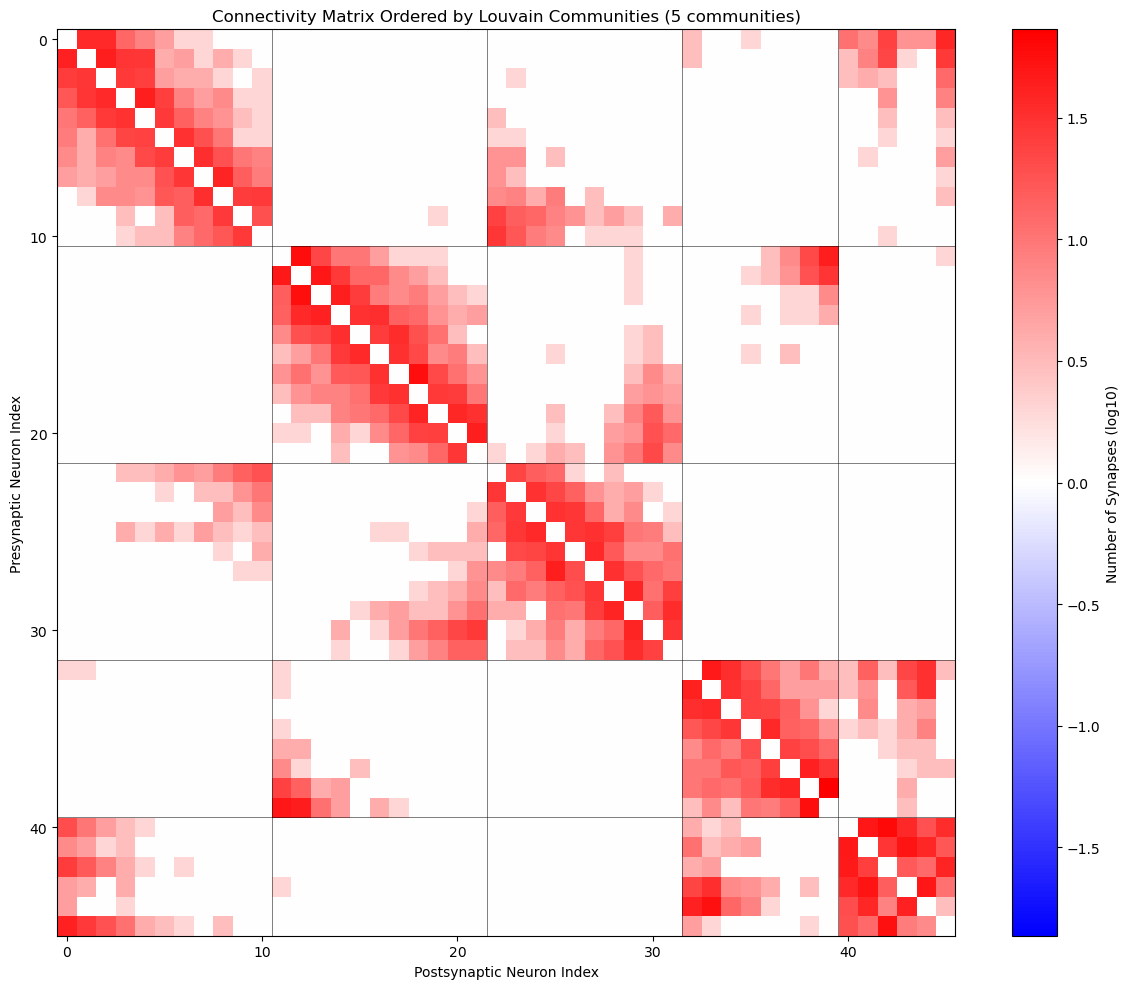


Comparison with original cell type grouping:
Original cell types: 1
Louvain communities: 5
Modularity (Newman's Q): 0.5766


In [113]:
# Visualize the connectivity matrix reordered by Louvain communities
# Create new ordering based on Louvain communities
louvain_order = []
for i, comm in enumerate(louvain_communities):
    louvain_order.extend(sorted(comm))

# Reorder the matrix by Louvain communities
A_louvain_ordered = A[np.ix_(louvain_order, louvain_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(A_louvain_ordered + 1), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(A_louvain_ordered + 1)),
           vmax=np.max(np.log10(A_louvain_ordered + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Connectivity Matrix Ordered by Louvain Communities ({len(louvain_communities)} communities)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add community boundaries
community_boundaries = []
current_pos = 0
for i, comm in enumerate(louvain_communities):
    community_size = len(comm)
    community_boundaries.append(current_pos + community_size)
    current_pos += community_size

# Add lines to separate communities
for boundary in community_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Compare Louvain communities with original cell type grouping
print("\nComparison with original cell type grouping:")
print(f"Original cell types: {len(unique_cell_types)}")
print(f"Louvain communities: {len(louvain_communities)}")
print(f"Modularity (Newman's Q): {louvain_modularity:.4f}")

# Create a mapping to see how cell types are distributed across Louvain communities
cell_type_to_louvain = {}
for i, cell_type in enumerate(ctoi_grouped):
    louvain_comm = louvain_labels[i]
    if cell_type not in cell_type_to_louvain:
        cell_type_to_louvain[cell_type] = {}
    if louvain_comm not in cell_type_to_louvain[cell_type]:
        cell_type_to_louvain[cell_type][louvain_comm] = 0
    cell_type_to_louvain[cell_type][louvain_comm] += 1

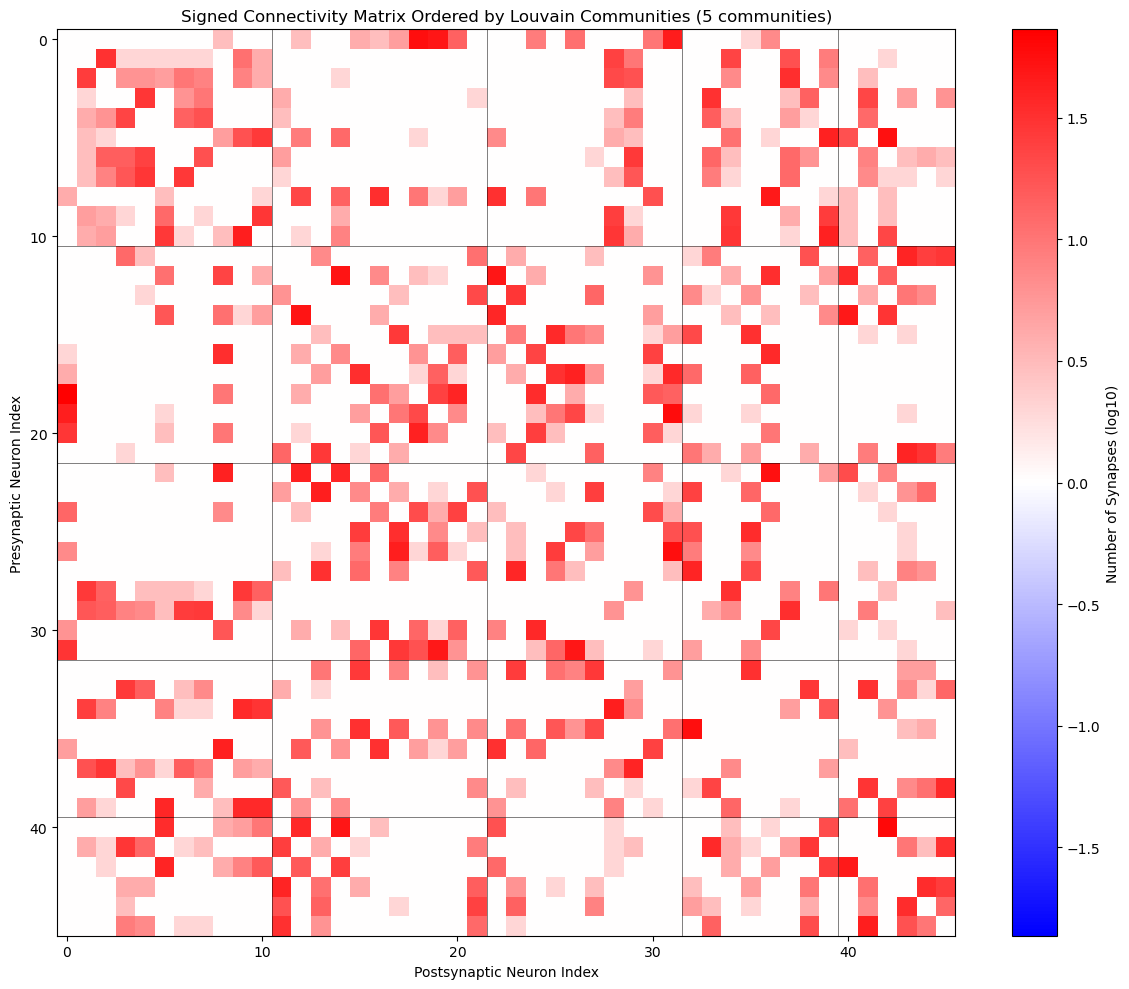


Comparison with original cell type grouping:
Original cell types: 1
Louvain communities: 5
Modularity (Newman's Q): 0.5766


In [114]:
# Visualize the connectivity matrix reordered by Louvain communities
# Create new ordering based on Louvain communities
louvain_order = []
for i, comm in enumerate(louvain_communities):
    louvain_order.extend(sorted(comm))

# Reorder the matrix by Louvain communities
A_signed = C_signed_grouped
A_louvain_ordered = A_signed[np.ix_(louvain_order, louvain_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(A_louvain_ordered) + 1) * np.sign(A_louvain_ordered), 
           cmap='bwr', aspect='auto', 
           vmin=-np.max(np.log10(np.abs(A_louvain_ordered) + 1)),
           vmax=np.max(np.log10(np.abs(A_louvain_ordered) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Signed Connectivity Matrix Ordered by Louvain Communities ({len(louvain_communities)} communities)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add community boundaries
community_boundaries = []
current_pos = 0
for i, comm in enumerate(louvain_communities):
    community_size = len(comm)
    community_boundaries.append(current_pos + community_size)
    current_pos += community_size

# Add lines to separate communities
for boundary in community_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Compare Louvain communities with original cell type grouping
print("\nComparison with original cell type grouping:")
print(f"Original cell types: {len(unique_cell_types)}")
print(f"Louvain communities: {len(louvain_communities)}")
print(f"Modularity (Newman's Q): {louvain_modularity:.4f}")

# Create a mapping to see how cell types are distributed across Louvain communities
cell_type_to_louvain = {}
for i, cell_type in enumerate(ctoi_grouped):
    louvain_comm = louvain_labels[i]
    if cell_type not in cell_type_to_louvain:
        cell_type_to_louvain[cell_type] = {}
    if louvain_comm not in cell_type_to_louvain[cell_type]:
        cell_type_to_louvain[cell_type][louvain_comm] = 0
    cell_type_to_louvain[cell_type][louvain_comm] += 1

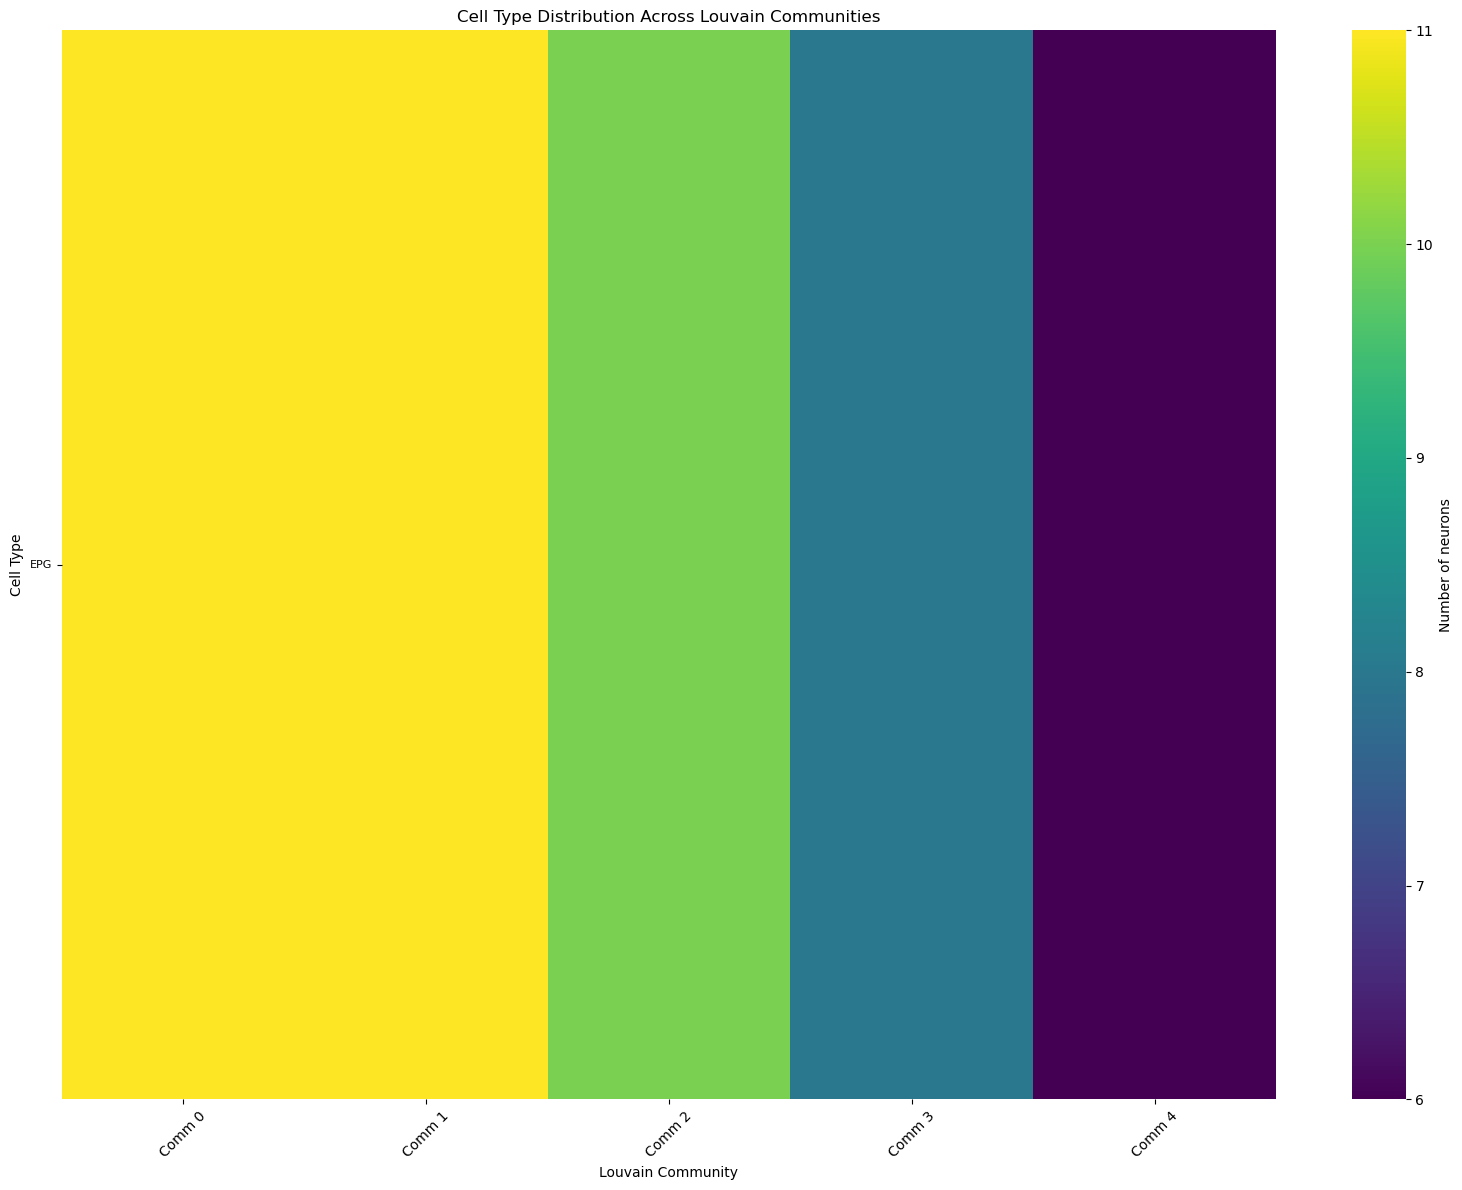

Distribution matrix shape: (1, 5)
Non-zero entries in distribution matrix: 5
Cell types split across multiple communities: 1/1
Average community purity: 1.000
Community purity range: 1.000 - 1.000


In [115]:
# Create a 2D heatmap of cell type distribution across Louvain communities
# Create a matrix: rows = cell types, columns = Louvain communities
n_cell_types = len(unique_cell_types)
n_communities = len(louvain_communities)

# Initialize the distribution matrix
distribution_matrix = np.zeros((n_cell_types, n_communities))

# Fill the matrix
for i, cell_type in enumerate(ctoi_grouped):
    louvain_comm = louvain_labels[i]
    cell_type_idx = unique_cell_types.index(cell_type)
    distribution_matrix[cell_type_idx, louvain_comm] += 1

# Create the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(distribution_matrix, 
            xticklabels=[f'Comm {i}' for i in range(n_communities)],
            yticklabels=unique_cell_types,
            cmap='viridis',
            annot=False,
            fmt='g',
            cbar_kws={'label': 'Number of neurons'})

plt.title('Cell Type Distribution Across Louvain Communities')
plt.xlabel('Louvain Community')
plt.ylabel('Cell Type')
plt.xticks(rotation=45)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Show statistics about the distribution
print(f"Distribution matrix shape: {distribution_matrix.shape}")
print(f"Non-zero entries in distribution matrix: {np.count_nonzero(distribution_matrix)}")

# Calculate how many cell types are split across multiple communities
split_cell_types = 0
for i in range(n_cell_types):
    if np.count_nonzero(distribution_matrix[i, :]) > 1:
        split_cell_types += 1

print(f"Cell types split across multiple communities: {split_cell_types}/{n_cell_types}")

# Calculate community purity (max cell type fraction in each community)
community_purity = []
for j in range(n_communities):
    if distribution_matrix[:, j].sum() > 0:
        purity = distribution_matrix[:, j].max() / distribution_matrix[:, j].sum()
        community_purity.append(purity)

print(f"Average community purity: {np.mean(community_purity):.3f}")
print(f"Community purity range: {np.min(community_purity):.3f} - {np.max(community_purity):.3f}")

#### Leiden algorithm

In [116]:
# Implement Leiden algorithm for community detection
# Convert NetworkX graph to igraph for Leiden algorithm
# Create adjacency list
edges = list(G.edges(data=True))
edge_list = [(u, v) for u, v, d in edges]
weights = [d['weight'] for u, v, d in edges]

# Create igraph
g_ig = ig.Graph(directed=False)
g_ig.add_vertices(G.number_of_nodes())
g_ig.add_edges(edge_list)
g_ig.es['weight'] = weights

# Apply Leiden algorithm
partition = leidenalg.find_partition(g_ig, leidenalg.ModularityVertexPartition, 
                                    weights='weight', seed=42)

# Extract community assignments
leiden_communities = [list(community) for community in partition]
leiden_labels = np.zeros(len(A), dtype=int)

for i, comm in enumerate(leiden_communities):
    for node in comm:
        leiden_labels[node] = i

leiden_modularity = partition.modularity

print(f"Leiden detected {len(leiden_communities)} communities")
leiden_community_sizes = [len(comm) for comm in leiden_communities]
print(f"Community sizes: {sorted(leiden_community_sizes, reverse=True)}")
print(f"Modularity (Newman's Q): {leiden_modularity:.4f}")

Leiden detected 5 communities
Community sizes: [11, 11, 9, 8, 7]
Modularity (Newman's Q): 0.3597


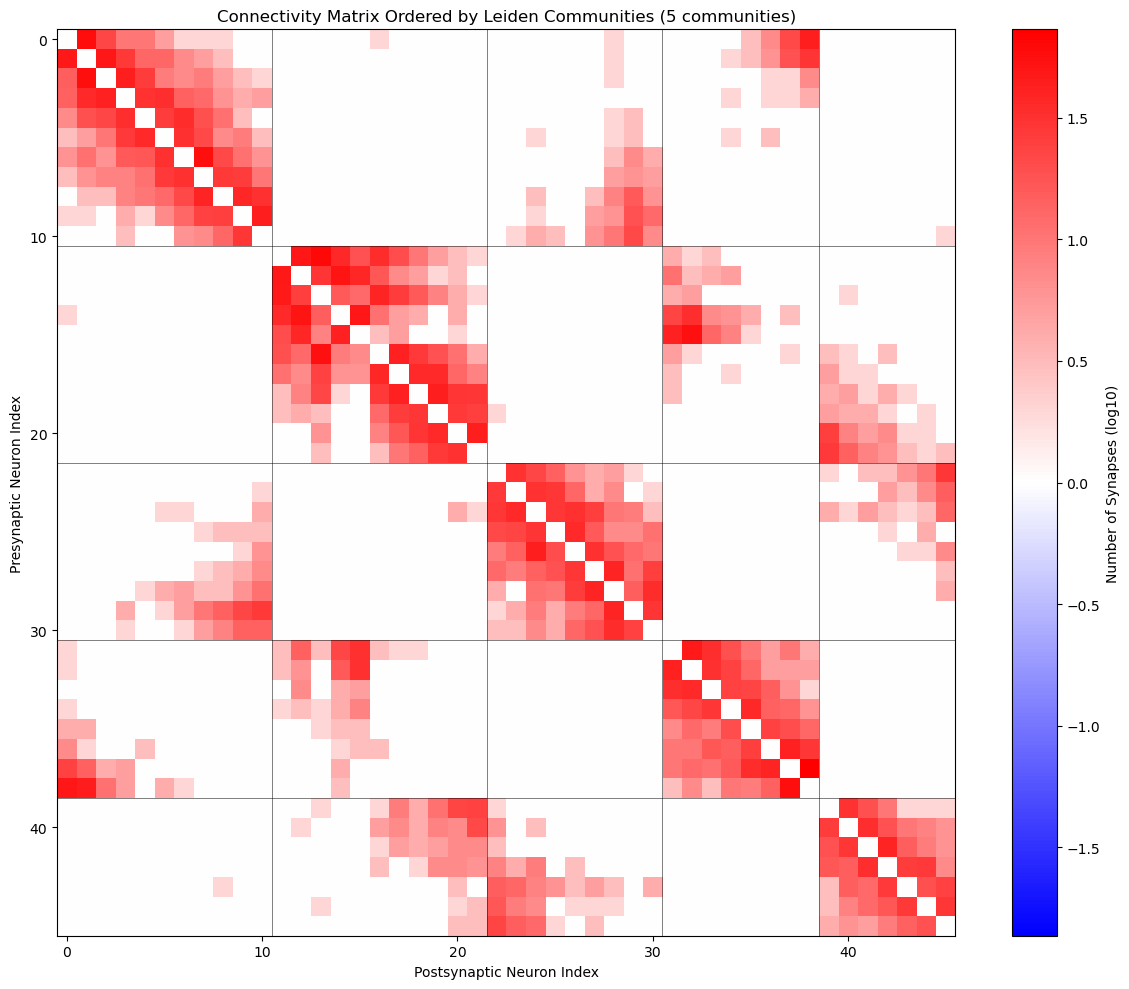


Comparison with original cell type grouping:
Original cell types: 1
Leiden communities: 5
Modularity (Newman's Q): 0.3597


In [117]:
# Visualize Leiden communities (if available)
# Visualize the connectivity matrix reordered by Leiden communities
leiden_order = []
for i, comm in enumerate(leiden_communities):
    leiden_order.extend(sorted(comm))

# Reorder the matrix by Leiden communities
A_leiden_ordered = A[np.ix_(leiden_order, leiden_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(A_leiden_ordered + 1), 
            cmap='bwr', aspect='auto',
            vmin=-np.max(np.log10(A_leiden_ordered + 1)),
            vmax=np.max(np.log10(A_leiden_ordered + 1)),
            interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Connectivity Matrix Ordered by Leiden Communities ({len(leiden_communities)} communities)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add community boundaries
leiden_boundaries = []
current_pos = 0
for i, comm in enumerate(leiden_communities):
    community_size = len(comm)
    leiden_boundaries.append(current_pos + community_size)
    current_pos += community_size

# Add lines to separate communities
for boundary in leiden_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Compare Leiden communities with original cell type grouping
print("\nComparison with original cell type grouping:")
print(f"Original cell types: {len(unique_cell_types)}")
print(f"Leiden communities: {len(leiden_communities)}")
print(f"Modularity (Newman's Q): {leiden_modularity:.4f}")

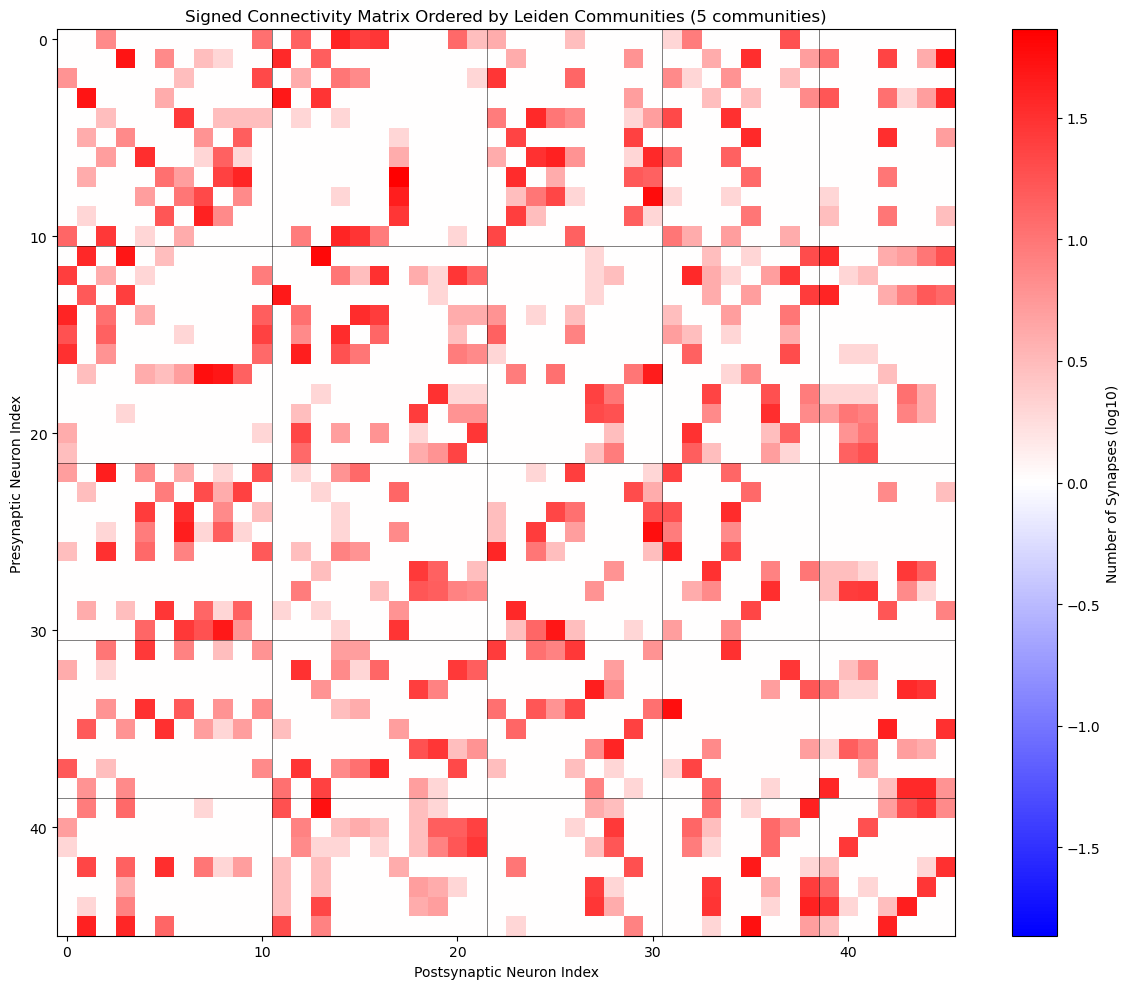


Comparison with original cell type grouping:
Original cell types: 1
Leiden communities: 5
Modularity (Newman's Q): 0.3597


In [118]:
# Visualize Leiden communities (if available)
# Visualize the connectivity matrix reordered by Leiden communities
leiden_order = []
for i, comm in enumerate(leiden_communities):
    leiden_order.extend(sorted(comm))

# Reorder the matrix by Leiden communities
A_signed = C_signed_grouped
A_leiden_ordered = A_signed[np.ix_(leiden_order, leiden_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(A_leiden_ordered) + 1) * np.sign(A_leiden_ordered), 
                   cmap='bwr', aspect='auto',
                   vmin=-np.max(np.log10(np.abs(A_leiden_ordered) + 1)),
                   vmax=np.max(np.log10(np.abs(A_leiden_ordered) + 1)),
                   interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Signed Connectivity Matrix Ordered by Leiden Communities ({len(leiden_communities)} communities)')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add community boundaries
leiden_boundaries = []
current_pos = 0
for i, comm in enumerate(leiden_communities):
    community_size = len(comm)
    leiden_boundaries.append(current_pos + community_size)
    current_pos += community_size

# Add lines to separate communities
for boundary in leiden_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)
    plt.axvline(x=boundary-0.5, color='k', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

# Compare Leiden communities with original cell type grouping
print("\nComparison with original cell type grouping:")
print(f"Original cell types: {len(unique_cell_types)}")
print(f"Leiden communities: {len(leiden_communities)}")
print(f"Modularity (Newman's Q): {leiden_modularity:.4f}")

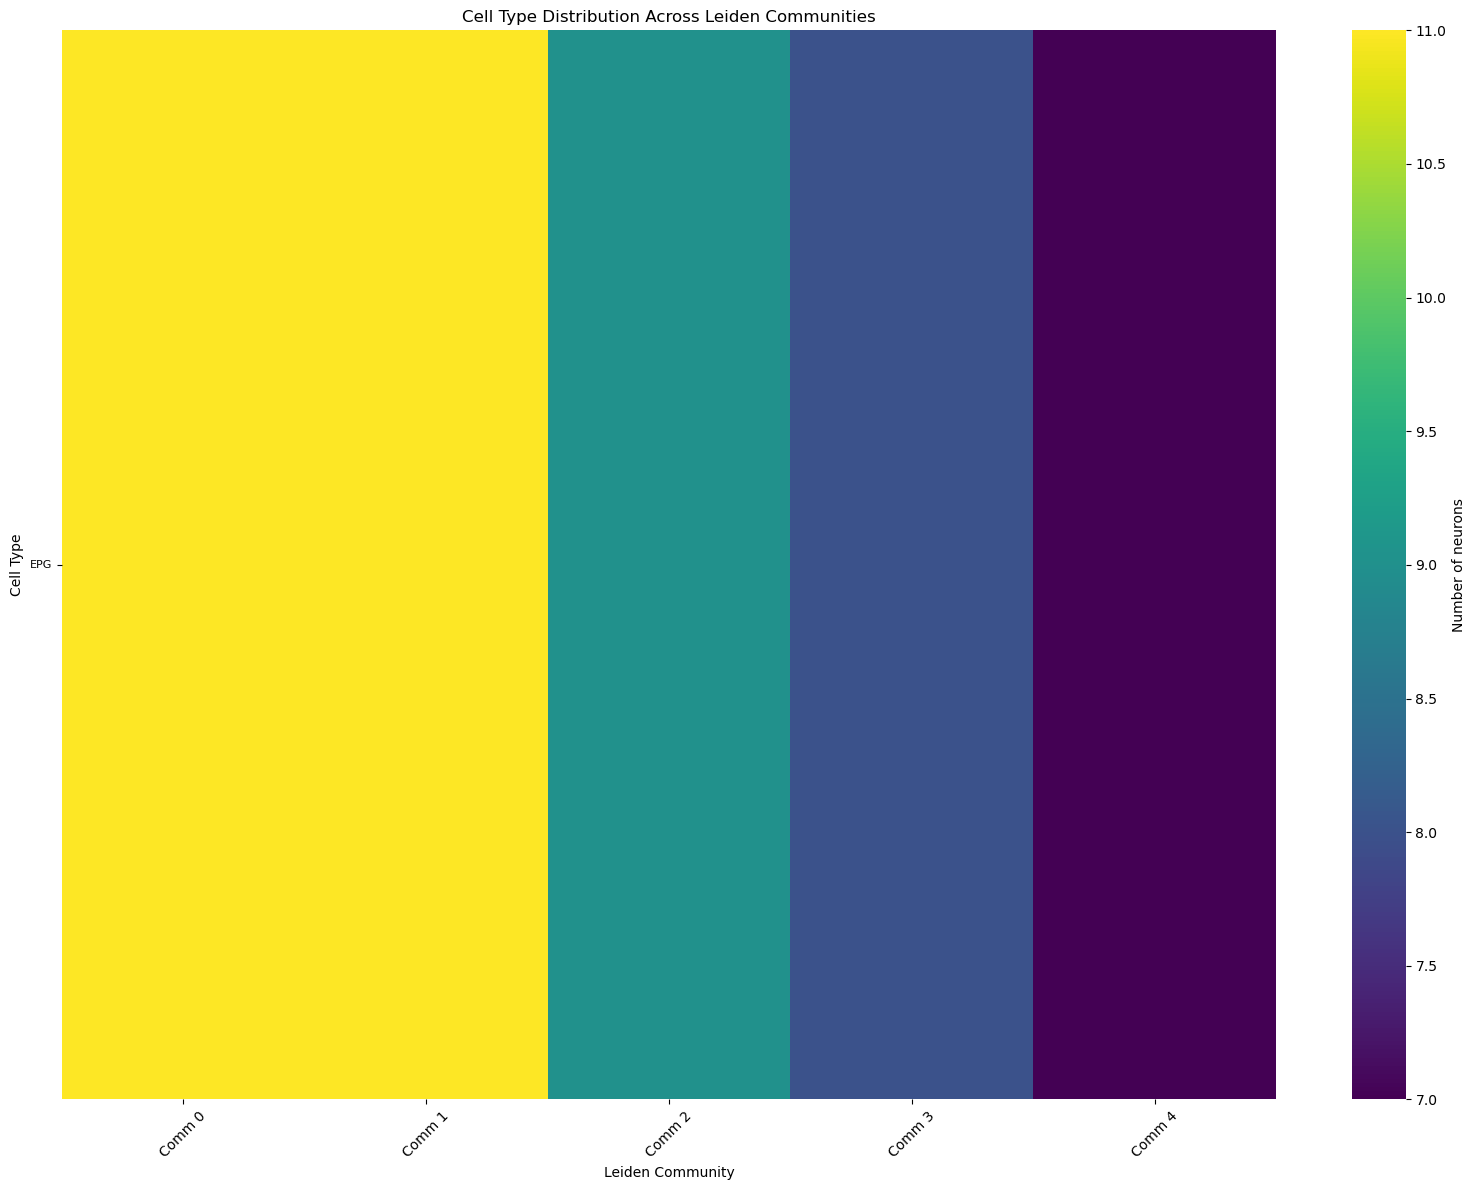

Leiden distribution matrix shape: (1, 5)
Non-zero entries in distribution matrix: 5
Cell types split across multiple communities: 1/1
Average community purity: 1.000
Community purity range: 1.000 - 1.000


In [119]:
# Create 2D heatmap for Leiden method (if available)
# Create a matrix: rows = cell types, columns = Leiden communities
n_leiden_communities = len(leiden_communities)

# Initialize the distribution matrix
leiden_distribution_matrix = np.zeros((n_cell_types, n_leiden_communities))

# Fill the matrix
for i, cell_type in enumerate(ctoi_grouped):
    leiden_comm = leiden_labels[i]
    cell_type_idx = unique_cell_types.index(cell_type)
    leiden_distribution_matrix[cell_type_idx, leiden_comm] += 1

# Create the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(leiden_distribution_matrix, 
            xticklabels=[f'Comm {i}' for i in range(n_leiden_communities)],
            yticklabels=unique_cell_types,
            cmap='viridis',
            annot=False,
            fmt='g',
            cbar_kws={'label': 'Number of neurons'})

plt.title('Cell Type Distribution Across Leiden Communities')
plt.xlabel('Leiden Community')
plt.ylabel('Cell Type')
plt.xticks(rotation=45)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Show statistics about the distribution
print(f"Leiden distribution matrix shape: {leiden_distribution_matrix.shape}")
print(f"Non-zero entries in distribution matrix: {np.count_nonzero(leiden_distribution_matrix)}")

# Calculate how many cell types are split across multiple communities
leiden_split_cell_types = 0
for i in range(n_cell_types):
    if np.count_nonzero(leiden_distribution_matrix[i, :]) > 1:
        leiden_split_cell_types += 1

print(f"Cell types split across multiple communities: {leiden_split_cell_types}/{n_cell_types}")

# Calculate community purity
leiden_community_purity = []
for j in range(n_leiden_communities):
    if leiden_distribution_matrix[:, j].sum() > 0:
        purity = leiden_distribution_matrix[:, j].max() / leiden_distribution_matrix[:, j].sum()
        leiden_community_purity.append(purity)

print(f"Average community purity: {np.mean(leiden_community_purity):.3f}")
print(f"Community purity range: {np.min(leiden_community_purity):.3f} - {np.max(leiden_community_purity):.3f}")

### Checkpoint

In [120]:
### Checkpoint
variables_to_keep = ['ctoi_grouped', 'noi_grouped', 'C_signed_grouped', 'C_unsigned_grouped', 'new_order', 'unique_cell_types', 'cell_type_counts',
                     'D_out', 'D_in', 'L_out', 'L_in', 'L_rw', 'A_sym', 'D_sym', 'L_sym', 'L_bal',
                     'P_hat', 'L_hat', 'K_hat', 'rho_hat', 'bilrg', 'P_group', 'L_group', 'A_group', 'P_galerkin', 'L_galerkin', 'A_galerkin', 'bilrg_labels',
                     'louvain_communities', 'louvain_labels', 'louvain_modularity', 'leiden_communities', 'leiden_labels', 'leiden_modularity']
print("Variables to keep for further analysis:")
for var in variables_to_keep:
    if var in globals():
        var_obj = globals()[var]
        var_type = type(var_obj).__name__
        
        if hasattr(var_obj, 'shape'):
            structure = f"shape: {var_obj.shape}"
        elif hasattr(var_obj, '__len__'):
            structure = f"length: {len(var_obj)}"
        else:
            structure = "scalar"
            
        print(f"\t{var}: {var_type}, {structure}")
    else:
        print(f"\t{var}: NOT FOUND")

Variables to keep for further analysis:
	ctoi_grouped: list, length: 46
	noi_grouped: list, length: 46
	C_signed_grouped: ndarray, shape: (46, 46)
	C_unsigned_grouped: ndarray, shape: (46, 46)
	new_order: list, length: 46
	unique_cell_types: list, length: 1
	cell_type_counts: dict, length: 1
	D_out: ndarray, shape: (46, 46)
	D_in: ndarray, shape: (46, 46)
	L_out: ndarray, shape: (46, 46)
	L_in: ndarray, shape: (46, 46)
	L_rw: ndarray, shape: (46, 46)
	A_sym: ndarray, shape: (46, 46)
	D_sym: ndarray, shape: (46, 46)
	L_sym: ndarray, shape: (46, 46)
	L_bal: ndarray, shape: (46, 46)
	P_hat: ndarray, shape: (46, 46)
	L_hat: ndarray, shape: (46, 46)
	K_hat: ndarray, shape: (46, 46)
	rho_hat: ndarray, shape: (46, 46)
	bilrg: BiLRG, scalar
	P_group: ndarray, shape: (16, 16)
	L_group: ndarray, shape: (16, 16)
	A_group: ndarray, shape: (16, 16)
	P_galerkin: ndarray, shape: (16, 16)
	L_galerkin: ndarray, shape: (16, 16)
	A_galerkin: ndarray, shape: (16, 16)
	bilrg_labels: ndarray, shape: (46,)
	

### Degree-corrected SBM

In [121]:
K = k  # Number of blocks

In [122]:
# Prepare the adjacency matrix A for DC-SBM fitting
# Use the Delta7+EPG subset connectivity matrix (87 x 87)
# A_dcsbm = C_unsigned_grouped.copy()
# A_dcsbm = A_sym
A_dcsbm = A.copy()

print(f"Input matrix A shape: {A_dcsbm.shape}")
print(f"Matrix type: {type(A_dcsbm)}")
print(f"Number of non-zero entries: {np.count_nonzero(A_dcsbm)}")
print(f"Matrix density: {np.count_nonzero(A_dcsbm) / (A_dcsbm.shape[0] * A_dcsbm.shape[1]):.3f}")

# Verify matrix properties
print(f"\nMatrix statistics:")
print(f"Min value: {A_dcsbm.min()}")
print(f"Max value: {A_dcsbm.max()}")
print(f"Mean value: {A_dcsbm.mean():.3f}")

# Compute degrees
k_out, k_in = degrees(A_dcsbm)
print(f"\nDegree statistics:")
print(f"Out-degree range: [{k_out.min():.0f}, {k_out.max():.0f}]")
print(f"In-degree range: [{k_in.min():.0f}, {k_in.max():.0f}]")
print(f"Mean out-degree: {k_out.mean():.2f}")
print(f"Mean in-degree: {k_in.mean():.2f}")

Input matrix A shape: (46, 46)
Matrix type: <class 'numpy.ndarray'>
Number of non-zero entries: 632
Matrix density: 0.299

Matrix statistics:
Min value: 0.0
Max value: 72.0
Mean value: 3.657

Degree statistics:
Out-degree range: [100, 238]
In-degree range: [101, 250]
Mean out-degree: 168.24
Mean in-degree: 168.24


In [123]:
# Split data into training and validation sets
print("Splitting data for cross-validation...")
A_train, A_val, mask_val = heldout_split(A_dcsbm, frac=0.1, stratify_degrees=True, seed=42)

print(f"Original matrix: {A_dcsbm.shape}, {np.count_nonzero(A_dcsbm)} non-zeros")
print(f"Training matrix: {A_train.shape}, {np.count_nonzero(A_train.toarray())} non-zeros")
print(f"Validation matrix: {A_val.shape}, {np.count_nonzero(A_val.toarray())} non-zeros")
print(f"Validation mask: {mask_val.shape}, {np.count_nonzero(mask_val.toarray())} entries")

# Verify split
total_train = np.count_nonzero(A_train.toarray())
total_val = np.count_nonzero(A_val.toarray())
total_orig = np.count_nonzero(A_dcsbm)
print(f"\nSplit verification:")
print(f"Train + validation edges: {total_train + total_val} (original: {total_orig})")
print(f"Held-out fraction: {total_val / total_orig:.3f}")

Splitting data for cross-validation...
Original matrix: (46, 46), 632 non-zeros
Training matrix: (46, 46), 572 non-zeros
Validation matrix: (46, 46), 60 non-zeros
Validation mask: (46, 46), 60 entries

Split verification:
Train + validation edges: 632 (original: 632)
Held-out fraction: 0.095


In [124]:
# Fit DC-SBM
# Initialize model
dcsbm = DCSBM(K=K, max_iter=200, tol=1e-4, seed=42, init="spectral")

# Fit the model
dcsbm.fit(A_train)

# Print results
print(f"Converged: {dcsbm.converged_}")
print(f"Number of iterations: {dcsbm.n_iter_}")
print(f"Final ELBO: {dcsbm.elbo_[-1]:.4f}")

# Get block assignments
dcsbm_labels = dcsbm.predict()
print(f"\nBlock assignments:")
for block_id in range(K):
    block_size = np.sum(dcsbm_labels == block_id)
    print(f"Block {block_id}: {block_size} nodes")

# Analyze block composition by cell type
print(f"\nBlock composition by cell type:")
for block_id in range(K):
    block_mask = dcsbm_labels == block_id
    block_cell_types = [ctoi_grouped[i] for i in range(len(ctoi_grouped)) if block_mask[i]]
    cell_type_counts_block = {ct: block_cell_types.count(ct) for ct in set(block_cell_types)}
    print(f"Block {block_id}: {dict(sorted(cell_type_counts_block.items()))}")

# Get model parameters
params = dcsbm.get_params()
print(f"\nModel parameters:")
print(f"Omega (block-block rates):")
print(params['Omega'])
print(f"Block proportions (pi): {params['pi']}")

Converged: True
Number of iterations: 4
Final ELBO: 12691.7621

Block assignments:
Block 0: 5 nodes
Block 1: 4 nodes
Block 2: 2 nodes
Block 3: 3 nodes
Block 4: 2 nodes
Block 5: 3 nodes
Block 6: 3 nodes
Block 7: 2 nodes
Block 8: 4 nodes
Block 9: 4 nodes
Block 10: 3 nodes
Block 11: 1 nodes
Block 12: 1 nodes
Block 13: 5 nodes
Block 14: 2 nodes
Block 15: 2 nodes

Block composition by cell type:
Block 0: {'EPG': 5}
Block 1: {'EPG': 4}
Block 2: {'EPG': 2}
Block 3: {'EPG': 3}
Block 4: {'EPG': 2}
Block 5: {'EPG': 3}
Block 6: {'EPG': 3}
Block 7: {'EPG': 2}
Block 8: {'EPG': 4}
Block 9: {'EPG': 4}
Block 10: {'EPG': 3}
Block 11: {'EPG': 1}
Block 12: {'EPG': 1}
Block 13: {'EPG': 5}
Block 14: {'EPG': 2}
Block 15: {'EPG': 2}

Model parameters:
Omega (block-block rates):
[[4.69000000e+02 8.66582378e-11 6.68215827e-11 2.00000000e+00
  6.32273637e-11 8.14436284e-11 7.33267582e-11 3.40000000e+01
  1.50000000e+02 8.57049756e-11 4.00000000e+01 5.68307735e-11
  7.00574734e-11 5.00000000e+00 7.30000000e+01 6

Model Evaluation
Held-out log-likelihood: -3.2075
Training log-likelihood: 22.4378


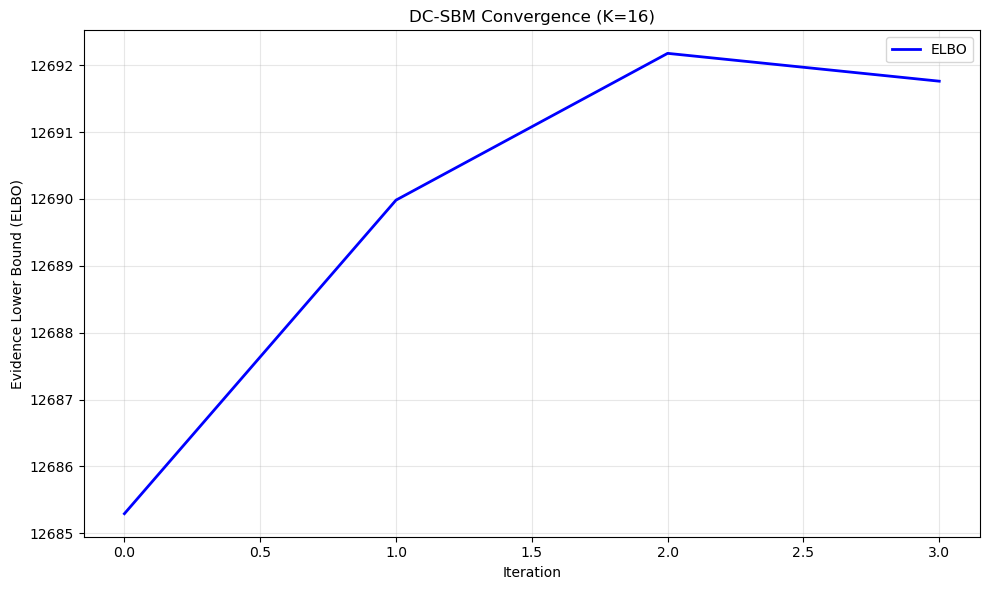


Diagnostics:
ELBO increased monotonically: False
ELBO improvement: 6.4701

Soft membership analysis:
Q matrix shape: (46, 16)
Q row sums (should be ~1): min=1.000000, max=1.000000
Assignment confidence: mean=0.997, min=0.878
Neurons with soft assignments (confidence < 0.8): 0/46


In [125]:
# Evaluate model performance
print("Model Evaluation")
print("=" * 50)

# Compute validation score
val_score = dcsbm.score(A_val, mask=mask_val)
print(f"Held-out log-likelihood: {val_score:.4f}")

# Compute training score for comparison
train_score = dcsbm.score(A_train)
print(f"Training log-likelihood: {train_score:.4f}")

# Plot ELBO convergence
plt.figure(figsize=(10, 6))
plt.plot(dcsbm.elbo_, 'b-', linewidth=2, label='ELBO')
plt.xlabel('Iteration')
plt.ylabel('Evidence Lower Bound (ELBO)')
plt.title(f'DC-SBM Convergence (K={K})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print diagnostic information
diagnostics = dcsbm.diagnostics()
print(f"\nDiagnostics:")
print(f"ELBO increased monotonically: {all(diagnostics['elbo_trace'][i+1] >= diagnostics['elbo_trace'][i] - 1e-6 for i in range(len(diagnostics['elbo_trace'])-1))}")
print(f"ELBO improvement: {diagnostics['elbo_trace'][-1] - diagnostics['elbo_trace'][0]:.4f}")

# Analyze soft membership matrix
Q = params['Q']
print(f"\nSoft membership analysis:")
print(f"Q matrix shape: {Q.shape}")
print(f"Q row sums (should be ~1): min={Q.sum(axis=1).min():.6f}, max={Q.sum(axis=1).max():.6f}")

# Show degree of "soft" vs "hard" assignments
assignment_confidence = Q.max(axis=1)
print(f"Assignment confidence: mean={assignment_confidence.mean():.3f}, min={assignment_confidence.min():.3f}")
soft_assignments = np.sum(assignment_confidence < 0.8)
print(f"Neurons with soft assignments (confidence < 0.8): {soft_assignments}/{len(dcsbm_labels)}")

Visualization of DC-SBM Results


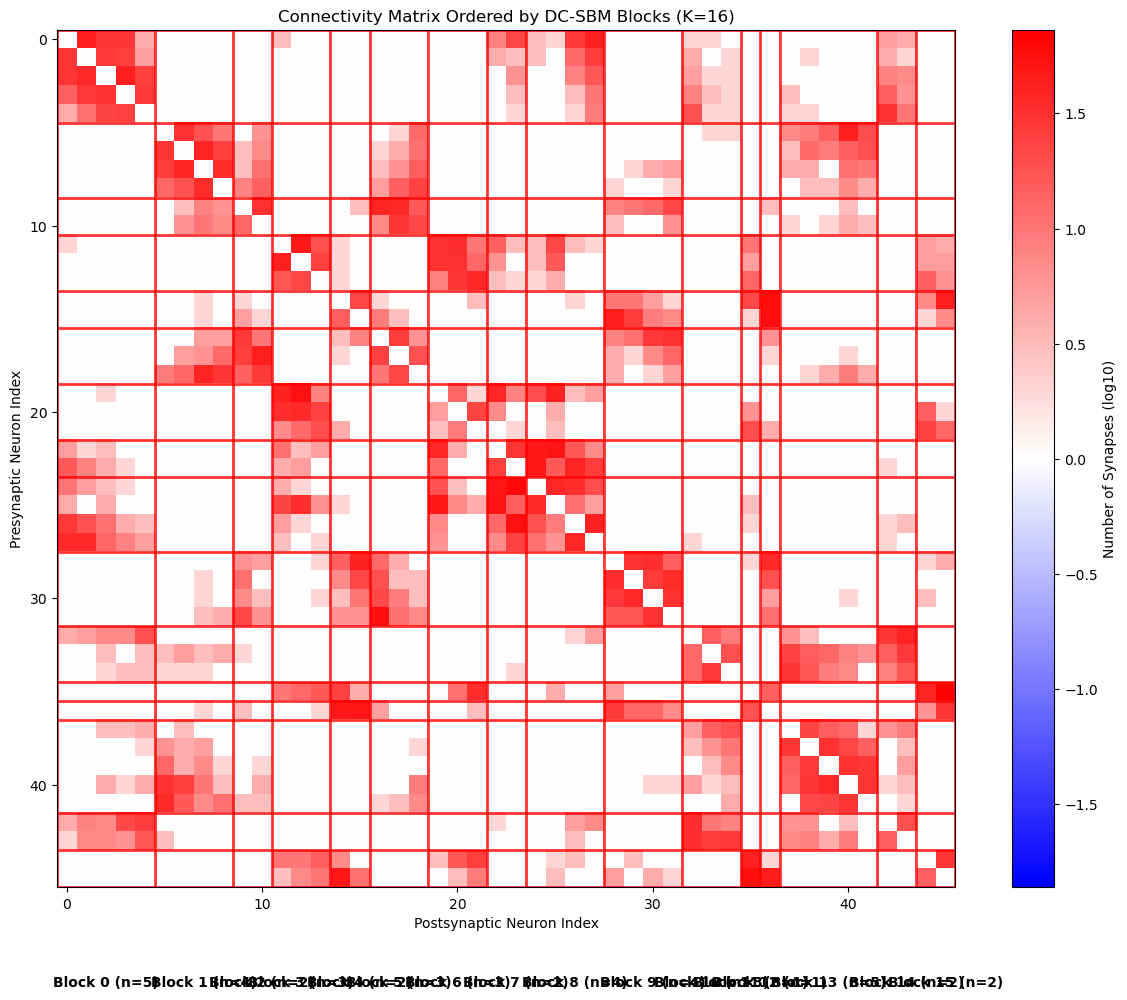


Comparison with biological cell types:
Original cell types: 1 (Delta7, EPG)
DC-SBM blocks: 16


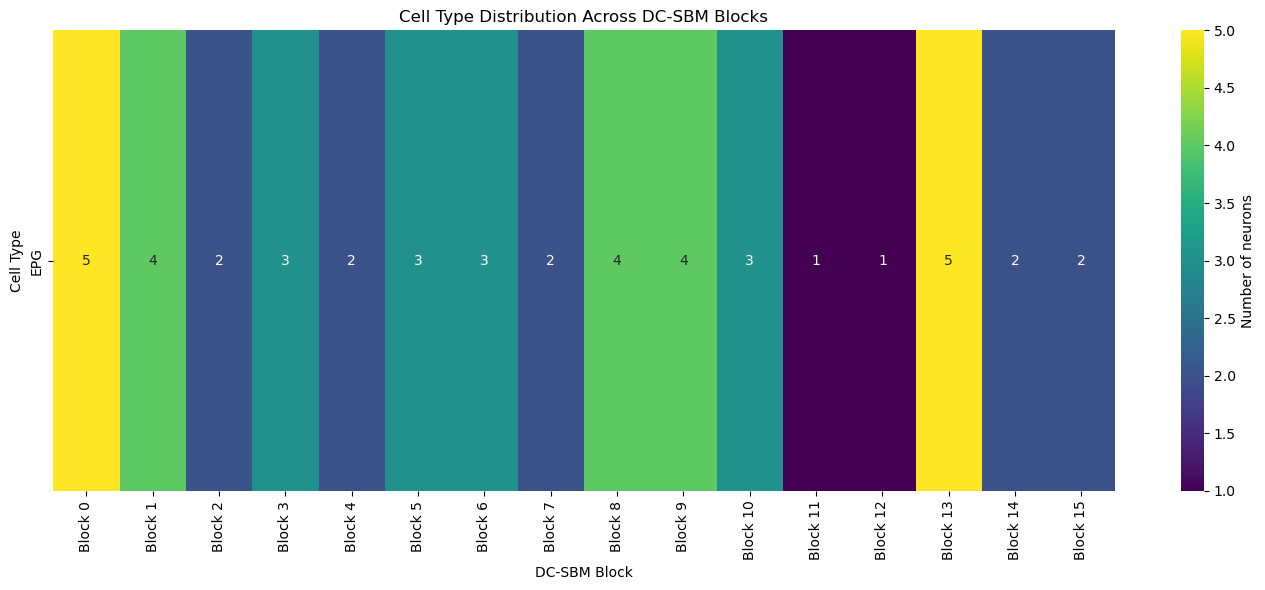


Contingency table (cell types vs DC-SBM blocks):
Cell Type  Block 0  Block 1  Block 2  Block 3  Block 4  Block 5  Block 6  Block 7  Block 8  Block 9  Block 10 Block 11 Block 12 Block 13 Block 14 Block 15 
----------------------------------------------------------------------------------------------------------------------------------------------------------
EPG               5        4        2        3        2        3        3        2        4        4        3        1        1        5        2        2 

Block purity analysis:
Block 0: 1.000 purity (dominant: EPG)
Block 1: 1.000 purity (dominant: EPG)
Block 2: 1.000 purity (dominant: EPG)
Block 3: 1.000 purity (dominant: EPG)
Block 4: 1.000 purity (dominant: EPG)
Block 5: 1.000 purity (dominant: EPG)
Block 6: 1.000 purity (dominant: EPG)
Block 7: 1.000 purity (dominant: EPG)
Block 8: 1.000 purity (dominant: EPG)
Block 9: 1.000 purity (dominant: EPG)
Block 10: 1.000 purity (dominant: EPG)
Block 11: 1.000 purity (dominant: EPG)
B

In [126]:
# Visualize DC-SBM results
print("Visualization of DC-SBM Results")
print("=" * 50)

# Create ordering based on DC-SBM block assignments
dcsbm_order = []
for block_id in range(K):
    block_nodes = np.where(dcsbm_labels == block_id)[0]
    dcsbm_order.extend(sorted(block_nodes))

# Reorder the matrix by DC-SBM blocks
A_dcsbm_ordered = A_dcsbm[np.ix_(dcsbm_order, dcsbm_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(A_dcsbm_ordered + 1), 
           cmap='bwr', aspect='auto',
           vmin=-np.max(np.log10(A_dcsbm_ordered + 1)),
           vmax=np.max(np.log10(A_dcsbm_ordered + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Connectivity Matrix Ordered by DC-SBM Blocks (K={K})')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add block boundaries
block_boundaries = np.cumsum([0] + [np.sum(dcsbm_labels == i) for i in range(K)])
for b in block_boundaries:
    plt.axhline(y=b-0.5, color='red', linewidth=2, alpha=0.8)
    plt.axvline(x=b-0.5, color='red', linewidth=2, alpha=0.8)

# Add text annotations for blocks
for block_id in range(K):
    block_size = np.sum(dcsbm_labels == block_id)
    center_pos = (np.sum(dcsbm_labels == block_id) // 2) + (0 if block_id == 0 else block_boundaries[block_id])
    plt.text(center_pos, len(dcsbm_labels)+5, f'Block {block_id} (n={block_size})', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Compare DC-SBM blocks with cell types
print(f"\nComparison with biological cell types:")
print(f"Original cell types: {len(unique_cell_types)} (Delta7, EPG)")
print(f"DC-SBM blocks: {len(np.unique(dcsbm_labels))}")

# Create contingency table
contingency = np.zeros((len(unique_cell_types), K))
for i, cell_type in enumerate(ctoi_grouped):
    block_id = dcsbm_labels[i]
    cell_type_idx = unique_cell_types.index(cell_type)
    contingency[cell_type_idx, block_id] += 1

# Visualize contingency table as a heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(contingency, 
            xticklabels=[f'Block {i}' for i in range(K)],
            yticklabels=unique_cell_types,
            cmap='viridis',
            annot=True,
            fmt='g',
            cbar_kws={'label': 'Number of neurons'})
plt.title('Cell Type Distribution Across DC-SBM Blocks')
plt.xlabel('DC-SBM Block')
plt.ylabel('Cell Type')
plt.tight_layout()
plt.show()

print(f"\nContingency table (cell types vs DC-SBM blocks):")
print(f"{'Cell Type':<10}", end=' ')
for block_id in range(K):
    print(f"{'Block ' + str(block_id):<8}", end=' ')
print()
print("-" * (10 + 9 * K))
for i, cell_type in enumerate(unique_cell_types):
    print(f"{cell_type:<10}", end=' ')
    for block_id in range(K):
        print(f"{contingency[i, block_id]:>8.0f}", end=' ')
    print()

# Calculate block purity with respect to cell types
print(f"\nBlock purity analysis:")
for block_id in range(K):
    block_neurons = np.sum(dcsbm_labels == block_id)
    max_cell_type_in_block = contingency[:, block_id].max()
    purity = max_cell_type_in_block / block_neurons if block_neurons > 0 else 0
    dominant_cell_type = unique_cell_types[np.argmax(contingency[:, block_id])]
    print(f"Block {block_id}: {purity:.3f} purity (dominant: {dominant_cell_type})")

Visualization of DC-SBM Results


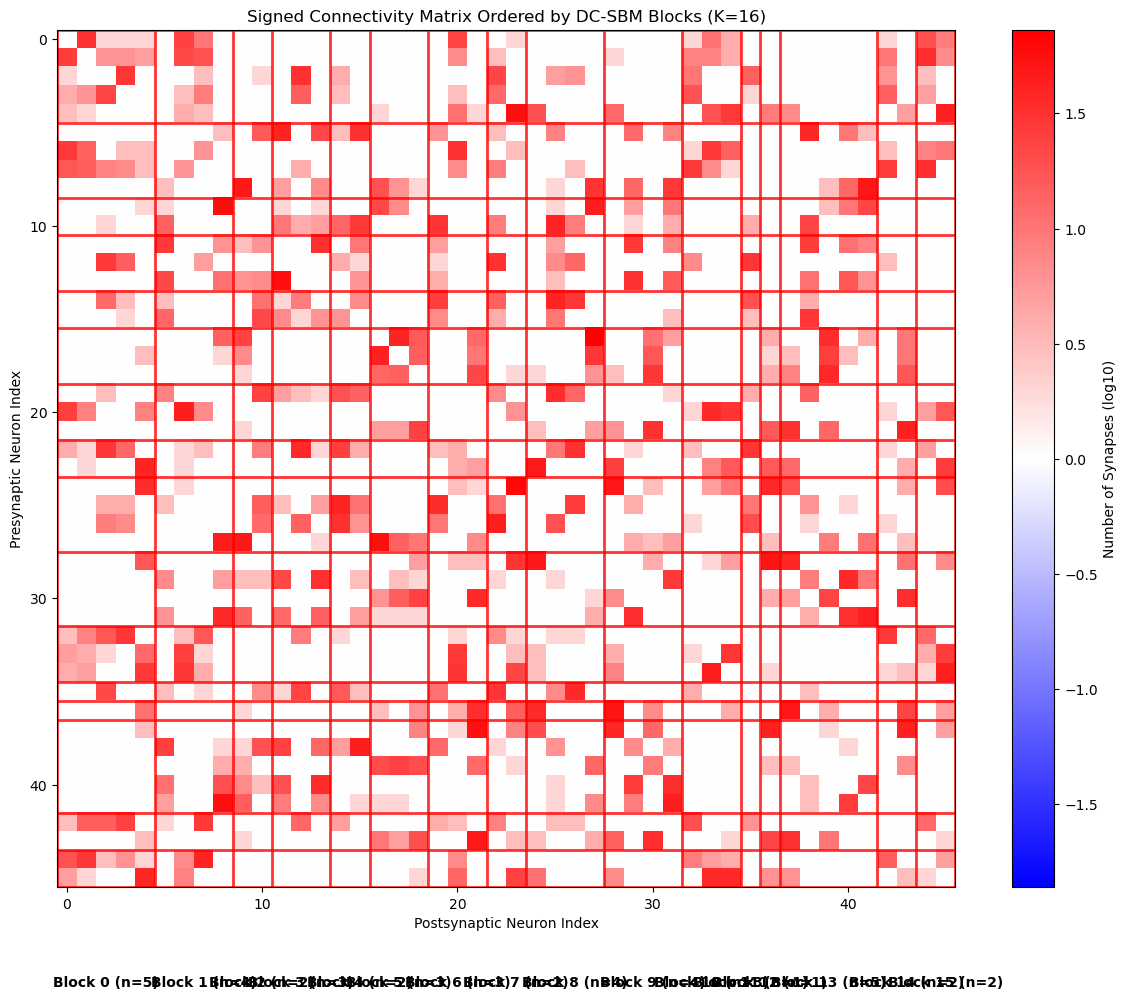

In [127]:
# Visualize DC-SBM results
print("Visualization of DC-SBM Results")
print("=" * 50)

# Create ordering based on DC-SBM block assignments
dcsbm_order = []
for block_id in range(K):
    block_nodes = np.where(dcsbm_labels == block_id)[0]
    dcsbm_order.extend(sorted(block_nodes))

# Reorder the matrix by DC-SBM blocks
A_dcsbm_signed = C_signed_grouped
A_dcsbm_signed_ordered = A_dcsbm_signed[np.ix_(dcsbm_order, dcsbm_order)]

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(np.abs(A_dcsbm_signed_ordered) + 1) * np.sign(A_dcsbm_signed_ordered), 
           cmap='bwr', aspect='auto',
           vmin=-np.max(np.log10(np.abs(A_dcsbm_signed_ordered) + 1)),
           vmax=np.max(np.log10(np.abs(A_dcsbm_signed_ordered) + 1)),
           interpolation='none')
plt.colorbar(label='Number of Synapses (log10)')
plt.title(f'Signed Connectivity Matrix Ordered by DC-SBM Blocks (K={K})')
plt.xlabel('Postsynaptic Neuron Index')
plt.ylabel('Presynaptic Neuron Index')

# Add block boundaries
block_boundaries = np.cumsum([0] + [np.sum(dcsbm_labels == i) for i in range(K)])
for b in block_boundaries:
    plt.axhline(y=b-0.5, color='red', linewidth=2, alpha=0.8)
    plt.axvline(x=b-0.5, color='red', linewidth=2, alpha=0.8)

# Add text annotations for blocks
for block_id in range(K):
    block_size = np.sum(dcsbm_labels == block_id)
    center_pos = (np.sum(dcsbm_labels == block_id) // 2) + (0 if block_id == 0 else block_boundaries[block_id])
    plt.text(center_pos, len(dcsbm_labels)+5, f'Block {block_id} (n={block_size})', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Checkpoint

In [128]:
### Checkpoint
variables_to_keep = ['ctoi_grouped', 'noi_grouped', 'C_signed_grouped', 'C_unsigned_grouped', 'new_order', 'unique_cell_types', 'cell_type_counts',
                     'D_out', 'D_in', 'L_out', 'L_in', 'L_rw', 'A_sym', 'D_sym', 'L_sym', 'L_bal',
                     'P_hat', 'L_hat', 'K_hat', 'rho_hat', 'bilrg', 'P_group', 'L_group', 'A_group', 'P_galerkin', 'L_galerkin', 'A_galerkin', 'bilrg_labels',
                     'louvain_communities', 'louvain_labels', 'louvain_modularity', 'leiden_communities', 'leiden_labels', 'leiden_modularity',
                     'dcsbm', 'dcsbm_labels']
print("Variables to keep for further analysis:")
for var in variables_to_keep:
    if var in globals():
        var_obj = globals()[var]
        var_type = type(var_obj).__name__
        
        if hasattr(var_obj, 'shape'):
            structure = f"shape: {var_obj.shape}"
        elif hasattr(var_obj, '__len__'):
            structure = f"length: {len(var_obj)}"
        else:
            structure = "scalar"
            
        print(f"\t{var}: {var_type}, {structure}")
    else:
        print(f"\t{var}: NOT FOUND")

Variables to keep for further analysis:
	ctoi_grouped: list, length: 46
	noi_grouped: list, length: 46
	C_signed_grouped: ndarray, shape: (46, 46)
	C_unsigned_grouped: ndarray, shape: (46, 46)
	new_order: list, length: 46
	unique_cell_types: list, length: 1
	cell_type_counts: dict, length: 1
	D_out: ndarray, shape: (46, 46)
	D_in: ndarray, shape: (46, 46)
	L_out: ndarray, shape: (46, 46)
	L_in: ndarray, shape: (46, 46)
	L_rw: ndarray, shape: (46, 46)
	A_sym: ndarray, shape: (46, 46)
	D_sym: ndarray, shape: (46, 46)
	L_sym: ndarray, shape: (46, 46)
	L_bal: ndarray, shape: (46, 46)
	P_hat: ndarray, shape: (46, 46)
	L_hat: ndarray, shape: (46, 46)
	K_hat: ndarray, shape: (46, 46)
	rho_hat: ndarray, shape: (46, 46)
	bilrg: BiLRG, scalar
	P_group: ndarray, shape: (16, 16)
	L_group: ndarray, shape: (16, 16)
	A_group: ndarray, shape: (16, 16)
	P_galerkin: ndarray, shape: (16, 16)
	L_galerkin: ndarray, shape: (16, 16)
	A_galerkin: ndarray, shape: (16, 16)
	bilrg_labels: ndarray, shape: (46,)
	

### Role similarity

### Reduced dynamics

#### Balanced truncation

#### Koopman mode decomposition

## System identification

### Linearized ct-RNN

In [155]:
# W = C_signed_grouped.T
W = C_signed_seriated.T
# group_labels = bilrg_labels  # use either bilrg_labels, louvain_labels, leiden_labels or dcsbm_labels
# group_labels = dcsbm_labels
# group_labels = louvain_labels
group_labels = leiden_labels
# single_group_labels = np.zeros(len(ctoi_grouped), dtype=int)
# group_labels = single_group_labels

print(f"Weight matrix W shape: {W.shape}")
print(f"Weight matrix range: [{W.min():.3f}, {W.max():.3f}]")
print(f"Number of positive weights: {np.sum(W > 0)}")
print(f"Number of negative weights: {np.sum(W < 0)}")
print(f"Density: {np.count_nonzero(W) / W.size:.3f}")

# Analyze group structure
unique_groups = np.unique(group_labels)
print(f"\nGroup structure ({len(unique_groups)} groups):")
for group_id in unique_groups:
    group_size = np.sum(group_labels == group_id)
    print(f"  Group {group_id}: {group_size} neurons")

Weight matrix W shape: (46, 46)
Weight matrix range: [0.000, 72.000]
Number of positive weights: 632
Number of negative weights: 0
Density: 0.299

Group structure (5 groups):
  Group 0: 11 neurons
  Group 1: 11 neurons
  Group 2: 9 neurons
  Group 3: 8 neurons
  Group 4: 7 neurons


In [156]:
# CTRNN Analysis Pipeline
print("\n" + "="*50)
print("Running CTRNN Analysis Pipeline")
print("="*50)

# Initialize CTRNN analyzer
ctrnn = CTRNNAnalyzer(
    safety_margin=0.9,      # c = 0.9 for global contraction
    tolerance=1e-6,         # Convergence tolerance  
    damping=0.5,           # Damping factor η for Picard iteration
    max_iterations=1000     # Maximum iterations
)

print("CTRNN Analyzer Parameters:")
print(f"  Safety margin (c): {ctrnn.safety_margin}")
print(f"  Convergence tolerance: {ctrnn.tolerance}")
print(f"  Damping factor (η): {ctrnn.damping}")
print(f"  Maximum iterations: {ctrnn.max_iterations}")

# Define system parameters
bias = np.zeros(W.shape[0])  # No external bias
time_constants = 1.0         # Uniform time constant τ = 1.0
np.random.seed(42)
input_weights = np.random.randn(W.shape[0], 3) * 0.1  # 3 external inputs

print(f"\nSystem Configuration:")
print(f"  Bias vector: zero (shape {bias.shape})")
print(f"  Time constants: {time_constants} (uniform)")
print(f"  Input weights shape: {input_weights.shape}")

# Execute complete analysis pipeline
print(f"\nExecuting CTRNN Analysis Pipeline:")
print("  Step 1: Global row-sum normalization...")
print("  Step 2: Per-block fixed-point computation...")
print("  Step 3: Local sigmoid gains computation...")
print("  Step 4: Linearized dynamics construction...")
print("  Step 5: Optional analyses (eigen, Schur, balanced truncation)...")

ctrnn_results = ctrnn.analyze(
    W=W,
    block_labels=group_labels,
    bias=bias,
    time_constants=time_constants,
    input_weights=input_weights,
    perform_optional_analyses=True
)

print("✓ CTRNN analysis completed successfully!")


Running CTRNN Analysis Pipeline
CTRNN Analyzer Parameters:
  Safety margin (c): 0.9
  Convergence tolerance: 1e-06
  Damping factor (η): 0.5
  Maximum iterations: 1000

System Configuration:
  Bias vector: zero (shape (46,))
  Time constants: 1.0 (uniform)
  Input weights shape: (46, 3)

Executing CTRNN Analysis Pipeline:
  Step 1: Global row-sum normalization...
  Step 2: Per-block fixed-point computation...
  Step 3: Local sigmoid gains computation...
  Step 4: Linearized dynamics construction...
  Step 5: Optional analyses (eigen, Schur, balanced truncation)...
✓ CTRNN analysis completed successfully!


In [157]:
# Results Analysis and Diagnostics
print("\n" + "="*50)
print("CTRNN Analysis Results")
print("="*50)

# 1. Global Normalization Results
print(f"\n1. GLOBAL NORMALIZATION:")
print(f"   Original matrix ∞-norm ||W||∞: {ctrnn_results.original_norm:.4f}")
print(f"   Normalization factor α: {ctrnn_results.normalization_factor:.6f}")
normalized_norm = np.max(np.sum(np.abs(ctrnn_results.W_normalized),axis=1))
print(f"   Normalized matrix ∞-norm: {normalized_norm:.4f}")
print(f"   Target contraction bound: {4 * ctrnn_results.safety_margin:.4f}")
print(f"   Contraction achieved: {normalized_norm <= 4 * ctrnn_results.safety_margin}")

# 2. Fixed-Point Convergence Analysis
print(f"\n2. FIXED-POINT CONVERGENCE:")
all_converged = True
for group_id, conv_info in ctrnn_results.convergence_info.items():
    print(f"   Group {group_id}:")
    print(f"     Converged: {conv_info['converged']}")
    print(f"     Iterations: {conv_info['iterations']}")
    print(f"     Final error: {conv_info['final_error']:.2e}")
    if not conv_info['converged']:
        all_converged = False

print(f"   All groups converged: {all_converged}")

# 3. Fixed-Point Statistics  
print(f"\n3. FIXED-POINT STATISTICS:")
for group_id, fp in ctrnn_results.fixed_points.items():
    print(f"   Group {group_id} (n={len(fp)}):")
    print(f"     Mean: {fp.mean():.4f}, Std: {fp.std():.4f}")
    print(f"     Range: [{fp.min():.4f}, {fp.max():.4f}]")

# 4. Sigmoid Gains Analysis
print(f"\n4. SIGMOID GAINS Γ = diag(σ'(x*)):")
for group_id, gains in ctrnn_results.sigmoid_gains.items():
    gain_diag = np.diag(gains)
    print(f"   Group {group_id}:")
    print(f"     Mean gain: {gain_diag.mean():.4f}")
    print(f"     Std gain: {gain_diag.std():.4f}")
    print(f"     Range: [{gain_diag.min():.4f}, {gain_diag.max():.4f}]")
    print(f"     Theoretical max: 0.25 (σ'(0) = 1/4)")

# 5. Linearized Dynamics Structure
print(f"\n5. LINEARIZED DYNAMICS:")
print(f"   Global system matrix A: {ctrnn_results.A_global.shape}")
print(f"   Input matrix B: {ctrnn_results.B_linear.shape if ctrnn_results.B_linear is not None else 'None'}")

for group_id, A_block in ctrnn_results.A_blocks.items():
    print(f"   Block {group_id} diagonal A_rr: {A_block.shape}")

# Count off-diagonal coupling blocks
num_coupling_blocks = len(ctrnn_results.E_blocks)
print(f"   Off-diagonal coupling blocks E_rs: {num_coupling_blocks}")

# 6. Global Stability Analysis
print(f"\n6. GLOBAL STABILITY ANALYSIS:")
stability_info = ctrnn.check_global_stability(ctrnn_results.A_global)
print(f"   System is stable: {stability_info['is_stable']}")
print(f"   Max real eigenvalue: {stability_info['max_real_eigenvalue']:.6f}")
if stability_info['stability_margin'] is not None:
    print(f"   Stability margin: {stability_info['stability_margin']:.6f}")
else:
    print(f"   Stability margin: N/A (unstable)")
print(f"   Number of unstable modes: {stability_info['num_unstable_modes']}")

# 7. Block-Level Eigenvalue Analysis
print(f"\n7. BLOCK EIGENVALUE ANALYSIS:")
for group_id, eigenvals in ctrnn_results.eigenvalues.items():
    real_eigs = np.sum(np.abs(np.imag(eigenvals)) < 1e-10)
    complex_eigs = len(eigenvals) - real_eigs
    max_real = np.max(np.real(eigenvals))
    print(f"   Group {group_id}:")
    print(f"     Real eigenvalues: {real_eigs}")
    print(f"     Complex eigenvalues: {complex_eigs}")
    print(f"     Max real part: {max_real:.6f}")
    print(f"     Block stable: {max_real < 0}")



CTRNN Analysis Results

1. GLOBAL NORMALIZATION:
   Original matrix ∞-norm ||W||∞: 250.0000
   Normalization factor α: 0.014400
   Normalized matrix ∞-norm: 3.6000
   Target contraction bound: 3.6000
   Contraction achieved: True

2. FIXED-POINT CONVERGENCE:
   Group 0:
     Converged: True
     Iterations: 31
     Final error: 8.80e-07
   Group 1:
     Converged: True
     Iterations: 30
     Final error: 9.87e-07
   Group 2:
     Converged: True
     Iterations: 31
     Final error: 9.91e-07
   Group 3:
     Converged: True
     Iterations: 32
     Final error: 6.62e-07
   Group 4:
     Converged: True
     Iterations: 30
     Final error: 7.79e-07
   All groups converged: True

3. FIXED-POINT STATISTICS:
   Group 0 (n=11):
     Mean: 1.7575, Std: 0.4113
     Range: [1.1069, 2.2898]
   Group 1 (n=11):
     Mean: 2.0839, Std: 0.4337
     Range: [1.3176, 2.8360]
   Group 2 (n=9):
     Mean: 1.4631, Std: 0.3198
     Range: [0.8675, 1.8594]
   Group 3 (n=8):
     Mean: 1.5104, Std: 0.13


Visualizing Weight Matrices:


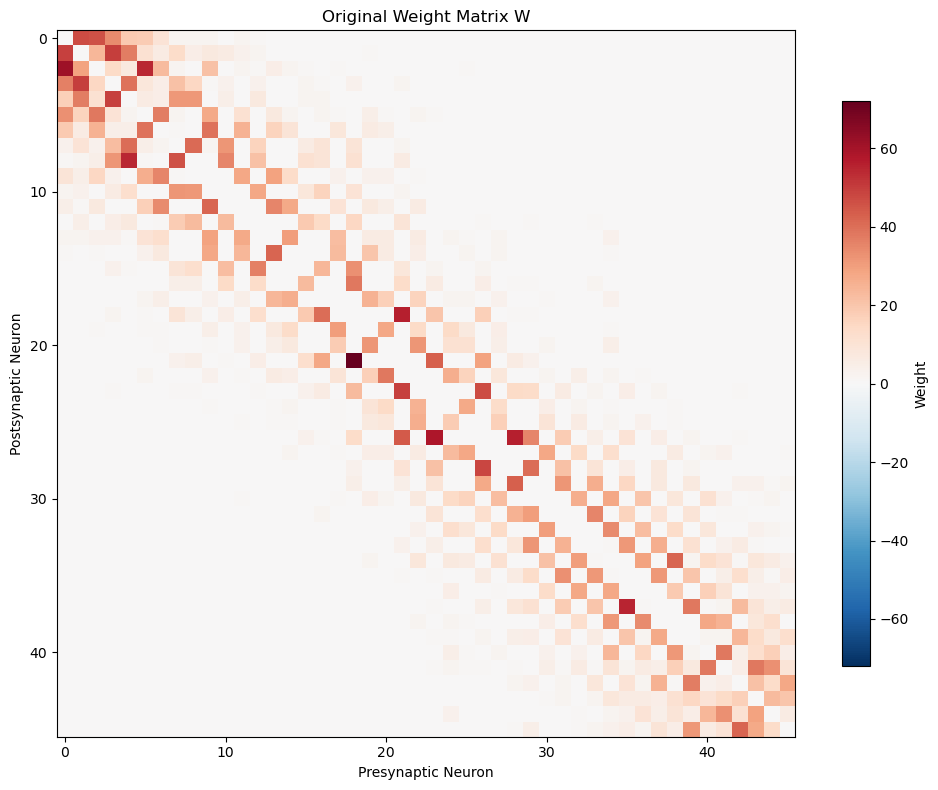

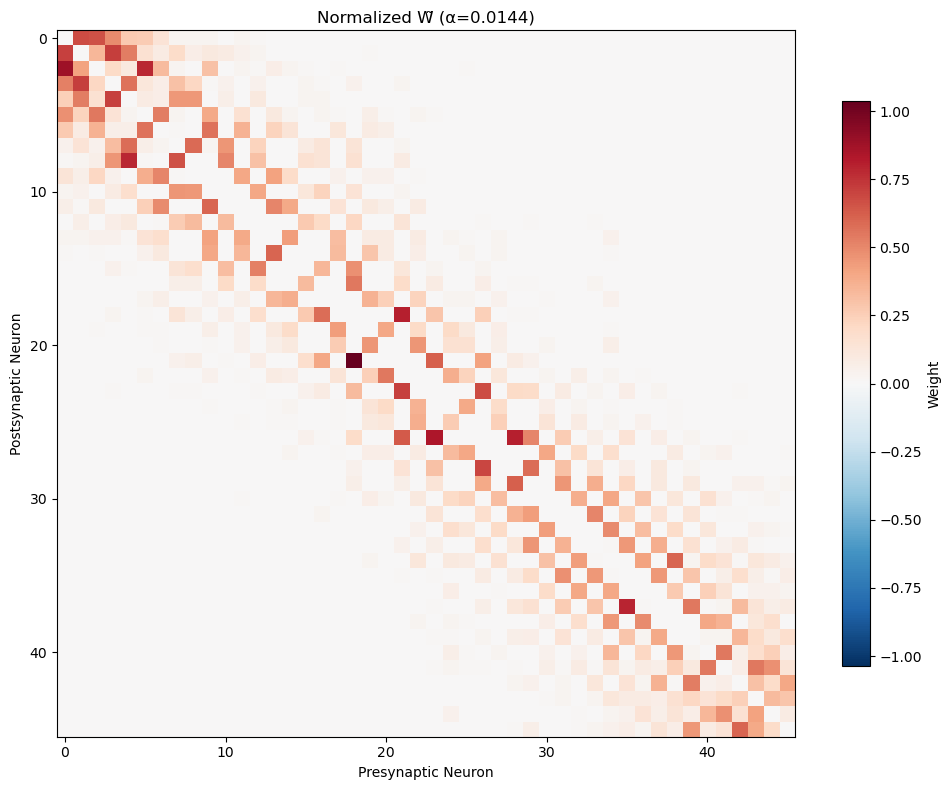

In [158]:
# Visualization of weight matrices
print("\nVisualizing Weight Matrices:")
print("=" * 50)

# Plot 1: Original Weight Matrix
plt.figure(figsize=(10, 8))
vmax = max(abs(W.min()), abs(W.max()))
plt.imshow(W, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
plt.title('Original Weight Matrix W')
plt.xlabel('Presynaptic Neuron')
plt.ylabel('Postsynaptic Neuron')
plt.colorbar(label='Weight', shrink=0.8)
plt.tight_layout()
plt.show()

# Plot 2: Normalized Weight Matrix  
plt.figure(figsize=(10, 8))
vmax_norm = max(abs(ctrnn_results.W_normalized.min()), abs(ctrnn_results.W_normalized.max()))
plt.imshow(ctrnn_results.W_normalized, cmap='RdBu_r', aspect='auto',
           vmin=-vmax_norm, vmax=vmax_norm)
plt.title(f'Normalized W̃ (α={ctrnn_results.normalization_factor:.4f})')
plt.xlabel('Presynaptic Neuron')
plt.ylabel('Postsynaptic Neuron')
plt.colorbar(label='Weight', shrink=0.8)
plt.tight_layout()
plt.show()

#### Normalization

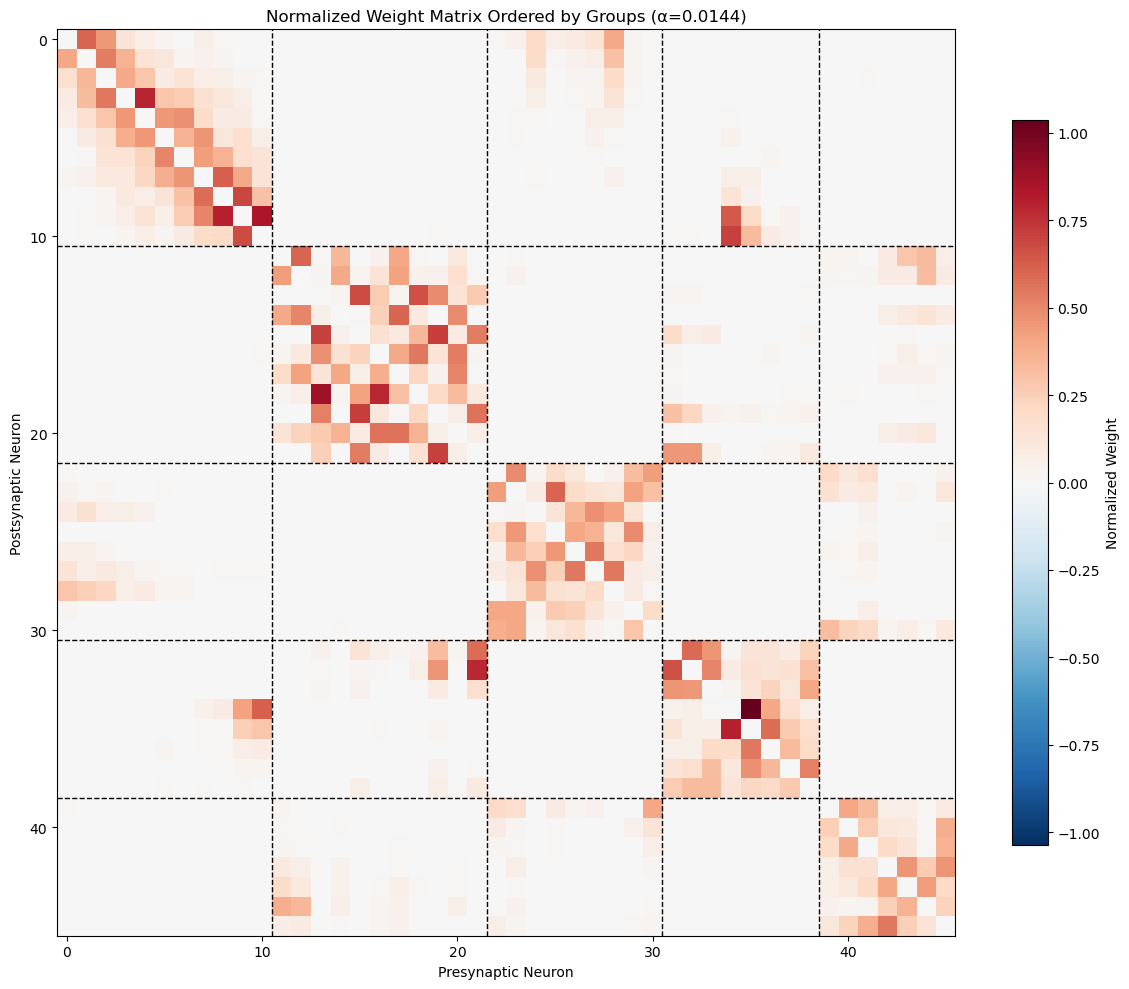

In [159]:
# Visualize the normalized weight matrix with group boundaries
# Get sort order based on group labels
node_order = np.argsort(group_labels)

# Reorder the normalized weight matrix by groups
W_normalized_ordered = ctrnn_results.W_normalized[np.ix_(node_order, node_order)]
# W_normalized_ordered = ctrnn_results.W_normalized.copy()

# Create figure
plt.figure(figsize=(12, 10))
vmax_norm = max(abs(W_normalized_ordered.min()), abs(W_normalized_ordered.max()))
plt.imshow(W_normalized_ordered, cmap='RdBu_r', aspect='auto',
           vmin=-vmax_norm, vmax=vmax_norm)
plt.colorbar(label='Normalized Weight', shrink=0.8)
plt.title(f'Normalized Weight Matrix Ordered by Groups (α={ctrnn_results.normalization_factor:.4f})')
plt.xlabel('Presynaptic Neuron')
plt.ylabel('Postsynaptic Neuron')

# Add group boundaries
unique_groups_sorted = np.unique(group_labels)
group_boundaries = []
current_pos = 0
for group_id in unique_groups_sorted:
    group_size = np.sum(group_labels == group_id)
    group_boundaries.append(current_pos + group_size)
    current_pos += group_size

# Draw lines to separate groups
for boundary in group_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='k', linestyle='--', linewidth=1)
    plt.axvline(x=boundary-0.5, color='k', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

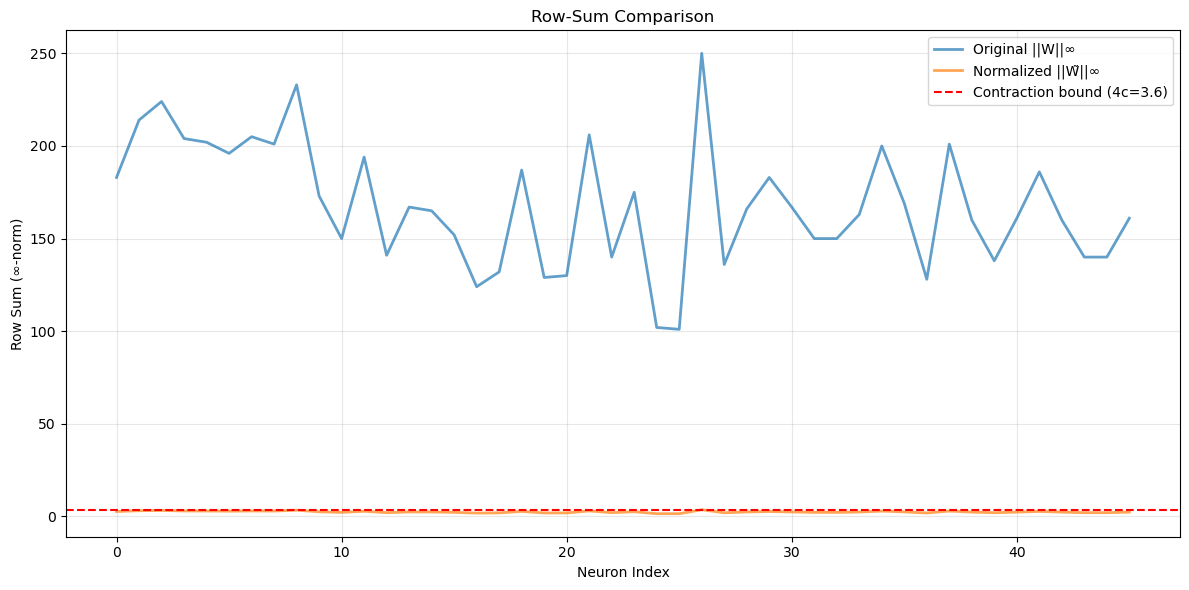

In [160]:
# Visualize row sums
original_row_sums = np.sum(np.abs(W), axis=1)
normalized_row_sums = np.sum(np.abs(ctrnn_results.W_normalized), axis=1)

plt.figure(figsize=(12, 6))
plt.plot(original_row_sums, label='Original ||W||∞', alpha=0.7, linewidth=2)
plt.plot(normalized_row_sums, label='Normalized ||W̃||∞', alpha=0.7, linewidth=2)
plt.axhline(4 * ctrnn_results.safety_margin, color='red', linestyle='--',
            label=f'Contraction bound (4c={4*ctrnn_results.safety_margin:.1f})')
plt.title('Row-Sum Comparison')
plt.xlabel('Neuron Index')
plt.ylabel('Row Sum (∞-norm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


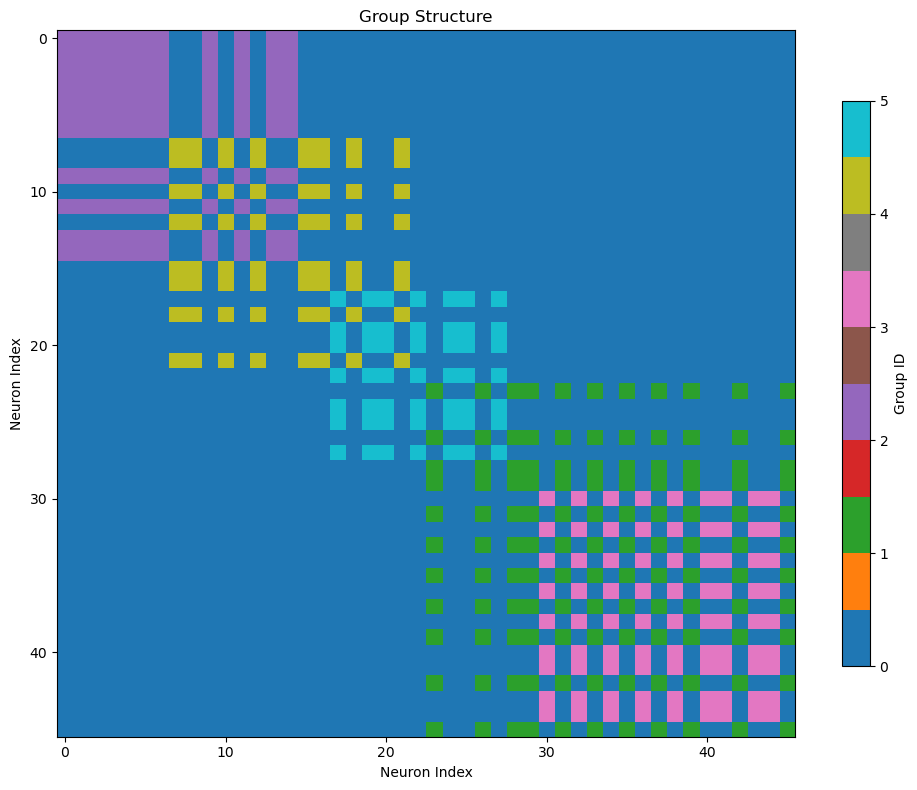

In [161]:
# Visualize group structure
plt.figure(figsize=(10, 8))

group_matrix = np.zeros_like(W)
for i in range(len(group_labels)):
    for j in range(len(group_labels)):
        if group_labels[i] == group_labels[j]:
            group_matrix[i, j] = group_labels[i] + 1

plt.imshow(group_matrix, cmap='tab10', aspect='auto')
plt.title('Group Structure')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.colorbar(label='Group ID', shrink=0.8)
plt.tight_layout()
plt.show()

In [162]:
group_labels

array([1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 4, 3, 4, 4, 3,
       4, 0, 4, 4, 0, 4, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2,
       2, 0])

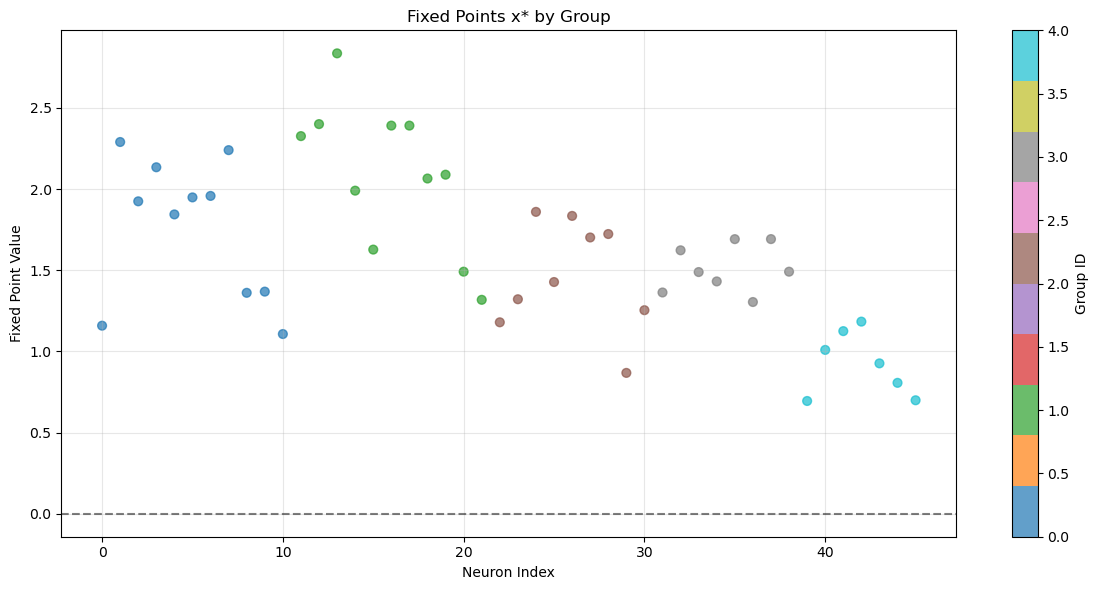

In [163]:
# Visualize fixed points by group
all_fps = []
all_group_ids = []
neuron_indices = []

for group_id, fp in ctrnn_results.fixed_points.items():
    all_fps.extend(fp)
    all_group_ids.extend([group_id] * len(fp))

# Create neuron indices respecting group structure
idx = 0
for group_id in unique_groups:
    group_size = len(ctrnn_results.fixed_points[group_id])
    neuron_indices.extend(range(idx, idx + group_size))
    idx += group_size

plt.figure(figsize=(12, 6))
scatter = plt.scatter(neuron_indices, all_fps, c=all_group_ids,
                      cmap='tab10', alpha=0.7, s=40)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.title('Fixed Points x* by Group')
plt.xlabel('Neuron Index')
plt.ylabel('Fixed Point Value')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Group ID')
plt.tight_layout()
plt.show()

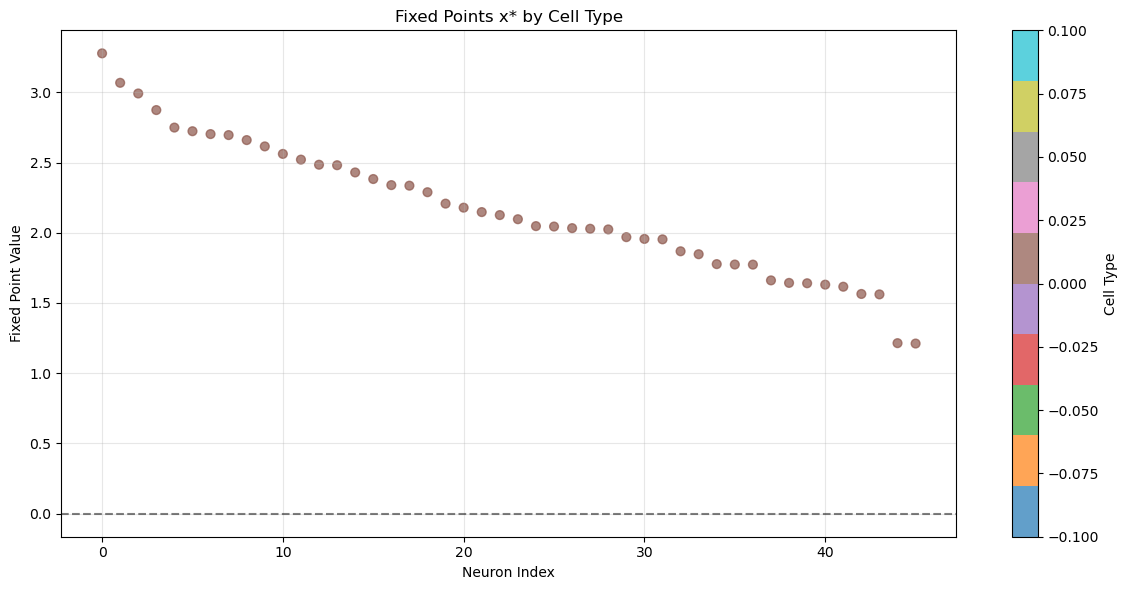

In [164]:
# Visualize fixed points by group
all_fps = []
all_group_ids = []
neuron_indices = []

for group_id, fp in ctrnn_results.fixed_points_global.items():
    all_fps.extend(fp)
    all_group_ids.extend([group_id] * len(fp))

# Create neuron indices respecting group structure
neuron_indices = list(range(len(all_fps)))

# Create cell type boundaries for visualization
cell_type_boundaries = []
current_idx = 0
for cell_type in unique_cell_types:
    count = ctoi_grouped.count(cell_type)
    if count > 0:
        cell_type_boundaries.append(current_idx + count)
        current_idx += count

# Sort fixed points within each cell type boundary
sorted_fps = []
sorted_indices = []
sorted_group_ids = []

current_idx = 0
for cell_type in unique_cell_types:
    # Get indices for this cell type
    cell_type_indices = [i for i, ct in enumerate(ctoi_grouped) if ct == cell_type]
    
    if len(cell_type_indices) == 0:
        continue
    
    # Get fixed points and group IDs for this cell type
    cell_type_fps = [all_fps[i] for i in cell_type_indices]
    cell_type_groups = [all_group_ids[i] for i in cell_type_indices]
    
    # Sort by fixed point value in descending order
    sorted_cell_indices = sorted(range(len(cell_type_fps)), 
                                key=lambda i: cell_type_fps[i], 
                                reverse=True)
    
    # Append sorted values
    for i in sorted_cell_indices:
        sorted_fps.append(cell_type_fps[i])
        sorted_indices.append(current_idx)
        sorted_group_ids.append(cell_type_groups[i])
        current_idx += 1

# Update variables for plotting
all_fps = sorted_fps
all_group_ids = sorted_group_ids
neuron_indices = sorted_indices

# Create a color mapping based on cell type groups
cell_type_colors = []
for i in sorted_indices:
    cell_type = ctoi_grouped[i]
    cell_type_idx = unique_cell_types.index(cell_type)
    cell_type_colors.append(cell_type_idx)

plt.figure(figsize=(12, 6))
scatter = plt.scatter(neuron_indices, all_fps, c=cell_type_colors,
                      cmap='tab10', alpha=0.7, s=40)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.title('Fixed Points x* by Cell Type')
plt.xlabel('Neuron Index')
plt.ylabel('Fixed Point Value')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Cell Type')
plt.tight_layout()
plt.show()

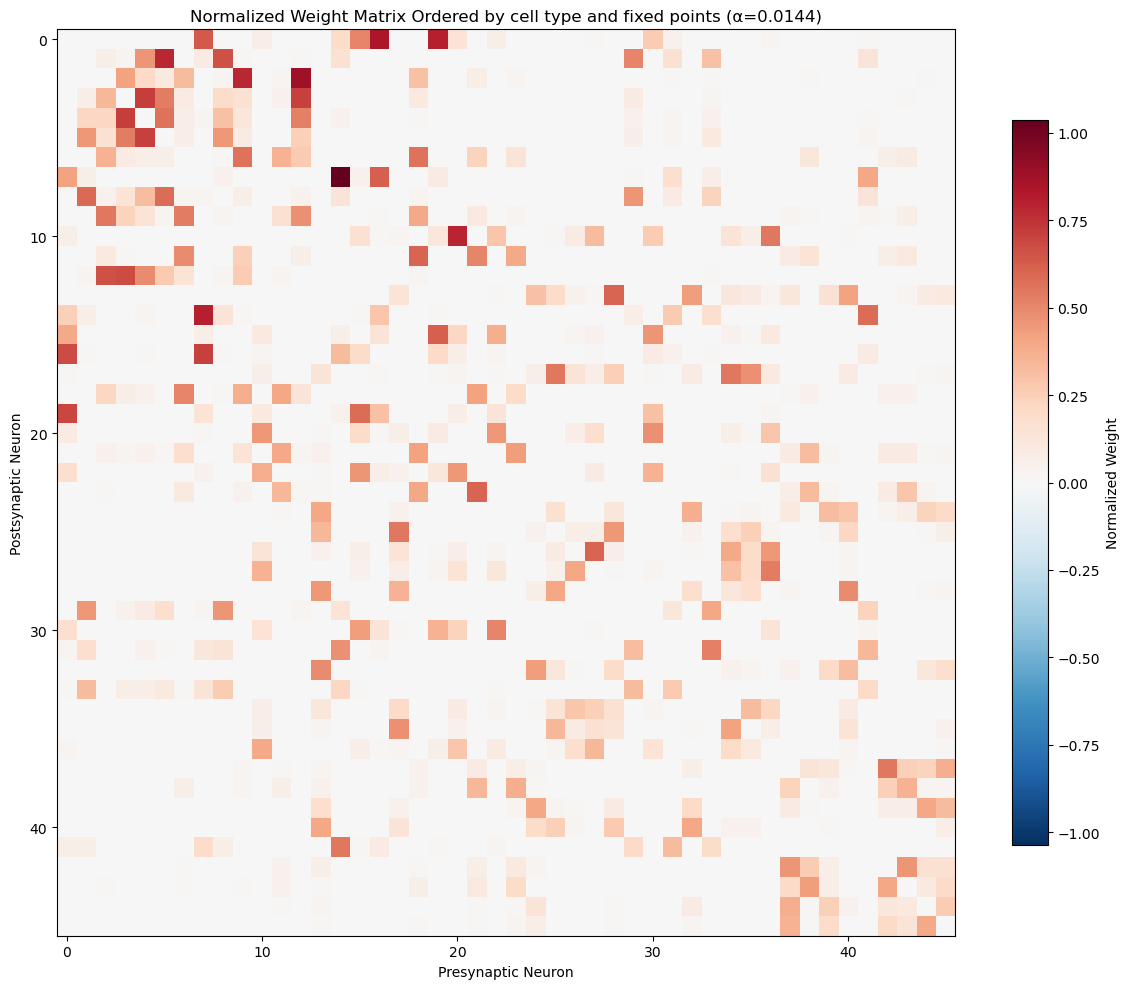

In [165]:
# Visualize the normalized weight matrix with group boundaries
W_normalized = ctrnn_results.W_normalized.copy()

# Sort W_normalized by cell type and fixed point values
# Get fixed points from global results
all_fps = []
for group_id in sorted(ctrnn_results.fixed_points_global.keys()):
    all_fps.extend(ctrnn_results.fixed_points_global[group_id])

# Create cell type boundaries
current_idx = 0
sorted_indices_all = []

for cell_type in unique_cell_types:
    # Get indices for this cell type
    cell_type_indices = [i for i, ct in enumerate(ctoi_grouped) if ct == cell_type]
    
    if len(cell_type_indices) == 0:
        continue
    
    # Get fixed points for this cell type
    cell_type_fps = [all_fps[i] for i in cell_type_indices]
    
    # Sort by fixed point value in descending order
    sorted_cell_indices = sorted(range(len(cell_type_fps)), 
                                key=lambda i: cell_type_fps[i], 
                                reverse=True)
    
    # Map back to original indices
    sorted_original_indices = [cell_type_indices[i] for i in sorted_cell_indices]
    sorted_indices_all.extend(sorted_original_indices)

# Reorder W_normalized by the sorted indices
W_normalized_ordered = W_normalized[np.ix_(sorted_indices_all, sorted_indices_all)]

# Create figure
plt.figure(figsize=(12, 10))
vmax_norm = max(abs(W_normalized_ordered.min()), abs(W_normalized_ordered.max()))
plt.imshow(W_normalized_ordered, cmap='RdBu_r', aspect='auto',
           vmin=-vmax_norm, vmax=vmax_norm)
plt.colorbar(label='Normalized Weight', shrink=0.8)
plt.title(f'Normalized Weight Matrix Ordered by cell type and fixed points (α={ctrnn_results.normalization_factor:.4f})')
plt.xlabel('Presynaptic Neuron')
plt.ylabel('Postsynaptic Neuron')

plt.tight_layout()
plt.show()

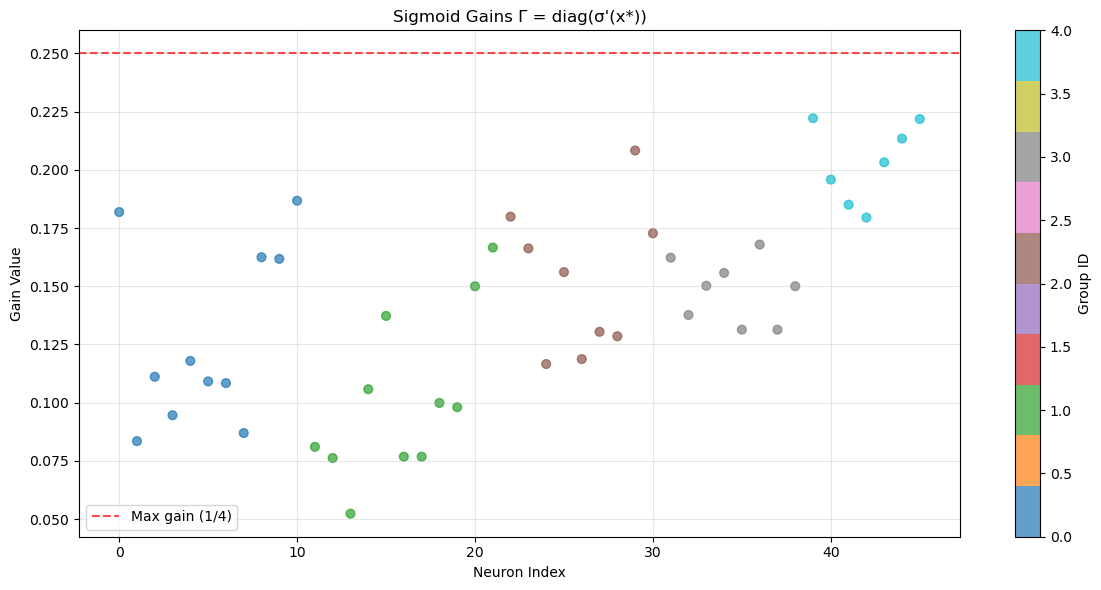

In [166]:
# Visualize sigmoid gains
all_gains = []
all_group_ids = []
for group_id, gains in ctrnn_results.sigmoid_gains.items():
    all_gains.extend(np.diag(gains))
    all_group_ids.extend([group_id] * len(gains))

plt.figure(figsize=(12, 6))
scatter = plt.scatter(neuron_indices, all_gains, c=all_group_ids,
                      cmap='tab10', alpha=0.7, s=40)
plt.axhline(0.25, color='red', linestyle='--', alpha=0.7,
            label='Max gain (1/4)')
plt.title("Sigmoid Gains Γ = diag(σ'(x*))")
plt.xlabel('Neuron Index')
plt.ylabel('Gain Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Group ID')
plt.tight_layout()
plt.show()

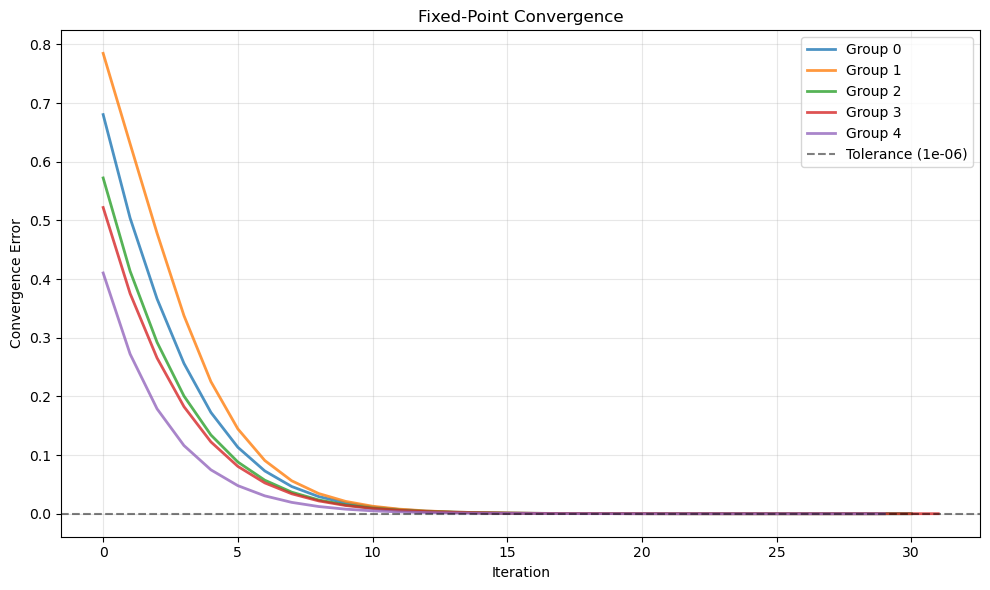

In [167]:
# Visualize convergence history
plt.figure(figsize=(10, 6))

for group_id, conv_info in ctrnn_results.convergence_info.items():
    errors = conv_info['error_history']
    # plt.semilogy(errors, label=f'Group {group_id}', linewidth=2, alpha=0.8)
    plt.plot(errors, label=f'Group {group_id}', linewidth=2, alpha=0.8)

plt.axhline(ctrnn.tolerance, color='k', linestyle='--', alpha=0.5,
            label=f'Tolerance ({ctrnn.tolerance:.0e})')
plt.xlabel('Iteration')
# plt.ylabel('Convergence Error (log)')
plt.ylabel('Convergence Error')
plt.title('Fixed-Point Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


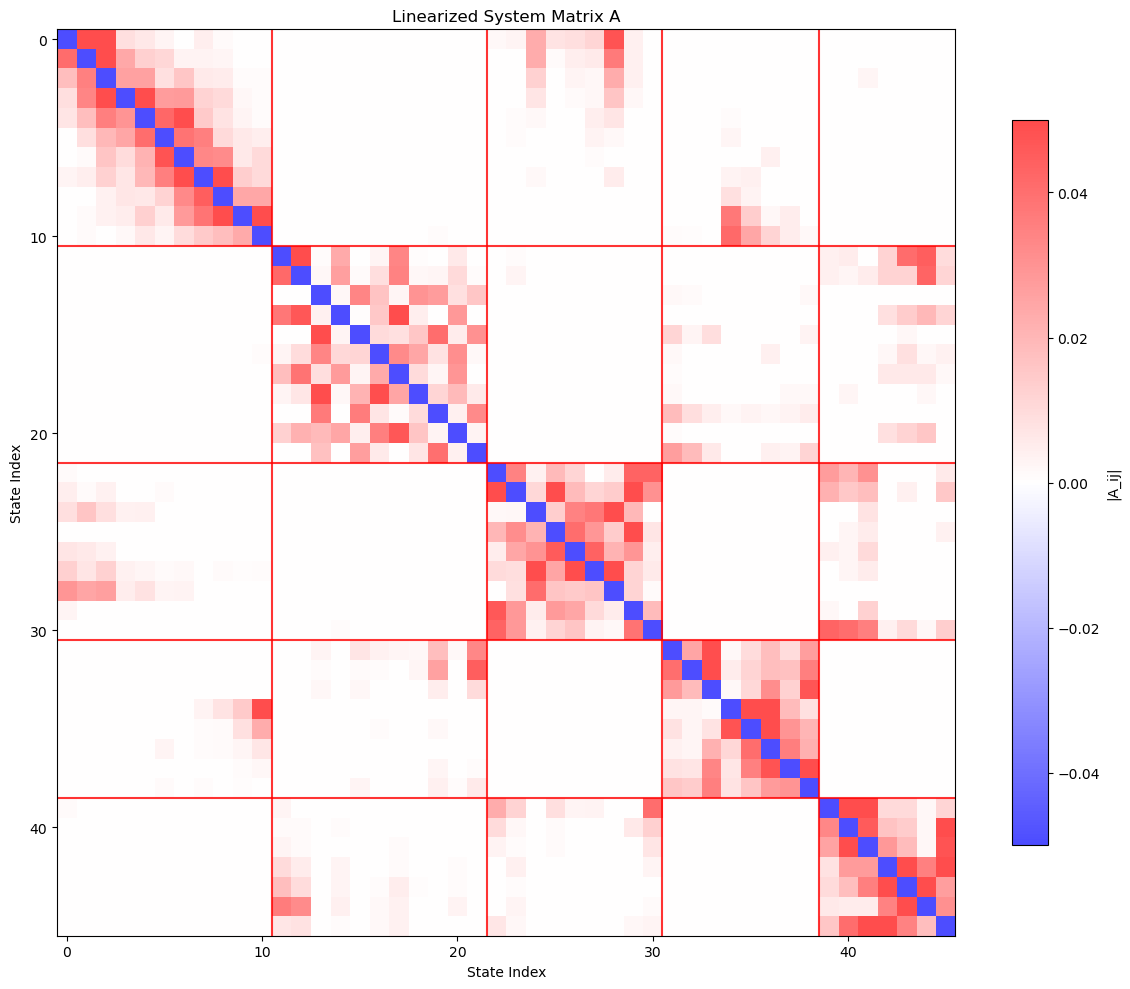

In [168]:
# Visualize the linearized system matrix A
plt.figure(figsize=(12, 10))

A_global = ctrnn_results.A_global
node_order = np.argsort(group_labels)
A_global_ordered = A_global[np.ix_(node_order, node_order)]

# Plot with block structure
plt.imshow(A_global_ordered, cmap='bwr', alpha=0.7, aspect='auto',
           vmin=-0.05, vmax=0.05)
        #    vmin=-np.max(np.abs(ctrnn_results.A_global)), vmax=np.max(np.abs(ctrnn_results.A_global)))
plt.colorbar(label='|A_ij|', shrink=0.8)
plt.title('Linearized System Matrix A')
plt.xlabel('State Index')
plt.ylabel('State Index')

# Add group boundaries
group_boundaries = []
current_pos = 0
for group_id in unique_groups:
    group_size = np.sum(group_labels == group_id)
    group_boundaries.append(current_pos + group_size)
    current_pos += group_size

for boundary in group_boundaries[:-1]:
    plt.axhline(y=boundary-0.5, color='red', linewidth=1.5, alpha=0.8)
    plt.axvline(x=boundary-0.5, color='red', linewidth=1.5, alpha=0.8)

plt.tight_layout()
plt.show()

#### Spectral properties

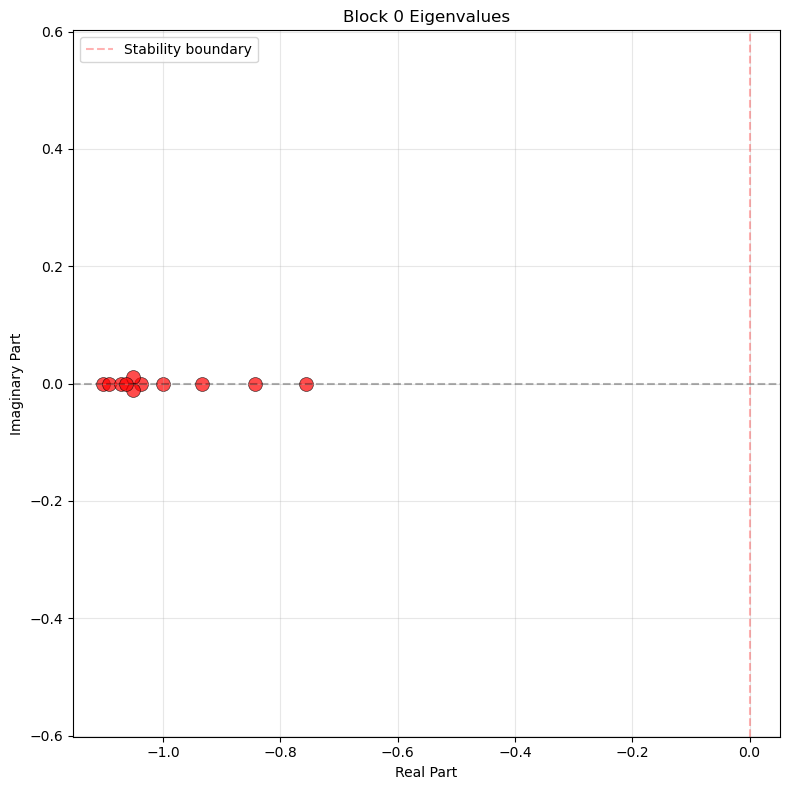


Group 0 eigenvalue statistics:
  Number of eigenvalues: 11
  Max real part: -0.756785
  Min real part: -1.101761
  Max imaginary part: 0.010336


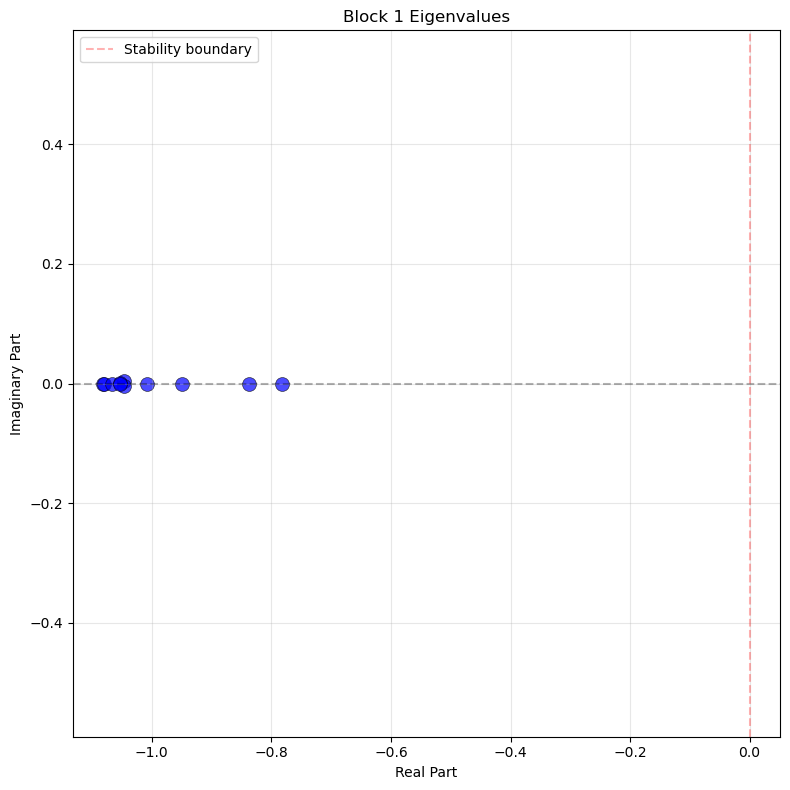


Group 1 eigenvalue statistics:
  Number of eigenvalues: 11
  Max real part: -0.782247
  Min real part: -1.080980
  Max imaginary part: 0.004162


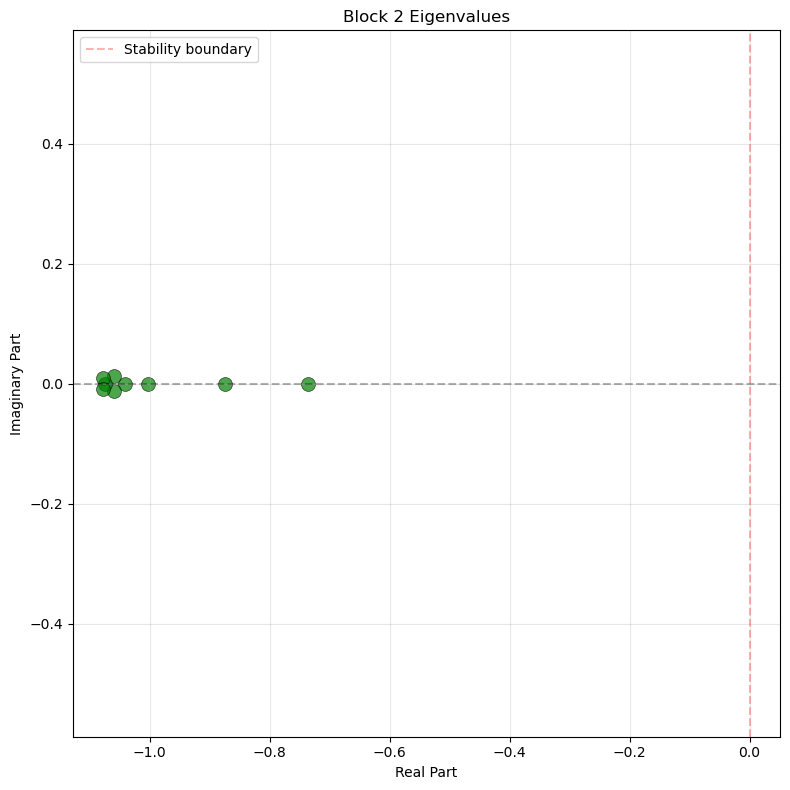


Group 2 eigenvalue statistics:
  Number of eigenvalues: 9
  Max real part: -0.735971
  Min real part: -1.077201
  Max imaginary part: 0.013236


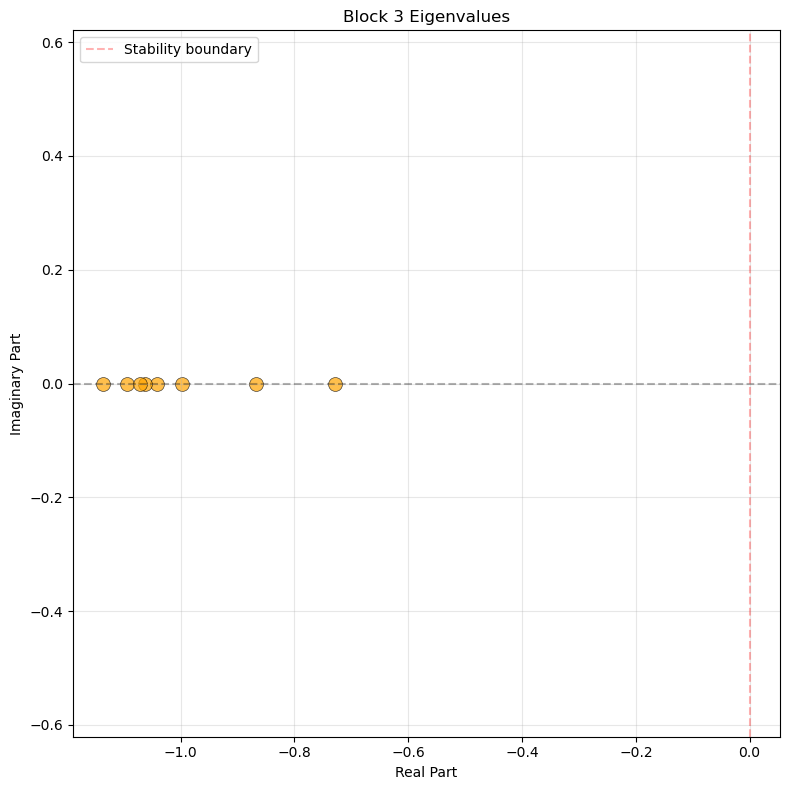


Group 3 eigenvalue statistics:
  Number of eigenvalues: 8
  Max real part: -0.728641
  Min real part: -1.135865
  Max imaginary part: 0.000000


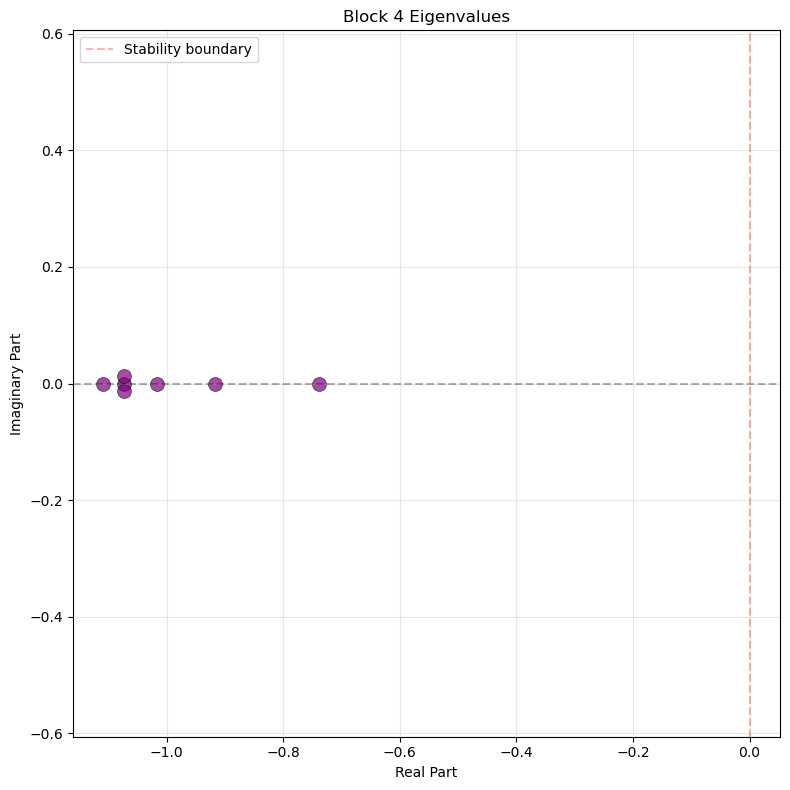


Group 4 eigenvalue statistics:
  Number of eigenvalues: 7
  Max real part: -0.737969
  Min real part: -1.108353
  Max imaginary part: 0.012120


In [169]:
# Visualize block eigenvalues in complex plane
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

for i, (group_id, eigenvals) in enumerate(ctrnn_results.eigenvalues.items()):
    plt.figure(figsize=(8, 8))
    
    plt.scatter(np.real(eigenvals), np.imag(eigenvals),
                c=colors[i % len(colors)], 
                alpha=0.7, s=100, edgecolors='black', linewidths=0.5)
    
    plt.axhline(0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(0, color='r', linestyle='--', alpha=0.3, label='Stability boundary')
    
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title(f'Block {group_id} Eigenvalues')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # Print eigenvalue statistics for this group
    print(f"\nGroup {group_id} eigenvalue statistics:")
    print(f"  Number of eigenvalues: {len(eigenvals)}")
    print(f"  Max real part: {np.max(np.real(eigenvals)):.6f}")
    print(f"  Min real part: {np.min(np.real(eigenvals)):.6f}")
    print(f"  Max imaginary part: {np.max(np.abs(np.imag(eigenvals))):.6f}")

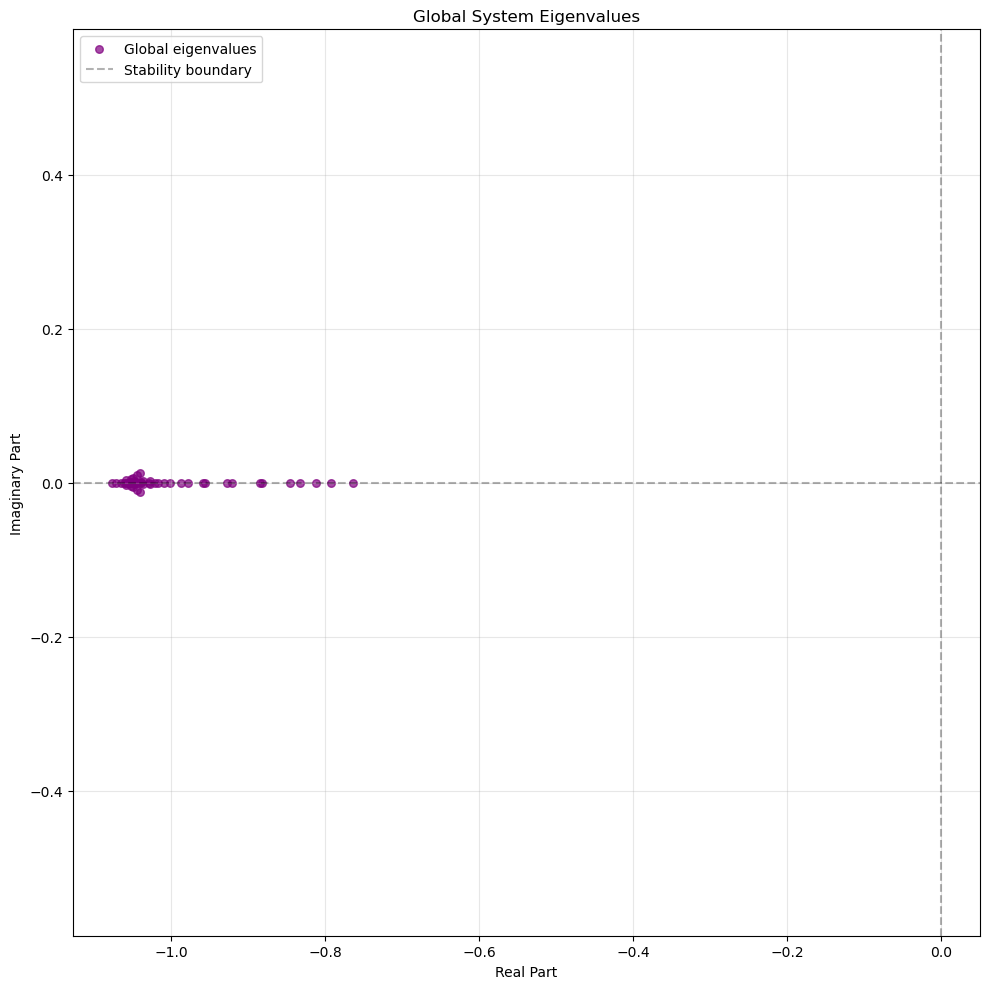

In [170]:
# Visualize global system eigenvalues
plt.figure(figsize=(10, 10))

global_eigs = stability_info['eigenvalues']
plt.scatter(np.real(global_eigs), np.imag(global_eigs),
            c='purple', alpha=0.7, s=30, label='Global eigenvalues')

# Highlight unstable eigenvalues
unstable_mask = np.real(global_eigs) >= 0
if np.any(unstable_mask):
    plt.scatter(np.real(global_eigs[unstable_mask]),
                np.imag(global_eigs[unstable_mask]),
                c='red', s=100, marker='x', linewidths=3,
                label='Unstable modes')

plt.axhline(0, color='k', linestyle='--', alpha=0.3)
plt.axvline(0, color='k', linestyle='--', alpha=0.3,
            label='Stability boundary')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Global System Eigenvalues')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

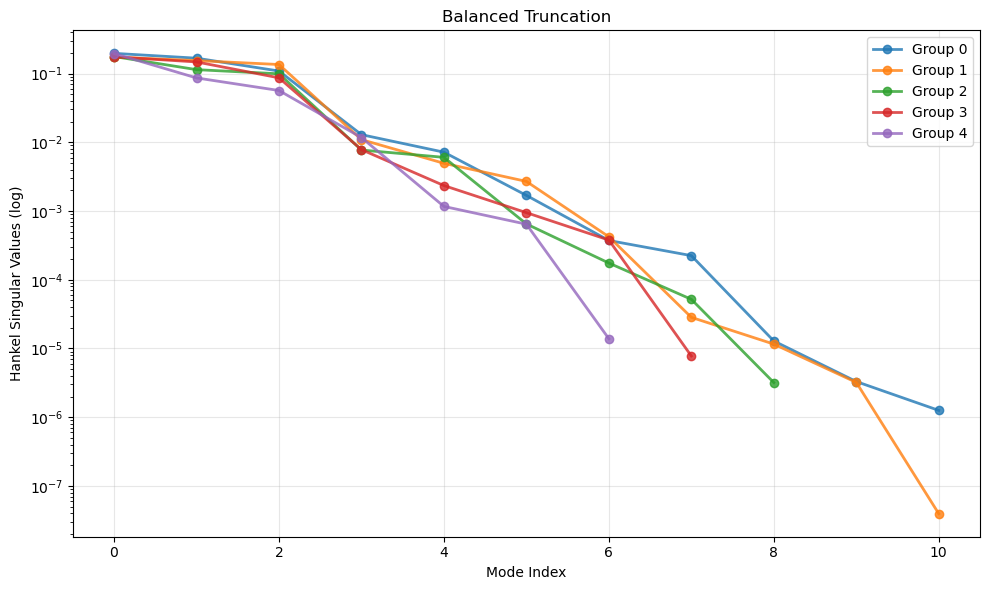

In [171]:
# Plot balanced truncation (Hankel singular values)
if ctrnn_results.balanced_truncation is not None:
    plt.figure(figsize=(10, 6))
    
    for group_id, bt_results in ctrnn_results.balanced_truncation.items():
        if bt_results['stable'] and bt_results['hankel_svs'] is not None:
            hankel_svs = bt_results['hankel_svs']
            plt.semilogy(hankel_svs, 'o-', label=f'Group {group_id}',
                        linewidth=2, markersize=6, alpha=0.8)
    
    plt.xlabel('Mode Index')
    plt.ylabel('Hankel Singular Values (log)')
    plt.title('Balanced Truncation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set x-axis to display only integer ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.show()
else:
    print('Balanced truncation not computed')


In [172]:
# ============================================================================
# Summary Report
# ============================================================================

print("\n" + "="*60)
print("CTRNN ANALYSIS SUMMARY REPORT")
print("="*60)

print(f"DATASET:")
print(f"- Network size: {W.shape[0]} neurons")
print(f"- Number of groups: {len(unique_groups)}")
print(f"- Weight matrix density: {np.count_nonzero(W)/W.size:.1%}")
print(f"- Excitatory connections: {np.sum(W > 0)}")
print(f"- Inhibitory connections: {np.sum(W < 0)}")

print(f"\nNORMALIZATION:")
print(f"- Original ∞-norm: {ctrnn_results.original_norm:.4f}")
print(f"- Normalization factor α: {ctrnn_results.normalization_factor:.6f}")
print(f"- Contraction achieved: {'✓' if normalized_norm <= 4 * ctrnn_results.safety_margin else '✗'}")
print(f"- Safety margin: {ctrnn_results.safety_margin}")

print(f"\nCONVERGENCE:")
print(f"- All groups converged: {'✓' if all_converged else '✗'}")
print(f"- Total iterations: {sum(conv['iterations'] for conv in ctrnn_results.convergence_info.values())}")
print(f"- Average final error: {np.mean([conv['final_error'] for conv in ctrnn_results.convergence_info.values()]):.2e}")

print(f"\nDYNAMICS:")
print(f"- System stable: {'✓' if stability_info['is_stable'] else '✗'}")
print(f"- Max real eigenvalue: {stability_info['max_real_eigenvalue']:.6f}")
print(f"- Unstable modes: {stability_info['num_unstable_modes']}")
print(f"- Stability margin: {stability_info['stability_margin']:.6f}" if stability_info['stability_margin'] else "- Stability margin: N/A")

print(f"\nFIXED POINTS:")
fp_stats = np.concatenate(list(ctrnn_results.fixed_points.values()))
print(f"- Mean fixed point: {fp_stats.mean():.4f}")
print(f"- Fixed point std: {fp_stats.std():.4f}")
print(f"- Fixed point range: [{fp_stats.min():.4f}, {fp_stats.max():.4f}]")

print(f"\nSIGMOID GAINS:")
gain_stats = np.concatenate([np.diag(gains) for gains in ctrnn_results.sigmoid_gains.values()])
print(f"- Mean gain: {gain_stats.mean():.4f}")
print(f"- Gain std: {gain_stats.std():.4f}")
print(f"- Gain range: [{gain_stats.min():.4f}, {gain_stats.max():.4f}]")
print(f"- Theoretical maximum: 0.25")

print(f"\nANALYSIS COMPLETE!")
print(f"- Pipeline executed successfully")
print(f"- {len(ctrnn_results.A_blocks)} block dynamics computed")
print(f"- {len(ctrnn_results.E_blocks)} coupling matrices computed")
print(f"- Global {ctrnn_results.A_global.shape[0]}×{ctrnn_results.A_global.shape[1]} system linearized")

print("="*60)


CTRNN ANALYSIS SUMMARY REPORT
DATASET:
- Network size: 46 neurons
- Number of groups: 5
- Weight matrix density: 29.9%
- Excitatory connections: 632
- Inhibitory connections: 0

NORMALIZATION:
- Original ∞-norm: 250.0000
- Normalization factor α: 0.014400
- Contraction achieved: ✓
- Safety margin: 0.9

CONVERGENCE:
- All groups converged: ✓
- Total iterations: 154
- Average final error: 8.60e-07

DYNAMICS:
- System stable: ✓
- Max real eigenvalue: -0.763310
- Unstable modes: 0
- Stability margin: 0.763310

FIXED POINTS:
- Mean fixed point: 1.6076
- Fixed point std: 0.5010
- Fixed point range: [0.6944, 2.8360]

SIGMOID GAINS:
- Mean gain: 0.1415
- Gain std: 0.0431
- Gain range: [0.0523, 0.2221]
- Theoretical maximum: 0.25

ANALYSIS COMPLETE!
- Pipeline executed successfully
- 5 block dynamics computed
- 20 coupling matrices computed
- Global 46×46 system linearized


#### Port controllability

In [173]:
# Port analysis: inter-block ports & controllability
print("\n\n" + "=" * 60)
print("Port Analysis: Inter-Block Control Ports & Controllability")
print("=" * 60)

# Initialize port analyzer
num_groups = len(np.unique(group_labels))
if num_groups > 1:
    port_analyzer = PortAnalyzer()

    print("Running port analysis...")
    print(f"Number of inter-block connections: {len(ctrnn_results.E_blocks)}")

    # Run port analysis using results from CTRNN analysis
    port_results = port_analyzer.analyze_ports(
        A_blocks=ctrnn_results.A_blocks,
        B_blocks=ctrnn_results.B_blocks,
        C_blocks=ctrnn_results.C_blocks,
        E_blocks=ctrnn_results.E_blocks
    )

    print("✓ Port analysis completed")
    print(f"Total ports analyzed: {len(port_results.port_map)}")



Port Analysis: Inter-Block Control Ports & Controllability
Running port analysis...
Number of inter-block connections: 20
✓ Port analysis completed
Total ports analyzed: 20


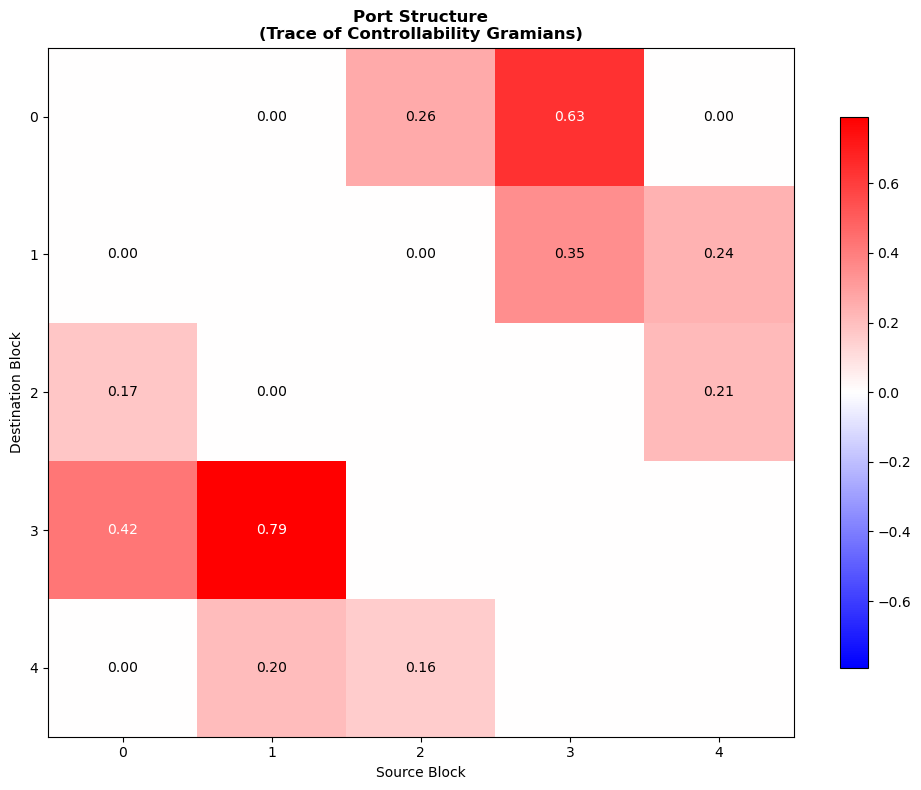

In [174]:
# Port structure overview
fig = plt.figure(figsize=(10, 8))

# Create port connectivity matrix for visualization
num_blocks = len(ctrnn_results.A_blocks)
port_matrix = np.zeros((num_blocks, num_blocks))
for (dest, src) in port_results.port_map.keys():
    port_matrix[dest, src] = port_results.port_metrics[(dest, src)].trace

im = plt.imshow(port_matrix, cmap='bwr', aspect='auto',
                vmin=-np.max(np.abs(port_matrix)), vmax=np.max(np.abs(port_matrix)))
plt.title('Port Structure\n(Trace of Controllability Gramians)', fontweight='bold')
plt.xlabel('Source Block')
plt.ylabel('Destination Block')
plt.xticks(range(num_blocks))
plt.yticks(range(num_blocks))

# Annotate with values
for i in range(num_blocks):
    for j in range(num_blocks):
        if port_matrix[i, j] > 0:
            plt.text(j, i, f'{port_matrix[i, j]:.2f}', ha='center', va='center',
                    color='white' if port_matrix[i, j] > port_matrix.max()/2 else 'black')

plt.colorbar(im, shrink=0.8)
plt.tight_layout()
plt.show()

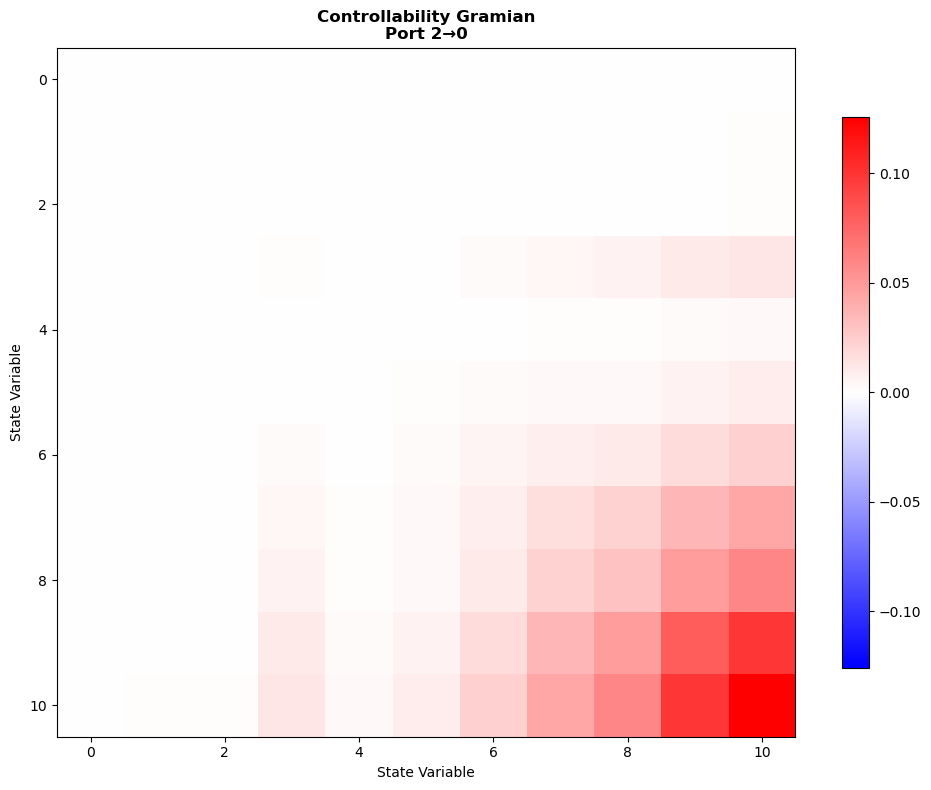

In [175]:
# Port controllability gramians heatmap
fig = plt.figure(figsize=(10, 8))
port_keys = list(port_results.Wc_port.keys())
if port_keys:
    # Select first port for detailed view
    selected_port = port_keys[1]
    selected_gramian = port_results.Wc_port[selected_port]

    im = plt.imshow(selected_gramian, cmap='bwr', aspect='auto',
                    vmin=-np.max(np.abs(selected_gramian)), vmax=np.max(np.abs(selected_gramian)))
    plt.title(f'Controllability Gramian\nPort {selected_port[1]}→{selected_port[0]}', fontweight='bold')
    plt.xlabel('State Variable')
    plt.ylabel('State Variable')
    plt.colorbar(im, shrink=0.8)
else:
    plt.text(0.5, 0.5, 'No ports\nanalyzed', ha='center', va='center',
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Port Controllability Gramian')

plt.tight_layout()
plt.show()

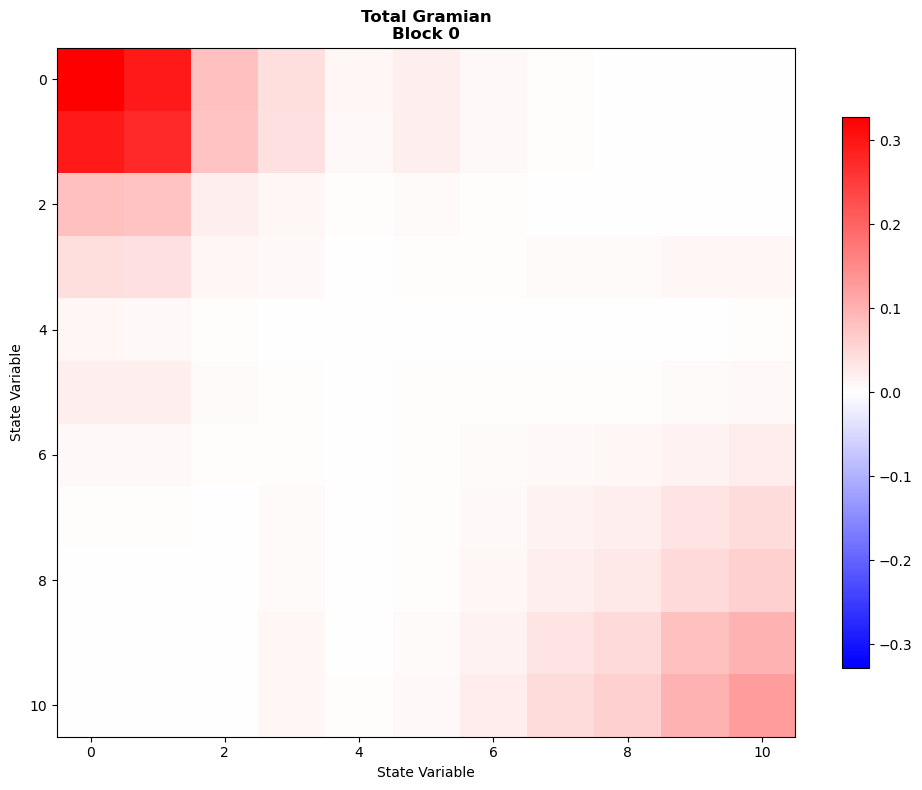

In [176]:
# Total Gramian per block
fig = plt.figure(figsize=(10, 8))
if len(ctrnn_results.A_blocks) > 0:
    block_id = list(ctrnn_results.A_blocks.keys())[0]
    total_gramian = port_results.Wc_total[block_id]

    im = plt.imshow(total_gramian, cmap='bwr', aspect='auto',
                    vmin=-np.max(np.abs(total_gramian)), vmax=np.max(np.abs(total_gramian)))
    plt.title(f'Total Gramian\nBlock {block_id}', fontweight='bold')
    plt.xlabel('State Variable')
    plt.ylabel('State Variable')
    plt.colorbar(im, shrink=0.8)

plt.tight_layout()
plt.show()

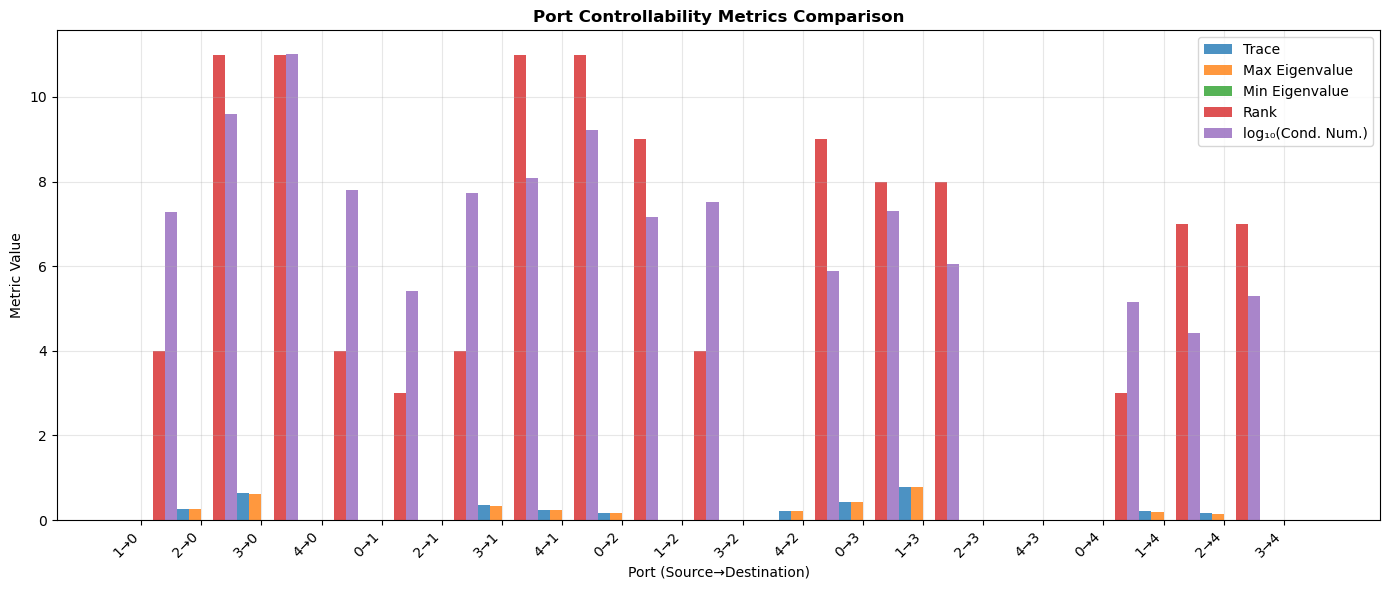


Port 1→0:
  Trace: 1.06e-04
  Max Eigenvalue: 1.05e-04
  Min Eigenvalue: 0.00e+00
  Rank: 4
  Condition Number: 1.96e+07
Port 2→0:
  Trace: 2.61e-01
  Max Eigenvalue: 2.55e-01
  Min Eigenvalue: 6.32e-11
  Rank: 11
  Condition Number: 4.04e+09
Port 3→0:
  Trace: 6.32e-01
  Max Eigenvalue: 6.25e-01
  Min Eigenvalue: 5.92e-12
  Rank: 11
  Condition Number: 1.05e+11
Port 4→0:
  Trace: 1.06e-04
  Max Eigenvalue: 1.05e-04
  Min Eigenvalue: 0.00e+00
  Rank: 4
  Condition Number: 6.49e+07
Port 0→1:
  Trace: 1.05e-04
  Max Eigenvalue: 1.04e-04
  Min Eigenvalue: 0.00e+00
  Rank: 3
  Condition Number: 2.60e+05
Port 2→1:
  Trace: 1.11e-03
  Max Eigenvalue: 1.10e-03
  Min Eigenvalue: 0.00e+00
  Rank: 4
  Condition Number: 5.35e+07
Port 3→1:
  Trace: 3.49e-01
  Max Eigenvalue: 3.39e-01
  Min Eigenvalue: 2.82e-09
  Rank: 11
  Condition Number: 1.20e+08
Port 4→1:
  Trace: 2.39e-01
  Max Eigenvalue: 2.28e-01
  Min Eigenvalue: 1.41e-10
  Rank: 11
  Condition Number: 1.62e+09
Port 0→2:
  Trace: 1.75e-01

In [177]:
# Port metrics comparison
fig = plt.figure(figsize=(14, 6))
if port_results.port_metrics:
    port_labels = [f"{src}→{dest}" for (dest, src) in port_results.port_metrics.keys()]
    metrics_data = {
        'Trace': [m.trace for m in port_results.port_metrics.values()],
        'Max Eigenvalue': [m.lambda_max for m in port_results.port_metrics.values()],
        'Min Eigenvalue': [m.lambda_min for m in port_results.port_metrics.values()],
        'Rank': [m.rank for m in port_results.port_metrics.values()],
        'Condition Number': [np.log10(m.condition_number) for m in port_results.port_metrics.values()]
    }

    x = np.arange(len(port_labels))
    width = 0.2

    for i, (metric, values) in enumerate(metrics_data.items()):
        offset = (i - 1.5) * width
        label = metric if metric != 'Condition Number' else 'log₁₀(Cond. Num.)'
        plt.bar(x + offset, values, width, label=label, alpha=0.8)

    plt.title('Port Controllability Metrics Comparison', fontweight='bold')
    plt.xlabel('Port (Source→Destination)')
    plt.ylabel('Metric Value')
    plt.xticks(x, port_labels, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of port analysis
print("\n" + "="*60)
for (dest, src), metrics in port_results.port_metrics.items():
    print(f"Port {src}→{dest}:")
    print(f"  Trace: {metrics.trace:.2e}")
    print(f"  Max Eigenvalue: {metrics.lambda_max:.2e}")
    print(f"  Min Eigenvalue: {metrics.lambda_min:.2e}")
    print(f"  Rank: {metrics.rank}")
    print(f"  Condition Number: {metrics.condition_number:.2e}")

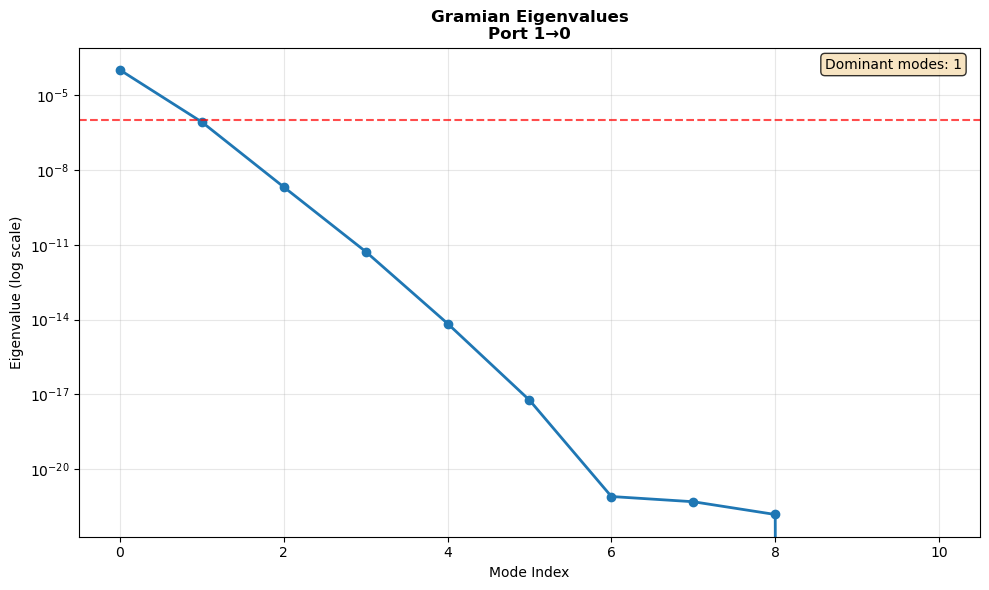

In [178]:
# Eigenmode analysis
fig = plt.figure(figsize=(10, 6))
if port_keys:
    selected_gramian = port_results.Wc_port[port_keys[0]]
    eigenvals, eigenvecs = np.linalg.eigh(selected_gramian)
    eigenvals = eigenvals[::-1]  # Sort descending

    plt.semilogy(eigenvals, 'o-', linewidth=2, markersize=6)
    plt.title(f'Gramian Eigenvalues\nPort {port_keys[0][1]}→{port_keys[0][0]}', fontweight='bold')
    plt.xlabel('Mode Index')
    plt.ylabel('Eigenvalue (log scale)')
    plt.grid(True, alpha=0.3)

    # Highlight dominant modes
    dominant_threshold = eigenvals[0] * 0.01  # 1% of max
    dominant_modes = np.sum(eigenvals > dominant_threshold)
    plt.axhline(dominant_threshold, color='red', linestyle='--', alpha=0.7)
    plt.text(0.98, 0.98, f'Dominant modes: {dominant_modes}', transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))


plt.tight_layout()
plt.show()

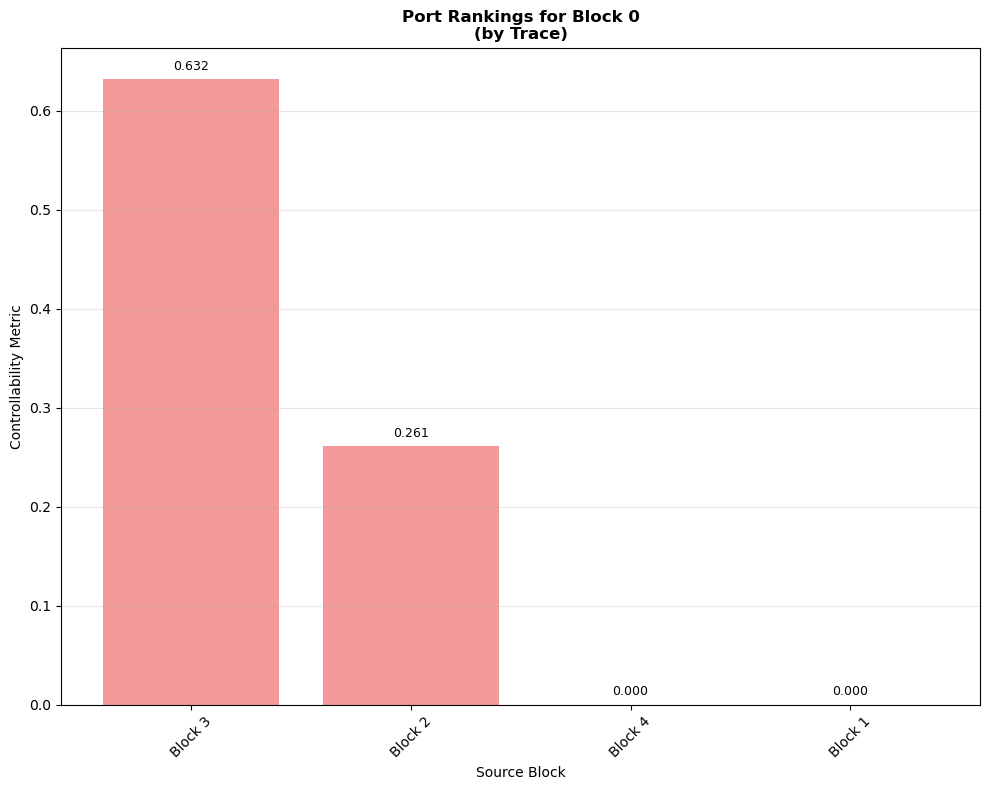

In [179]:
# Port rankings
fig = plt.figure(figsize=(10, 8))
if port_results.top_ports:
    # Show rankings for first block
    block_id = list(port_results.top_ports.keys())[0]
    rankings = port_results.top_ports[block_id]

    if rankings:
        sources = [f"Block {src}" for src, _ in rankings]
        values = [val for _, val in rankings]

        bars = plt.bar(sources, values, alpha=0.8, color='lightcoral')
        plt.title(f'Port Rankings for Block {block_id}\n(by Trace)', fontweight='bold')
        plt.xlabel('Source Block')
        plt.ylabel('Controllability Metric')
        plt.xticks(rotation=45)

        # Annotate bars with values
        for bar, val in zip(bars, values):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(values),
                    f'{val:.3f}', ha='center', va='bottom', fontsize=9)

        plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

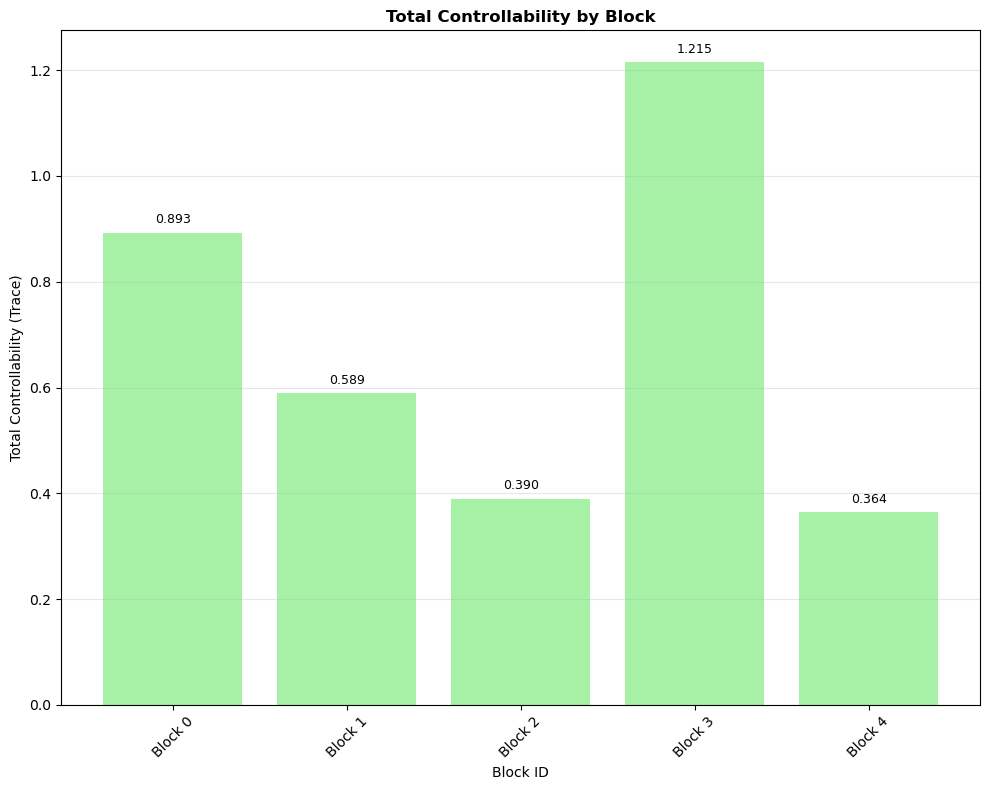

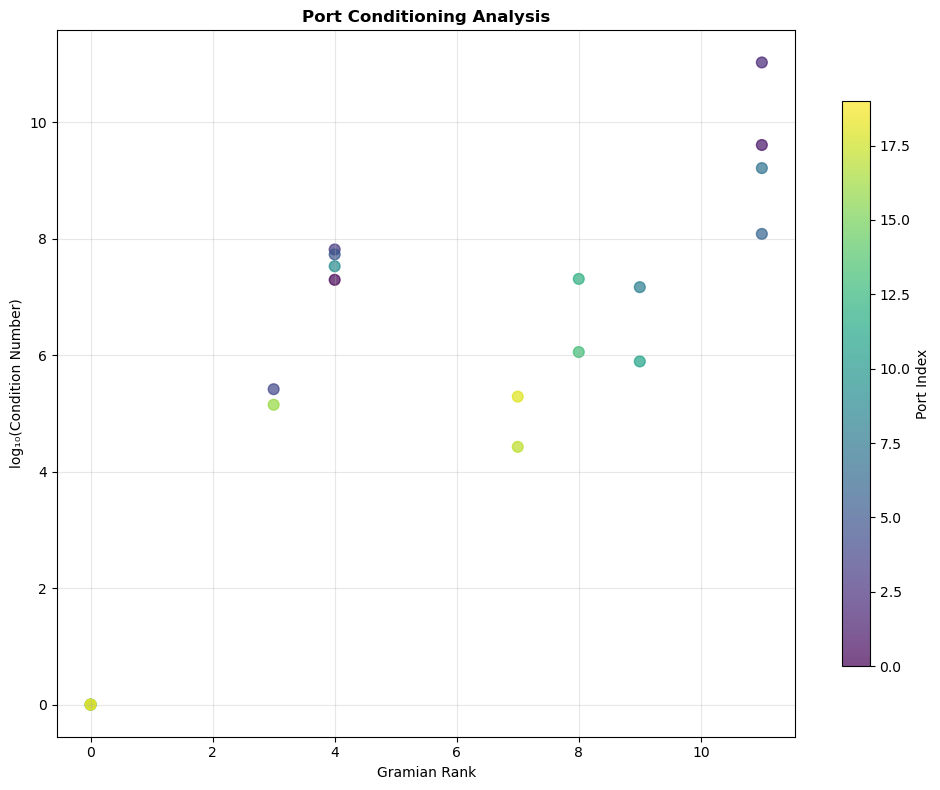

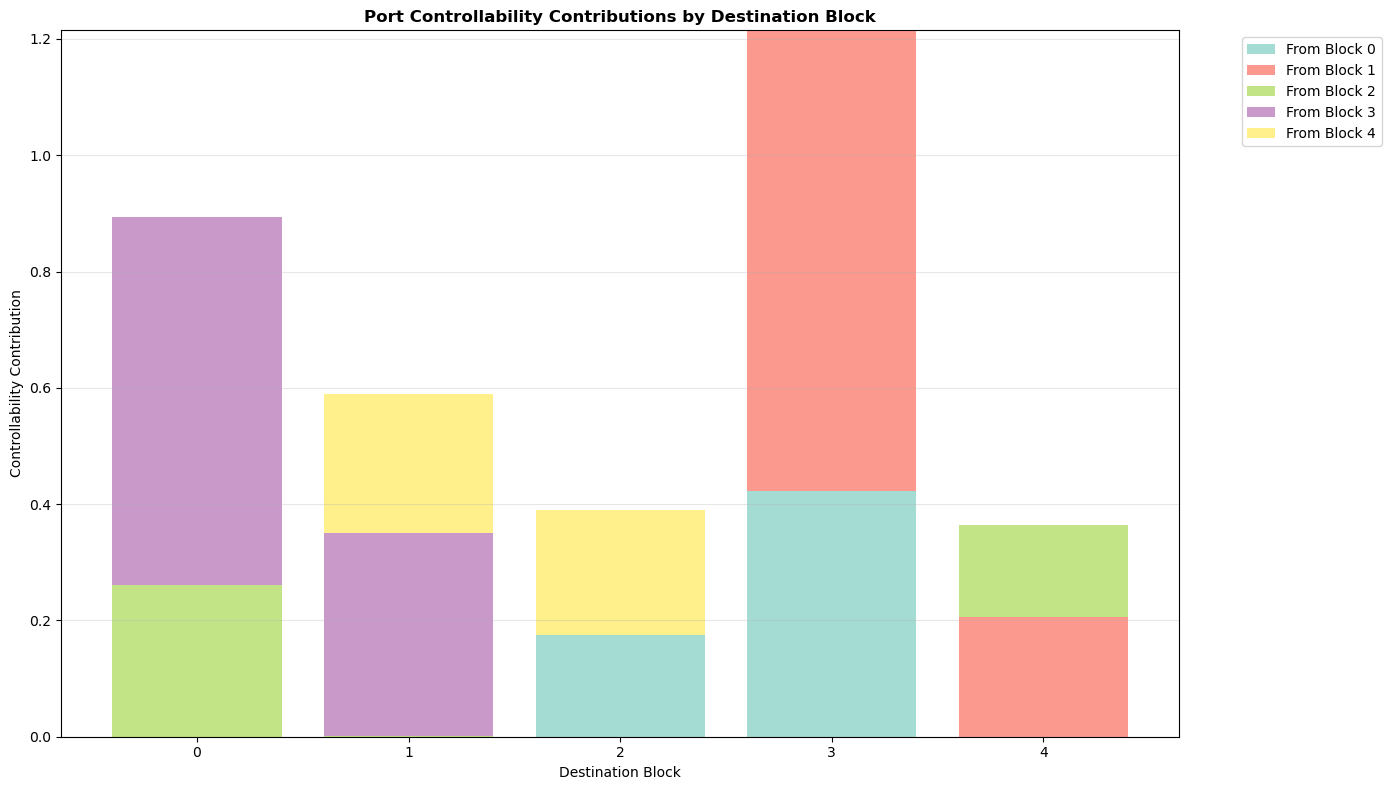


PORT ANALYSIS SUMMARY
Analysis valid: True

Total ports: 20
Total blocks: 5

Block 0:
  Total incoming ports: 4
  Total controllability: 0.8931
  Top contributing ports:
    Rank 1: Block 3 → Block 0 (0.7% contribution, metric=0.6320)
    Rank 2: Block 2 → Block 0 (0.3% contribution, metric=0.2609)
    Rank 3: Block 4 → Block 0 (0.0% contribution, metric=0.0001)

Block 1:
  Total incoming ports: 4
  Total controllability: 0.5893
  Top contributing ports:
    Rank 1: Block 3 → Block 1 (0.6% contribution, metric=0.3487)
    Rank 2: Block 4 → Block 1 (0.4% contribution, metric=0.2394)
    Rank 3: Block 2 → Block 1 (0.0% contribution, metric=0.0011)

Block 2:
  Total incoming ports: 4
  Total controllability: 0.3895
  Top contributing ports:
    Rank 1: Block 4 → Block 2 (0.6% contribution, metric=0.2146)
    Rank 2: Block 0 → Block 2 (0.4% contribution, metric=0.1748)
    Rank 3: Block 1 → Block 2 (0.0% contribution, metric=0.0001)

Block 3:
  Total incoming ports: 4
  Total controllabil

In [180]:



# 7. Block Controllability Summary
fig = plt.figure(figsize=(10, 8))
block_totals = []
block_ids_sorted = sorted(port_results.total_metrics.keys())
for block_id in block_ids_sorted:
    total_metric = port_results.total_metrics[block_id].trace
    block_totals.append(total_metric)

bars = plt.bar([f"Block {bid}" for bid in block_ids_sorted], block_totals,
               alpha=0.8, color='lightgreen')
plt.title('Total Controllability by Block', fontweight='bold')
plt.xlabel('Block ID')
plt.ylabel('Total Controllability (Trace)')
plt.xticks(rotation=45)

# Annotate bars
for bar, val in zip(bars, block_totals):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(block_totals),
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 8. Stability and Condition Analysis
fig = plt.figure(figsize=(10, 8))
condition_numbers = [port_results.port_metrics[key].condition_number
                    for key in port_results.port_metrics.keys()]
ranks = [port_results.port_metrics[key].rank
         for key in port_results.port_metrics.keys()]

scatter = plt.scatter(ranks, np.log10(condition_numbers), alpha=0.7, s=60,
                     c=range(len(ranks)), cmap='viridis')
plt.title('Port Conditioning Analysis', fontweight='bold')
plt.xlabel('Gramian Rank')
plt.ylabel('log₁₀(Condition Number)')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Port Index', shrink=0.8)
plt.tight_layout()
plt.show()

# 9. Port Contribution Analysis
fig = plt.figure(figsize=(14, 8))
if len(port_results.port_metrics) > 1:
    # Create stacked bar chart of port contributions
    block_contributions = {}
    for (dest, src), metrics in port_results.port_metrics.items():
        if dest not in block_contributions:
            block_contributions[dest] = {}
        block_contributions[dest][src] = metrics.trace

    # Prepare data for stacked bar chart
    dest_blocks = sorted(block_contributions.keys())
    all_sources = set()
    for contrib in block_contributions.values():
        all_sources.update(contrib.keys())
    all_sources = sorted(all_sources)

    # Create stacked bars
    bottom = np.zeros(len(dest_blocks))
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_sources)))

    for i, source in enumerate(all_sources):
        values = []
        for dest in dest_blocks:
            values.append(block_contributions[dest].get(source, 0))

        plt.bar(dest_blocks, values, bottom=bottom, label=f'From Block {source}',
               color=colors[i], alpha=0.8)
        bottom += values

    plt.title('Port Controllability Contributions by Destination Block', fontweight='bold')
    plt.xlabel('Destination Block')
    plt.ylabel('Controllability Contribution')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print detailed port analysis summary
from sysid.ports import summarize_port_rankings, validate_port_analysis

print("\n" + "="*50)
print("PORT ANALYSIS SUMMARY")
print("="*50)

# Validation
validation = validate_port_analysis(port_results)
print(f"Analysis valid: {validation['valid']}")
if validation['warnings']:
    print("Warnings:")
    for warning in validation['warnings']:
        print(f"  - {warning}")

print(f"\nTotal ports: {validation['summary']['num_ports']}")
print(f"Total blocks: {validation['summary']['num_blocks']}")

# Detailed rankings
rankings_summary = summarize_port_rankings(port_results, top_k=3)

for block_id, block_summary in rankings_summary.items():
    print(f"\nBlock {block_id}:")
    print(f"  Total incoming ports: {block_summary['total_incoming_ports']}")
    print(f"  Total controllability: {block_summary['total_controllability']:.4f}")
    print("  Top contributing ports:")

    for port_info in block_summary['top_ports']:
        print(f"    Rank {port_info['rank']}: Block {port_info['source_block']} → "
              f"Block {block_id} ({port_info['relative_contribution']:.1f}% contribution, "
              f"metric={port_info['metric_value']:.4f})")

print(f"\n✓ Complete CTRNN and Port Analysis finished!")
print(f"  - Linearized {W.shape[0]}-neuron network into {len(ctrnn_results.A_blocks)} blocks")
print(f"  - Analyzed {len(port_results.port_map)} inter-block control ports")
print(f"  - Computed per-port controllability metrics and rankings")

### Data-driven (simulation-based)

## Role discovery

### Computational library

### Canonical labeling

## System synthesis